# 🧭 Étape 1 : Analyse exploratoire
**Projet 3 : Anticipez les besoins en consommation des bâtiments (Seattle 2016)**  

**✍️ Auteur :** *[Raymond Francius]*  
**📚 Rôle :** *[Apprenant - Promotion Sept-2025]* — **Engineering Intelligence Artificielle (AI)** — **Openclassrooms**   
🗓️ **Date de mise à jour :** *[26-10-2025]*

---

**But de ce notebook** : Charger le fichier `2016_Building_Energy_Benchmarking.csv`, filtrer les bâtiments non résidentiels, nettoyer selon les colonnes `complianceStatus`, `DefaultData`, `Outlier`, choisir les targets (`SiteEnergyUseWN(kBtu)` et `GHGEmissionsIntensity`), produire une EDA complète, visualisations, et sauvegarder un CSV nettoyé prêt pour la suite (Étape 2 : feature engineering).

Je fournis ici :  
- la structure de projet (répertoires créés sous `/content/2016_Building_Energy_Benchmarking`),  
- le chargement automatique du CSV (depuis `/mnt/data` si présent ou via upload manuel vers `/content/2016_Building_Energy_Benchmarking/data/raw/`),  
- toutes les étapes de nettoyage, analyses descriptives et visualisations,  
- une conclusion et 7 questions / réponses potentiellement posées sur les choix réalisés.


## *2.* Création de l’arborescence du projet

Cette cellule a pour objectif d’organiser la structure du projet *Building Energy Benchmarking 2016* dans l’environnement Colab.  
Elle crée automatiquement une arborescence cohérente pour séparer les différentes étapes du pipeline :  
- **data/** : contient les données brutes, transformées et externes.  
- **notebooks/** : regroupe les notebooks dédiés à l’exploration, la modélisation et l’évaluation.  
- **scripts/** : stocke les scripts Python (prétraitement, visualisation, modèles).  
- **reports/** : accueille les figures et exports de résultats.  
- **logs/** et **tests/** : prévus pour les journaux d’exécution et les tests unitaires.

Une fois exécutée, la cellule crée ces dossiers dans `/content/2016_Building_Energy_Benchmarking/` et affiche la structure complète pour vérification.


In [1]:

# ===========================================================
# Cellule 2 — création de l'arborescence du projet
# ===========================================================


import os
from pathlib import Path
import shutil

# Racine du projet dans Colab
ROOT = Path('/content/2016_Building_Energy_Benchmarking')

# Structure demandée
structure = {
    "data": ["raw", "processed", "external"],
    "notebooks": ["exploration", "modelisation", "evaluation"],
    "scripts": ["preprocessing", "visualisation", "modeles"],
    "reports": ["figures", "exports"],
    "logs": [],
    "tests": []
}

# Création des dossiers
def create_structure(root: Path, structure: dict):
    root.mkdir(parents=True, exist_ok=True)
    for folder, subfolders in structure.items():
        parent = root / folder
        parent.mkdir(exist_ok=True)
        for sf in subfolders:
            (parent / sf).mkdir(exist_ok=True)

create_structure(ROOT, structure)
print(f"Arborescence créée sous : {ROOT}")
# Listing rapide pour vérification
for p in sorted(ROOT.rglob('*')):
    print(p.relative_to(ROOT))


Arborescence créée sous : /content/2016_Building_Energy_Benchmarking
data
data/external
data/processed
data/raw
logs
notebooks
notebooks/evaluation
notebooks/exploration
notebooks/modelisation
reports
reports/exports
reports/figures
scripts
scripts/modeles
scripts/preprocessing
scripts/visualisation
tests


## *3.* Imports et configuration d’affichage

Cette cellule charge les bibliothèques essentielles pour l’analyse exploratoire et la visualisation des données,  
et configure les options d’affichage afin d’améliorer la lisibilité des sorties dans le notebook.

**Fonctionnalités principales :**
- Importation des librairies de base : `pandas`, `numpy`, `matplotlib`, `seaborn`.
- Suppression des avertissements non critiques (`warnings.filterwarnings('ignore')`).
- Réglage des options d’affichage :
  - Affichage de jusqu’à 200 colonnes dans les DataFrames.
  - Formatage des nombres à 3 décimales.
  - Dimensions standardisées des figures (`10x6`).
  - Style graphique harmonisé (`whitegrid` de seaborn).

Cette configuration garantit une présentation claire et cohérente pour l’exploration des données et les visualisations ultérieures.


In [2]:

# ===========================================================
# Cellule 3 — imports et options d'affichage
# ===========================================================

!pip install category_encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Options d'affichage pandas / matplotlib
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', '{:.3f}'.format)
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.9 MB/s eta 0:00:00


## *4.* Chargement du fichier CSV (automatique OU upload manuel)

Cette cellule gère le chargement du fichier de données brutes `2016_Building_Energy_Benchmarking.csv`  
en suivant une approche flexible adaptée à l’environnement **Google Colab** :

### ⚙️ Fonctionnement :
1. **Vérification automatique** :  
   Si le fichier est déjà présent dans `/mnt/data/`,  
   il est automatiquement copié vers le dossier projet `data/raw/`.

2. **Chargement manuel** :  
   Si le fichier n’est pas trouvé, l’utilisateur est invité à **uploader manuellement**  
   le CSV depuis son ordinateur via l’interface Colab (`files.upload()`).

3. **Organisation du projet** :  
   Le fichier est ensuite déplacé vers le dossier racine du projet :
```
/content/2016_Building_Energy_Benchmarking/data/raw/
```


### ✅ Résultat attendu :
À la fin de cette cellule, le fichier CSV brut est correctement stocké dans la structure du projet  
et prêt à être lu ou prétraité dans les étapes suivantes.


In [3]:

# ===========================================================
# Cellule 4 — Chargement du fichier CSV (automatique OU upload manuel)
# ===========================================================


from pathlib import Path
import shutil
from google.colab import files


# Définir les chemins du projet
ROOT = Path('/content/2016_Building_Energy_Benchmarking')
RAW_DIR = ROOT / 'data' / 'raw'
RAW_DIR.mkdir(parents=True, exist_ok=True)

SRC_MNT = Path('/mnt/data/2016_Building_Energy_Benchmarking.csv')  # pour copie auto si dispo
DEST = RAW_DIR / '2016_Building_Energy_Benchmarking.csv'

# --- 1️⃣ Si le fichier existe déjà dans /mnt/data
if SRC_MNT.exists():
    shutil.copy2(SRC_MNT, DEST)
    print(f"✅ Fichier trouvé et copié depuis {SRC_MNT} vers {DEST}")

# --- 2️⃣ Sinon, proposer un upload manuel depuis la machine locale
else:
    print("⚠️ Fichier non trouvé dans /mnt/data.")
    print("Veuillez sélectionner le fichier CSV local à uploader depuis votre ordinateur...")
    uploaded = files.upload()  # ouvre le sélecteur de fichier Colab

    # Récupération du nom du fichier uploadé
    if uploaded:
        uploaded_filename = list(uploaded.keys())[0]
        uploaded_path = Path(uploaded_filename)

        # Déplacement du fichier uploadé vers le bon dossier du projet
        shutil.move(str(uploaded_path), str(DEST))
        print(f"✅ Fichier '{uploaded_filename}' uploadé et déplacé vers : {DEST}")
    else:
        print("❌ Aucun fichier n’a été uploadé. Veuillez réessayer.")


⚠️ Fichier non trouvé dans /mnt/data.
Veuillez sélectionner le fichier CSV local à uploader depuis votre ordinateur...


Saving 2016_Building_Energy_Benchmarking.csv to 2016_Building_Energy_Benchmarking.csv
✅ Fichier '2016_Building_Energy_Benchmarking.csv' uploadé et déplacé vers : /content/2016_Building_Energy_Benchmarking/data/raw/2016_Building_Energy_Benchmarking.csv


## *5.* Chargement du CSV dans un DataFrame pandas

Cette cellule lit le fichier de données brutes **`2016_Building_Energy_Benchmarking.csv`**  
et le charge dans un **DataFrame pandas** pour les étapes de nettoyage et d’analyse.

### ⚙️ Fonctionnement :
1. **Vérification du chemin du fichier**  
   - Le script s’assure que le fichier CSV existe bien dans le répertoire `data/raw/`.  
   - Si le fichier est introuvable, une erreur explicite (`FileNotFoundError`) est levée,  
     invitant l’utilisateur à uploader le fichier via Colab.

2. **Lecture sécurisée du CSV**  
   - Utilisation de `low_memory=False` pour que pandas détecte correctement les types de colonnes.  
   - Affichage des dimensions du DataFrame (lignes × colonnes) après chargement.

3. **Sauvegarde d’une copie brute**  
   - Par sécurité et traçabilité, une copie intégrale du CSV est enregistrée dans :  
     ```
     /content/2016_Building_Energy_Benchmarking/data/processed/2016_raw_backup.csv
     ```
   - Cela permet de conserver un état original du jeu de données avant toute transformation.

### ✅ Résultat attendu :
Un objet `df` contenant les données brutes est prêt à être exploré ou nettoyé dans les étapes suivantes.


In [4]:

# ===========================================================
# Cellule 5 — Chargement du CSV dans un DataFrame pandas
# ===========================================================


CSV_PATH = DEST  # si vous avez uploadé manuellement, mettez le même chemin
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Le fichier attendu n'existe pas : {CSV_PATH}\nVeuillez uploader le fichier 2016_Building_Energy_Benchmarking.csv dans {RAW_DIR} via l'interface Colab.")

# Lecture avec low_memory=False pour deviner correctement les types
df = pd.read_csv(CSV_PATH, low_memory=False)
print(f"Chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Conserver une copie brute (archive) dans processed/raw_backup pour traçabilité
backup_path = ROOT / 'data' / 'processed' / '2016_raw_backup.csv'
df.to_csv(backup_path, index=False)
print(f"Copie brute sauvegardée : {backup_path}")


Chargé : 3376 lignes, 46 colonnes
Copie brute sauvegardée : /content/2016_Building_Energy_Benchmarking/data/processed/2016_raw_backup.csv


## *6.* Affichage rapide pour prise de décision

Cette cellule offre une **vue d’ensemble du jeu de données** fraîchement chargé afin de guider  
les décisions de nettoyage, de typage et de modélisation à venir.

### 🔍 Objectifs :
1. **Aperçu visuel des premières lignes**
   - Utilisation de `df.head(6)` pour examiner la structure générale et la cohérence des colonnes.

2. **Inspection du schéma global**
   - Appel de `df.info()` pour afficher le nombre de valeurs non nulles et le type de chaque colonne.

3. **Statistiques descriptives**
   - `df.describe().T` fournit un résumé statistique des colonnes numériques (moyenne, min, max, etc.).

4. **Analyse rapide de certaines colonnes clés**
   - Comptage des valeurs uniques (et des valeurs manquantes) pour :
     - `BuildingType`
     - `PrimaryPropertyType`
     - `SiteEnergyUseWN(kBtu)`
     - `GHGEmissionsIntensity`

### 🧠 But :
Cette étape permet de repérer rapidement :
- Des anomalies (valeurs aberrantes, types incohérents, NaN, doublons possibles)
- Les colonnes à traiter en priorité pour la préparation des features.

### ✅ Résultat attendu :
Une vue claire du contenu et de la qualité du dataset, utile pour orienter la phase de **préparation et de nettoyage**.



In [5]:

# ===========================================================
# Cellule 6 — affichage rapide pour prise de décision
# ===========================================================


display(df.head(6))
print("\n--- Info ---")
display(df.info())
print("\n--- Description (numériques) ---")
display(df.describe().T)
print("\n--- Comptage de valeurs uniques (quelques colonnes clés) ---")
for col in ['BuildingType','PrimaryPropertyType','SiteEnergyUseWN(kBtu)','GHGEmissionsIntensity']:
    if col in df.columns:
        print(f"\n>> {col} :")
        print(df[col].value_counts(dropna=False).head(10))
    else:
        print(f"\n>> ATTENTION : colonne attendue absente : {col}")


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.000,0659000030,7,DOWNTOWN,47.612,-122.338,1927,1.000,12,88434,0,88434,Hotel,Hotel,88434.000,NaN,NaN,NaN,NaN,NaN,60.000,81.700,84.300,182.500,189.000,7226362.500,7456910.000,2003882.000,1156514.250,3946027.000,12764.529,1276453.000,False,NaN,Compliant,NaN,249.980,2.830
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.000,0659000220,7,DOWNTOWN,47.613,-122.334,1996,1.000,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.000,Parking,15064.000,Restaurant,4622.000,NaN,61.000,94.800,97.900,176.100,179.400,8387933.000,8664479.000,0.000,950425.188,3242851.000,51450.816,5145082.000,False,NaN,Compliant,NaN,295.860,2.860
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.000,0659000475,7,DOWNTOWN,47.614,-122.338,1969,1.000,41,956110,196718,759392,Hotel,Hotel,756493.000,NaN,NaN,NaN,NaN,NaN,43.000,96.000,97.700,241.900,244.100,72587024.000,73937112.000,21566554.000,14515435.000,49526664.000,14938.000,1493800.000,False,NaN,Compliant,NaN,2089.280,2.190
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.000,0659000640,7,DOWNTOWN,47.614,-122.337,1926,1.000,10,61320,0,61320,Hotel,Hotel,61320.000,NaN,NaN,NaN,NaN,NaN,56.000,110.800,113.300,216.200,224.000,6794584.000,6946800.500,2214446.250,811525.312,2768924.000,18112.131,1811213.000,False,NaN,Compliant,NaN,286.430,4.670
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.000,0659000970,7,DOWNTOWN,47.614,-122.340,1980,1.000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.000,Parking,68009.000,Swimming Pool,0.000,NaN,75.000,114.800,118.700,211.400,215.600,14172606.000,14656503.000,0.000,1573448.625,5368607.000,88039.984,8803998.000,False,NaN,Compliant,NaN,505.010,2.880
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.000,0660000560,7,DOWNTOWN,47.616,-122.337,1999,1.000,2,97288,37198,60090,Police Station,Police Station,88830.000,NaN,NaN,NaN,NaN,NaN,NaN,136.100,141.600,316.300,320.500,12086616.000,12581712.000,0.000,2160443.750,7371434.000,47151.816,4715182.000,False,NaN,Compliant,NaN,301.810,3.100



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitu

None


--- Description (numériques) ---


,count,mean,std,min,25%,50%,75%,max
OSEBuildingID,3376.000,21208.991,12223.757,1.000,19990.750,23112.000,25994.250,50226.000
DataYear,3376.000,2016.000,0.000,2016.000,2016.000,2016.000,2016.000,2016.000
ZipCode,3360.000,98116.949,18.615,98006.000,98105.000,98115.000,98122.000,98272.000
CouncilDistrictCode,3376.000,4.439,2.121,1.000,3.000,4.000,7.000,7.000
Latitude,3376.000,47.624,0.048,47.499,47.600,47.619,47.657,47.734
Longitude,3376.000,-122.335,0.027,-122.414,-122.351,-122.332,-122.319,-122.221
YearBuilt,3376.000,1968.573,33.088,1900.000,1948.000,1975.000,1997.000,2015.000
NumberofBuildings,3368.000,1.107,2.108,0.000,1.000,1.000,1.000,111.000
NumberofFloors,3376.000,4.709,5.494,0.000,2.000,4.000,5.000,99.000
PropertyGFATotal,3376.000,94833.537,218837.607,11285.000,28487.000,44175.000,90992.000,9320156.000



--- Comptage de valeurs uniques (quelques colonnes clés) ---

>> BuildingType :
BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

>> PrimaryPropertyType :
PrimaryPropertyType
Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Name: count, dtype: int64

>> SiteEnergyUseWN(kBtu) :
SiteEnergyUseWN(kBtu)
0.000           29
NaN              6
2127889.250      2
1355995.250      1
150167.797       1
1386445.375      1
1519845.500      1
455648.906       1
13089102.000     1
67392

## *7.* Filtrage automatique des bâtiments non résidentiels

Cette cellule automatise l’exclusion des **bâtiments résidentiels** du jeu de données,  
afin de ne conserver que les **bâtiments à usage non résidentiel** — généralement ceux visés par l’analyse énergétique du projet.

---

### 🎯 Objectif
Certains enregistrements du dataset concernent des bâtiments résidentiels (appartements, maisons, condos...).  
Ces lignes sont supprimées pour éviter de biaiser l’analyse de performance énergétique des bâtiments tertiaires.

---

### ⚙️ Étapes principales

1. **Vérification de la présence de la colonne `BuildingType`**  
   Si elle est absente, un message d’erreur est affiché et le filtrage est ignoré.

2. **Nettoyage du texte**
   - Conversion en minuscules (`str.lower()`)
   - Suppression des espaces inutiles (`str.strip()`)

3. **Détection des bâtiments résidentiels**
   - Recherche de mots-clés :  
     `["residential", "multifamily", "single family", "apartment", "condo", "house"]`
   - Protection contre le faux positif “nonresidential” grâce à une fonction conditionnelle dédiée.

4. **Filtrage**
   - Suppression de toutes les lignes identifiées comme “résidentielles”.
   - Affichage du nombre de lignes supprimées et du récapitulatif des types conservés.

---

### ✅ Résultat attendu
- Un DataFrame `df` ne contenant **que des bâtiments non résidentiels**.
- Une trace claire du nombre d’enregistrements supprimés.
- La colonne auxiliaire `is_residential` ajoutée pour audit ou vérification éventuelle.



In [6]:

# ===========================================================
# Cellule 7 — filtrage automatique des bâtiments non résidentiels
# ===========================================================

if 'BuildingType' not in df.columns:
    print("❌ La colonne 'BuildingType' n'existe pas.")
else:
    print("Valeurs distinctes de 'BuildingType' :")
    display(df['BuildingType'].value_counts(dropna=False).head(50))

    # Normalisation du texte
    df['BuildingType_clean'] = df['BuildingType'].str.strip().str.lower()

    # Mots-clés indicateurs de bâtiments résidentiels
    residential_keywords = ['residential', 'multifamily', 'single family', 'apartment', 'condo', 'house']

    # Détection corrigée : ignorer explicitement "nonresidential"
    def is_residential(label):
        # Éviter le piège du mot "nonresidential"
        if 'nonresidential' in label:
            return False
        return any(keyword in label for keyword in residential_keywords)

    df['is_residential'] = df['BuildingType_clean'].apply(is_residential)

    # Garder les bâtiments non résidentiels
    before = df.shape[0]
    df = df[~df['is_residential']].copy()
    after = df.shape[0]

    print(f"🏢 Filtre automatique appliqué : lignes avant={before}, après={after} (suppression={before-after})")
    print("\nTypes conservés (non résidentiels) :")
    display(df['BuildingType'].value_counts())


Valeurs distinctes de 'BuildingType' :


,count
BuildingType,
NonResidential,1460
Multifamily LR (1-4),1018
Multifamily MR (5-9),580
Multifamily HR (10+),110
SPS-District K-12,98
Nonresidential COS,85
Campus,24
Nonresidential WA,1


🏢 Filtre automatique appliqué : lignes avant=3376, après=1668 (suppression=1708)

Types conservés (non résidentiels) :


,count
BuildingType,
NonResidential,1460
SPS-District K-12,98
Nonresidential COS,85
Campus,24
Nonresidential WA,1


## *8.* Affichage des valeurs puis nettoyage des données

Cette cellule effectue un **nettoyage conservateur** des données en éliminant les enregistrements signalés comme potentiellement incorrects, ainsi que les colonnes d’indicateurs (`flags`) inutiles pour la modélisation.

---

### 🎯 Objectif
Certains champs du jeu de données, comme `DefaultData`, `Outlier` ou `complianceStatus`,  
indiquent des valeurs **défaillantes**, **anormales** ou **non conformes**.  
Ces lignes sont retirées afin de ne conserver que les observations valides et exploitables.

---

### ⚙️ Étapes principales

1. **Inspection initiale**
   - Affiche les valeurs distinctes pour :
     - `complianceStatus`
     - `DefaultData`
     - `Outlier`

2. **Filtrage conservateur**
   - Suppression des lignes :
     - où `DefaultData == True`
     - où `Outlier == True`
     - où `complianceStatus` correspond à un statut non valide, parmi :
       - `"Not Submitted"`
       - `"Non-Compliant"`
       - `"Not Reported"`
       - `"Non-Compliance"`

3. **Nettoyage post-filtrage**
   - Comptage des lignes supprimées.
   - Suppression des colonnes `complianceStatus`, `DefaultData`, `Outlier` devenues inutiles.

---

### ✅ Résultat attendu
- Un DataFrame nettoyé (`df`) ne contenant plus de valeurs signalées comme erronées.
- Un résumé du nombre de lignes supprimées affiché dans la console.



In [7]:

# ===========================================================
# Cellule 8 — affichage des valeurs puis nettoyage
# ===========================================================


for col in ['complianceStatus','DefaultData','Outlier']:
    if col in df.columns:
        print(f"\nValeurs distinctes pour {col} :")
        print(df[col].value_counts(dropna=False))

# Application d'un nettoyage conservateur (modifiable)
initial_after_type = df.shape[0]
if 'DefaultData' in df.columns:
    df = df[~(df['DefaultData'] == True)].copy()
if 'Outlier' in df.columns:
    df = df[~(df['Outlier'] == True)].copy()
if 'complianceStatus' in df.columns:
    # On exclut les statuts clairement non mesurés
    bad_statuses = ['Not Submitted', 'Non-Compliant', 'Not Reported', 'Non-Compliance']
    present_bad = [s for s in bad_statuses if s in df['complianceStatus'].unique()]
    if present_bad:
        df = df[~df['complianceStatus'].isin(present_bad)].copy()

after_flags = df.shape[0]
print(f"Après nettoyage flags : avant={initial_after_type}, après={after_flags}, supprimés={initial_after_type-after_flags}")

# Supprimer ces colonnes comme indiqué (elles ne servent plus)
for col in ['complianceStatus','DefaultData','Outlier']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        print(f"Colonne supprimée : {col}")



Valeurs distinctes pour DefaultData :
DefaultData
False    1580
True       88
Name: count, dtype: int64

Valeurs distinctes pour Outlier :
Outlier
NaN             1651
Low outlier       15
High outlier       2
Name: count, dtype: int64
Après nettoyage flags : avant=1668, après=1580, supprimés=88
Colonne supprimée : DefaultData
Colonne supprimée : Outlier


## *9.* Exploration de la pertinence des colonnes

Cette cellule a pour objectif d’**identifier les variables les plus pertinentes** pour prédire :
- la **consommation totale d’énergie** (`SiteEnergyUseWN(kBtu)`),
- et les **émissions de CO₂** (`GHGEmissionsIntensity`),

en se concentrant uniquement sur les **bâtiments non résidentiels** du jeu de données.

---

### 🎯 Objectifs principaux
1. **Nettoyer et diagnostiquer le jeu de données** :
   - Supprimer les doublons éventuels.  
   - Identifier les lignes entièrement vides.  
   - Analyser le taux de valeurs manquantes par colonne.

2. **Isoler les bâtiments non résidentiels**  
   - Utiliser le filtre `is_residential == 0` établi précédemment.  
   - Vérifier la disponibilité des cibles énergétiques.

3. **Évaluer la pertinence des variables explicatives**
   - Exclure les colonnes d’identifiants, adresses et métadonnées non exploitables.  
   - Lister les variables candidates avec :
     - leur **taux de valeurs manquantes**,  
     - et leur **type de données** (`object`, `float`, `int`, etc.).

4. **Explorer les corrélations brutes**
   - Calculer la **corrélation numérique** entre chaque variable et les deux cibles principales.  
   - Identifier les variables ayant une relation forte ou faible avec ces cibles.

---

### ⚙️ Étapes résumées
| Étape | Action | Description |
|:--:|:--|:--|
| 1️⃣ | Vérification doublons et lignes vides | Détection et suppression des doublons exacts. |
| 2️⃣ | Analyse du pourcentage de valeurs manquantes | Identification des colonnes trop incomplètes (>70%). |
| 3️⃣ | Filtrage des bâtiments non résidentiels | Focus sur le sous-ensemble utile à la modélisation. |
| 4️⃣ | Vérification des cibles | Validation de la présence et complétude des colonnes cibles. |
| 5️⃣ | Sélection des variables candidates | Exclusion des variables non informatives. |
| 6️⃣ | Résumé statistique et typologique | Aperçu du taux de NA et du type pour chaque variable utile. |
| 7️⃣ | Corrélation brute | Analyse quantitative des relations avec les cibles énergétiques. |

---

### ✅ Résultats attendus
- Une **vue claire des colonnes exploitables** pour la modélisation.  
- Une **évaluation rapide des corrélations** avec les cibles énergétiques.  
- Une **identification des colonnes à exclure** (trop de valeurs manquantes ou sans lien fort avec les cibles).


In [8]:

# ===========================================================
# Cellule 9 — exploration de la pertinence des colonnes
# Objectif :
#   Identifier les variables pertinentes pour prédire :
#     ➤ la consommation totale d’énergie (SiteEnergyUseWN(kBtu))
#     ➤ les émissions de CO2 (GHGEmissionsIntensity)
#   sur les bâtiments non résidentiels uniquement
# ===========================================================


# 1️⃣ Vérification doublons et lignes vides
dup_count = df.duplicated().sum()
print(f"Doublons exacts : {dup_count}")
if dup_count > 0:
    df = df.drop_duplicates().copy()
    print("Doublons supprimés.")

empty_rows = df.isna().all(axis=1).sum()
print(f"Lignes complètement vides : {empty_rows}")

# 2️⃣ Analyse du pourcentage de valeurs manquantes
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.head(50))

# Colonnes avec >70 % de valeurs manquantes
cols_high_na = missing_pct[missing_pct > 70].index.tolist()
print("Colonnes candidates à suppression (>70% NA) :")
print(cols_high_na)

# 3️⃣ Filtrer uniquement les bâtiments non résidentiels
df_nonres = df[df["is_residential"] == 0].copy()
print(f"\nNombre de bâtiments non résidentiels : {df_nonres.shape[0]}")

# 4️⃣ Vérifier la disponibilité des cibles principales
targets = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
print("\nTaux de valeurs manquantes pour les cibles :")
for t in targets:
    if t in df_nonres.columns:
        print(f" - {t}: {df_nonres[t].isna().mean()*100:.2f}% manquantes")
    else:
        print(f"⚠️  ATTENTION : {t} absente du dataset !")

# 5️⃣ Exploration de la pertinence des variables explicatives
excluded_cols = [
    "OSEBuildingID", "PropertyName", "Address", "TaxParcelIdentificationNumber",
    "City", "State", "Comments", "ListOfAllPropertyUseTypes"
] + targets

potential_features = [
    col for col in df_nonres.columns
    if col not in excluded_cols and df_nonres[col].notna().sum() > 0
]

# 6️⃣ Résumé des variables candidates : taux de NA + type
summary = (
    df_nonres[potential_features]
    .isna()
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={"index": "Colonne", 0: "% NA"})
)
summary["Type"] = df_nonres[potential_features].dtypes.values
display(summary.sort_values("% NA", ascending=True).head(30))

# 7️⃣ Observation ciblée : corrélation brute avec les cibles (numériques uniquement)
numeric_cols = df_nonres.select_dtypes(include=["number"]).columns
corrs = df_nonres[numeric_cols].corr()[targets]
print("\nCorrélation (approx.) avec les cibles :")
display(corrs.sort_values(by='SiteEnergyUseWN(kBtu)', ascending=False).head(10))
display(corrs.sort_values(by='GHGEmissionsIntensity', ascending=False).head(10))

# 8️⃣ Conclusion
print("\n✅ Étape d’exploration terminée.")
print("Les corrélations et les taux de NA permettent de repérer les variables les plus pertinentes pour la modélisation.")


Doublons exacts : 0
Lignes complètement vides : 0


,0
Comments,100.000
YearsENERGYSTARCertified,93.797
ThirdLargestPropertyUseType,77.848
ThirdLargestPropertyUseTypeGFA,77.848
SecondLargestPropertyUseType,46.266
SecondLargestPropertyUseTypeGFA,46.266
ENERGYSTARScore,36.329
ZipCode,0.823
LargestPropertyUseType,0.380
LargestPropertyUseTypeGFA,0.380


Colonnes candidates à suppression (>70% NA) :
['Comments', 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']

Nombre de bâtiments non résidentiels : 1580

Taux de valeurs manquantes pour les cibles :
 - SiteEnergyUseWN(kBtu): 0.19% manquantes
 - GHGEmissionsIntensity: 0.13% manquantes


,Colonne,% NA,Type
0,DataYear,0.000,int64
1,BuildingType,0.000,object
2,PrimaryPropertyType,0.000,object
4,CouncilDistrictCode,0.000,int64
6,Latitude,0.000,float64
5,Neighborhood,0.000,object
7,Longitude,0.000,float64
8,YearBuilt,0.000,int64
13,PropertyGFABuilding(s),0.000,int64
10,NumberofFloors,0.000,int64



Corrélation (approx.) avec les cibles :


,SiteEnergyUseWN(kBtu),GHGEmissionsIntensity
SiteEnergyUseWN(kBtu),1.000,0.426
TotalGHGEmissions,0.856,0.466
ThirdLargestPropertyUseTypeGFA,0.765,0.338
NaturalGas(therms),0.723,0.497
NaturalGas(kBtu),0.723,0.497
SiteEnergyUse(kBtu),0.703,0.296
SecondLargestPropertyUseTypeGFA,0.628,0.077
Electricity(kWh),0.572,0.158
Electricity(kBtu),0.572,0.158
SteamUse(kBtu),0.471,0.189


,SiteEnergyUseWN(kBtu),GHGEmissionsIntensity
GHGEmissionsIntensity,0.426,1.000
SiteEUIWN(kBtu/sf),0.362,0.724
SiteEUI(kBtu/sf),0.364,0.710
SourceEUIWN(kBtu/sf),0.357,0.518
SourceEUI(kBtu/sf),0.357,0.512
NaturalGas(kBtu),0.723,0.497
NaturalGas(therms),0.723,0.497
TotalGHGEmissions,0.856,0.466
SiteEnergyUseWN(kBtu),1.000,0.426
ThirdLargestPropertyUseTypeGFA,0.765,0.338



✅ Étape d’exploration terminée.
Les corrélations et les taux de NA permettent de repérer les variables les plus pertinentes pour la modélisation.


## *9bis.* Sélection et suppression des colonnes non pertinentes

Cette cellule complète la phase d’exploration précédente (Cellule 9) en appliquant un **nettoyage ciblé des variables** pour préparer le dataset à la modélisation.

---

### 🎯 Objectif principal
Supprimer les colonnes :
- à **plus de 70 % de valeurs manquantes**,  
- **non informatives** (identifiants, adresses, texte libre, commentaires),  
- ou **redondantes** avec d’autres variables déjà normalisées ou équivalentes.

L’objectif est d’obtenir un **jeu de données allégé, cohérent et directement exploitable** pour les étapes d’encodage et de modélisation énergétique.

---

### ⚙️ Étapes principales
| Étape | Action | Description |
|:--:|:--|:--|
| 1️⃣ | Récupération des colonnes très incomplètes | Utilisation de `cols_high_na` calculées dans la Cellule 13 (> 70 % NA). |
| 2️⃣ | Définition des colonnes non informatives | Suppression d’identifiants, adresses, et textes non utiles. |
| 3️⃣ | Suppression des doublons et dérivés | Élimination des variables redondantes (ex. versions non normalisées). |
| 4️⃣ | Fusion et filtrage final | Constitution d’une liste consolidée `cols_to_drop`. |
| 5️⃣ | Création du DataFrame nettoyé | Production de `dfc`, le dataset épuré prêt pour la modélisation. |
| 6️⃣ | Vérification des cibles et types | Contrôle de la présence des variables cibles et du typage. |
| 7️⃣ | Export final | Sauvegarde du jeu nettoyé dans `data/processed/`. |

---

### ✅ Résultats attendus
- Un **DataFrame `dfc` propre et exploitable**, sans colonnes inutiles ni doublons.  
- Un **fichier exporté** (`2016_cleaned_for_modeling_V01.csv`) prêt pour les étapes suivantes.  
- Une base solide pour les opérations d’encodage, de standardisation et d’apprentissage supervisé.


In [9]:

# ===========================================================
# Cellule 9bis — sélection et suppression des colonnes non pertinentes
# Objectif :
#   Supprimer les variables :
#     • à plus de 70 % de valeurs manquantes
#     • non informatives (identifiants, texte libre, etc.)
#     • ou jugées inutiles pour la modélisation énergétique
# ===========================================================

# 1️⃣ Liste des colonnes à supprimer automatiquement (>70% de NA)
cols_drop_na = cols_high_na.copy()  # récupérées depuis la cellule 9

# 2️⃣ Liste des colonnes non informatives (identifiants, adresses, texte)
cols_drop_meta = [
    "OSEBuildingID", "PropertyName", "Address", "TaxParcelIdentificationNumber",
    "City", "State", "Comments", "ListOfAllPropertyUseTypes"
]

# 3️⃣ Liste des colonnes non pertinentes ou dérivées
# (ajuster selon analyse : doublons, redondances, ou variables inutiles)
cols_drop_extra = [
    "SiteEnergyUse(kBtu)",        # version non normalisée (redondante avec SiteEnergyUseWN(kBtu))
    "SourceEUI(kBtu/sf)",         # doublon avec SourceEUIWN(kBtu/sf)
    "SiteEUI(kBtu/sf)",           # doublon avec SiteEUIWN(kBtu/sf)
    "TotalGHGEmissions"           # redondant avec GHGEmissionsIntensity
]

# 4️⃣ Fusionner et filtrer la liste finale
cols_to_drop = list(set(cols_drop_na + cols_drop_meta + cols_drop_extra))
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

print(f"Nombre total de colonnes candidates à suppression : {len(cols_to_drop)}")
print("Colonnes supprimées :")
for c in sorted(cols_to_drop):
    print(f" - {c}")

# 5️⃣ Création du DataFrame nettoyé
dfc = df.drop(columns=cols_to_drop).copy()
print(f"\n✅ Dataset nettoyé créé : dfc.shape = {dfc.shape}")

# 6️⃣ Vérification rapide des cibles et types restants
targets = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
print("\nVérification de la présence des cibles :")
for t in targets:
    print(f" - {t} présent :", t in dfc.columns)

print("\nTypes de variables restantes :")
print(dfc.dtypes.value_counts())

# 7️⃣ Export optionnel du dataset nettoyé pour la modélisation
CLEAN_PATH = ROOT / "data" / "processed" / "2016_cleaned_for_modeling_V01.csv"
dfc.to_csv(CLEAN_PATH, index=False)
print(f"\n💾 Fichier exporté vers : {CLEAN_PATH}")

# 🔹 dfc est désormais la version prête à l’encodage et à la modélisation


Nombre total de colonnes candidates à suppression : 15
Colonnes supprimées :
 - Address
 - City
 - Comments
 - ListOfAllPropertyUseTypes
 - OSEBuildingID
 - PropertyName
 - SiteEUI(kBtu/sf)
 - SiteEnergyUse(kBtu)
 - SourceEUI(kBtu/sf)
 - State
 - TaxParcelIdentificationNumber
 - ThirdLargestPropertyUseType
 - ThirdLargestPropertyUseTypeGFA
 - TotalGHGEmissions
 - YearsENERGYSTARCertified

✅ Dataset nettoyé créé : dfc.shape = (1580, 31)

Vérification de la présence des cibles :
 - SiteEnergyUseWN(kBtu) présent : True
 - GHGEmissionsIntensity présent : True

Types de variables restantes :
float64    16
int64       7
object      7
bool        1
Name: count, dtype: int64

💾 Fichier exporté vers : /content/2016_Building_Energy_Benchmarking/data/processed/2016_cleaned_for_modeling_V01.csv


## *10.* Vérification finale des cibles et résumé du nettoyage

Cette cellule clôture la phase de **nettoyage et préparation des données**.  
Elle permet de valider la qualité du jeu de données nettoyé (`dfc`) avant de passer à l’encodage et à la modélisation.

---

### 🎯 Objectifs principaux
- Vérifier la **présence et la complétude** des variables cibles :  
  ➤ `SiteEnergyUseWN(kBtu)`  
  ➤ `GHGEmissionsIntensity`
- Visualiser un **aperçu du DataFrame final** pour s’assurer de sa cohérence.
- Résumer les **étapes de nettoyage précédentes** (lignes et colonnes supprimées).
- Contrôler le **taux global de valeurs manquantes** restant dans le dataset.

---

### ⚙️ Étapes réalisées
| Étape | Action | Détails |
|:--:|:--|:--|
| 1️⃣ | Vérification des cibles | Contrôle de leur présence et du pourcentage de valeurs manquantes. |
| 2️⃣ | Aperçu du DataFrame final | Affichage des 5 premières lignes de `dfc`. |
| 3️⃣ | Résumé du nettoyage | Comparaison avant/après des tailles du dataset et du nombre de colonnes. |
| 4️⃣ | Calcul du taux global de NA | Estimation du pourcentage moyen de valeurs manquantes résiduelles. |
| 5️⃣ | Validation finale | Confirmation que `dfc` est prêt pour les étapes d’encodage et de modélisation. |

---

### ✅ Résultats attendus
- Les deux cibles principales sont **présentes** et contiennent **peu ou pas de valeurs manquantes**.  
- Le DataFrame final (`dfc`) est **propre, cohérent et allégé**.  
- Un **résumé clair du nettoyage** permet d’assurer la traçabilité avant de passer à la phase de modélisation.



In [10]:

# ===========================================================
# Cellule 10 — vérification finale des cibles et résumé du nettoyage
# Objectif :
#   ➤ Vérifier la présence et la complétude des variables cibles
#   ➤ Afficher un aperçu du DataFrame nettoyé (dfc)
#   ➤ Résumer les étapes de nettoyage précédentes
# ===========================================================


# 1️⃣ Vérification des cibles de prédiction
targets = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

print("Vérification des cibles dans dfc :\n")
for t in targets:
    if t in dfc.columns:
        missing = dfc[t].isna().sum()
        pct_missing = dfc[t].isna().mean() * 100
        print(f" - {t} ✅ présent | valeurs manquantes : {missing} / {len(dfc)} ({pct_missing:.2f}%)")
    else:
        print(f"⚠️  ATTENTION : {t} est absent du DataFrame nettoyé.")

# 2️⃣ Aperçu du dataset final
print("\nAperçu du DataFrame nettoyé (5 premières lignes) :")
display(dfc.head())

# 3️⃣ Résumé général du nettoyage
nb_init = len(df)
nb_final = len(dfc)
nb_cols_init = df.shape[1]
nb_cols_final = dfc.shape[1]

print("\nRésumé global du nettoyage :")
print(f" - Lignes initiales : {nb_init}")
print(f" - Lignes finales   : {nb_final}")
print(f" - Colonnes initiales : {nb_cols_init}")
print(f" - Colonnes finales   : {nb_cols_final}")
print(f" - Colonnes supprimées : {nb_cols_init - nb_cols_final}")

# 4️⃣ Vérification finale du taux de NA global
missing_global = dfc.isna().mean().mean() * 100
print(f"\nTaux moyen global de valeurs manquantes : {missing_global:.2f}%")

# 5️⃣ Validation du pipeline
print("\n✅ Vérification terminée : dfc est prêt pour les étapes suivantes.")
print("➡️ Étape suivante : encodage des variables et préparation à la modélisation.")


Vérification des cibles dans dfc :

 - SiteEnergyUseWN(kBtu) ✅ présent | valeurs manquantes : 3 / 1580 (0.19%)
 - GHGEmissionsIntensity ✅ présent | valeurs manquantes : 2 / 1580 (0.13%)

Aperçu du DataFrame nettoyé (5 premières lignes) :


,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,GHGEmissionsIntensity,BuildingType_clean,is_residential
0,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.612,-122.338,1927,1.000,12,88434,0,88434,Hotel,88434.000,NaN,NaN,60.000,84.300,189.000,7456910.000,2003882.000,1156514.250,3946027.000,12764.529,1276453.000,Compliant,2.830,nonresidential,False
1,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.613,-122.334,1996,1.000,11,103566,15064,88502,Hotel,83880.000,Parking,15064.000,61.000,97.900,179.400,8664479.000,0.000,950425.188,3242851.000,51450.816,5145082.000,Compliant,2.860,nonresidential,False
2,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.614,-122.338,1969,1.000,41,956110,196718,759392,Hotel,756493.000,NaN,NaN,43.000,97.700,244.100,73937112.000,21566554.000,14515435.000,49526664.000,14938.000,1493800.000,Compliant,2.190,nonresidential,False
3,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.614,-122.337,1926,1.000,10,61320,0,61320,Hotel,61320.000,NaN,NaN,56.000,113.300,224.000,6946800.500,2214446.250,811525.312,2768924.000,18112.131,1811213.000,Compliant,4.670,nonresidential,False
4,2016,NonResidential,Hotel,98121.000,7,DOWNTOWN,47.614,-122.340,1980,1.000,18,175580,62000,113580,Hotel,123445.000,Parking,68009.000,75.000,118.700,215.600,14656503.000,0.000,1573448.625,5368607.000,88039.984,8803998.000,Compliant,2.880,nonresidential,False



Résumé global du nettoyage :
 - Lignes initiales : 1580
 - Lignes finales   : 1580
 - Colonnes initiales : 46
 - Colonnes finales   : 31
 - Colonnes supprimées : 15

Taux moyen global de valeurs manquantes : 4.25%

✅ Vérification terminée : dfc est prêt pour les étapes suivantes.
➡️ Étape suivante : encodage des variables et préparation à la modélisation.


## *11.* Identification des colonnes numériques et catégorielles

Cette cellule a pour but de **classifier les variables** du DataFrame final (`dfc`) selon leur **type de données** :  
numérique (`int`, `float`) ou catégoriel (`object`, `category`, `bool`).  
Cela permet de préparer la prochaine étape : l’**encodage automatique** des variables catégorielles et la **normalisation** des variables numériques.

---

### 🎯 Objectifs
- Identifier précisément les **colonnes numériques** et **catégorielles**.  
- Vérifier le **nombre** et les **noms** des variables de chaque type.  
- Fournir un **résumé statistique** des variables numériques.  
- Afficher les **valeurs les plus fréquentes** pour chaque variable catégorielle.

---

### ⚙️ Étapes réalisées
| Étape | Action | Détails |
|:--:|:--|:--|
| 1️⃣ | Extraction des colonnes numériques | Basée sur `np.number` |
| 2️⃣ | Extraction des colonnes catégorielles | Basée sur `object`, `category`, `bool` |
| 3️⃣ | Résumé statistique | `describe()` sur les variables numériques |
| 4️⃣ | Fréquences des catégories | `value_counts()` pour un aperçu des distributions |

---

### 📊 Résultats attendus
- Deux listes :  
  ➤ `num_cols` : colonnes numériques  
  ➤ `cat_cols` : colonnes catégorielles  
- Un aperçu des **statistiques descriptives** et **valeurs dominantes** par variable.  
- Ces listes serviront directement à la **construction du préprocesseur** dans les étapes suivantes.



In [11]:

# ===========================================================
# Cellule 11 — listes de colonnes par type
# ===========================================================


num_cols = dfc.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = dfc.select_dtypes(include=['object','category','bool']).columns.tolist()
print(f"Colonnes numériques ({len(num_cols)}): {num_cols[:40]}")
print(f"\nColonnes catégorielles ({len(cat_cols)}): {cat_cols[:40]}")

print("\n")

# Résumé numérique
display(dfc[num_cols].describe().T)

# Top valeurs pour catégories (affichage limité)
for c in cat_cols:
    print(f"\n>>> Col: {c}")
    display(dfc[c].value_counts(dropna=False).head(10))


Colonnes numériques (23): ['DataYear', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'GHGEmissionsIntensity']

Colonnes catégorielles (8): ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ComplianceStatus', 'BuildingType_clean', 'is_residential']




,count,mean,std,min,25%,50%,75%,max
DataYear,1580.000,2016.000,0.000,2016.000,2016.000,2016.000,2016.000,2016.000
ZipCode,1567.000,98116.809,18.721,98006.000,98104.000,98109.000,98125.000,98199.000
CouncilDistrictCode,1580.000,4.413,2.191,1.000,2.000,4.000,7.000,7.000
Latitude,1580.000,47.616,0.047,47.510,47.588,47.613,47.649,47.734
Longitude,1580.000,-122.334,0.023,-122.412,-122.343,-122.333,-122.322,-122.262
YearBuilt,1580.000,1961.479,32.932,1900.000,1929.750,1965.000,1989.000,2015.000
NumberofBuildings,1578.000,1.178,3.012,0.000,1.000,1.000,1.000,111.000
NumberofFloors,1580.000,4.242,6.719,0.000,1.000,2.000,4.000,99.000
PropertyGFATotal,1580.000,121058.715,305039.652,11285.000,28847.000,48724.500,107661.500,9320156.000
PropertyGFAParking,1580.000,13605.290,43324.982,0.000,0.000,0.000,0.000,512608.000



>>> Col: BuildingType


,count
BuildingType,
NonResidential,1450
Nonresidential COS,82
Campus,24
SPS-District K-12,23
Nonresidential WA,1



>>> Col: PrimaryPropertyType


,count
PrimaryPropertyType,
Small- and Mid-Sized Office,290
Other,250
Warehouse,185
Large Office,172
Mixed Use Property,114
Retail Store,86
Hotel,76
Worship Facility,71
K-12 School,64



>>> Col: Neighborhood


,count
Neighborhood,
DOWNTOWN,358
GREATER DUWAMISH,331
MAGNOLIA / QUEEN ANNE,147
LAKE UNION,144
NORTHEAST,120
EAST,117
NORTHWEST,75
BALLARD,60
NORTH,52



>>> Col: LargestPropertyUseType


,count
LargestPropertyUseType,
Office,491
Non-Refrigerated Warehouse,197
Other,98
Retail Store,94
Hotel,76
Worship Facility,71
K-12 School,64
Distribution Center,54
Medical Office,41



>>> Col: SecondLargestPropertyUseType


,count
SecondLargestPropertyUseType,
NaN,731
Parking,335
Office,167
Retail Store,84
Other,44
Restaurant,29
Non-Refrigerated Warehouse,28
Fitness Center/Health Club/Gym,16
Data Center,13



>>> Col: ComplianceStatus


,count
ComplianceStatus,
Compliant,1548
Non-Compliant,18
Missing Data,14



>>> Col: BuildingType_clean


,count
BuildingType_clean,
nonresidential,1450
nonresidential cos,82
campus,24
sps-district k-12,23
nonresidential wa,1



>>> Col: is_residential


,count
is_residential,
False,1580


## *13.* Visualisations exploratoires

Cette cellule présente plusieurs **visualisations essentielles** pour évaluer la distribution, les corrélations et les relations entre les variables clés du dataset nettoyé (`dfc`).  
Ces graphiques permettent d'obtenir une **compréhension visuelle** des tendances, anomalies et relations structurelles avant la modélisation.

---

### 🎯 Objectifs
- Examiner la **distribution de la variable cible** (`SiteEnergyUseWN(kBtu)`), avec et sans transformation logarithmique.  
- Identifier les **corrélations entre variables numériques** via une heatmap.  
- Étudier la **répartition de la consommation énergétique** selon les types de bâtiments.  
- Observer les **relations croisées** entre énergie, émissions, surface et âge du bâtiment.  
- Vérifier la **relation entre surface et consommation** selon les catégories (`BuildingType`).

---

### 📊 Visualisations incluses
| Étape | Graphique | Objectif principal |
|:--:|:--|:--|
| 1️⃣ | Histogrammes (`SiteEnergyUseWN`) | Étudier la distribution brute et log-transformée. |
| 2️⃣ | Heatmap de corrélation | Identifier les relations linéaires entre variables numériques. |
| 3️⃣ | Boxplot par `BuildingType` | Comparer la consommation énergétique selon le type de bâtiment. |
| 4️⃣ | Pairplot (échantillon) | Visualiser les relations croisées principales (énergie, émissions, surface, âge). |
| 5️⃣ | Scatterplot (`Surface` vs `Consommation`) | Explorer la relation log-log entre taille et consommation, colorée par type. |

---

### 🧠 Interprétation attendue
- La transformation **logarithmique** (log1p) aide à mieux visualiser la distribution souvent asymétrique de la consommation.  
- Les **corrélations élevées** indiquent des variables potentiellement redondantes.  
- Les **écarts par type de bâtiment** peuvent inspirer un encodage catégoriel plus informé.  
- Les relations **surface ↔ consommation** permettent d’ajuster ou de créer des variables normalisées.

---

### ⚙️ Notes
- Les affichages sont limités à un échantillon pour des raisons de performance.  
- Tous les graphiques utilisent `seaborn` pour une meilleure lisibilité.


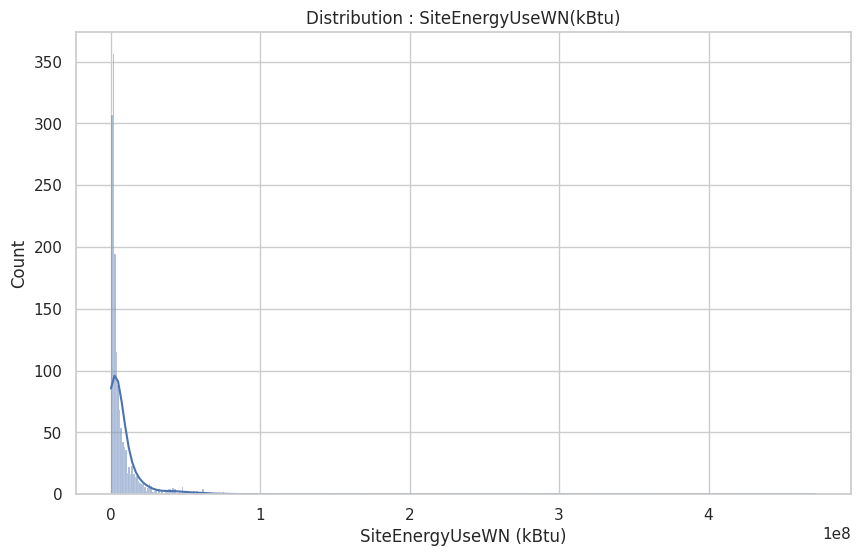

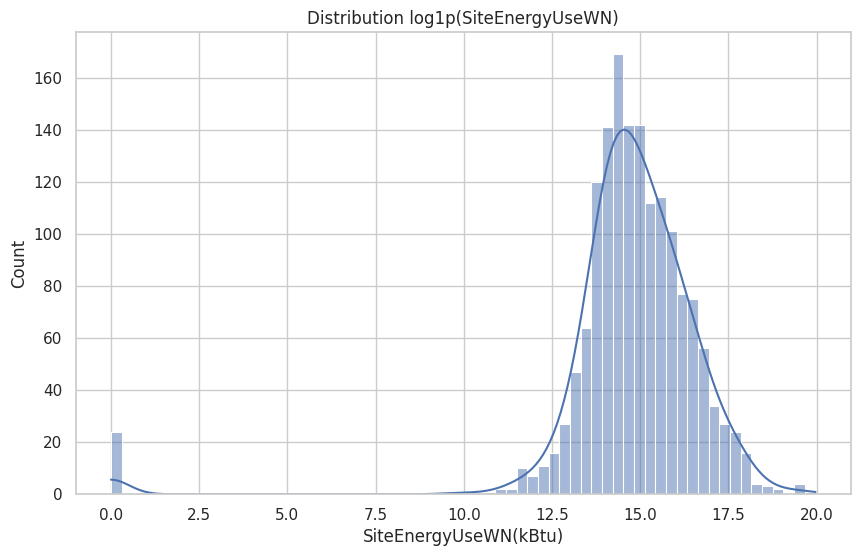

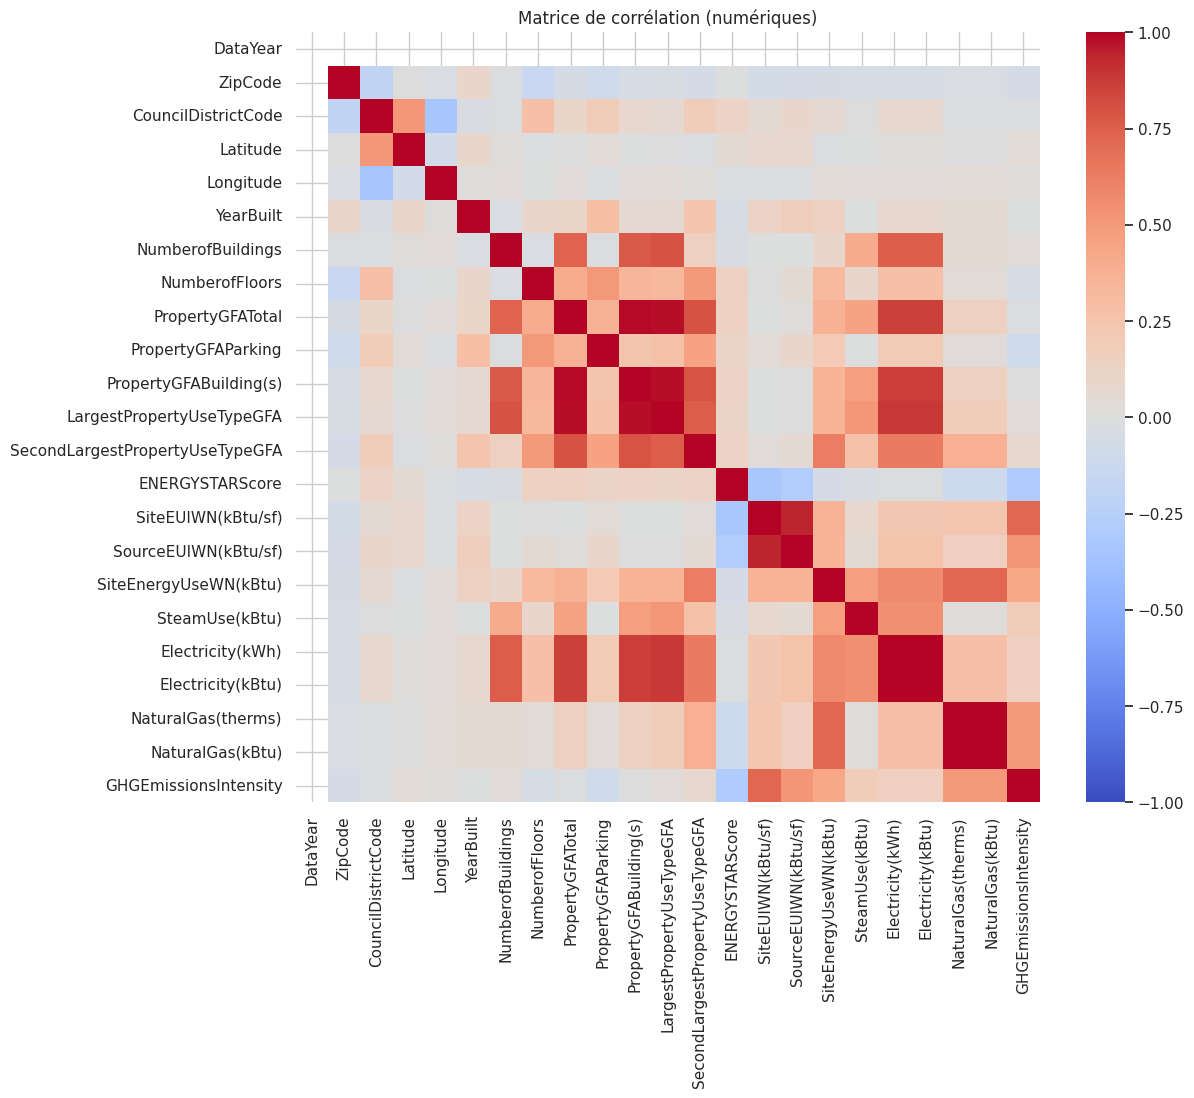

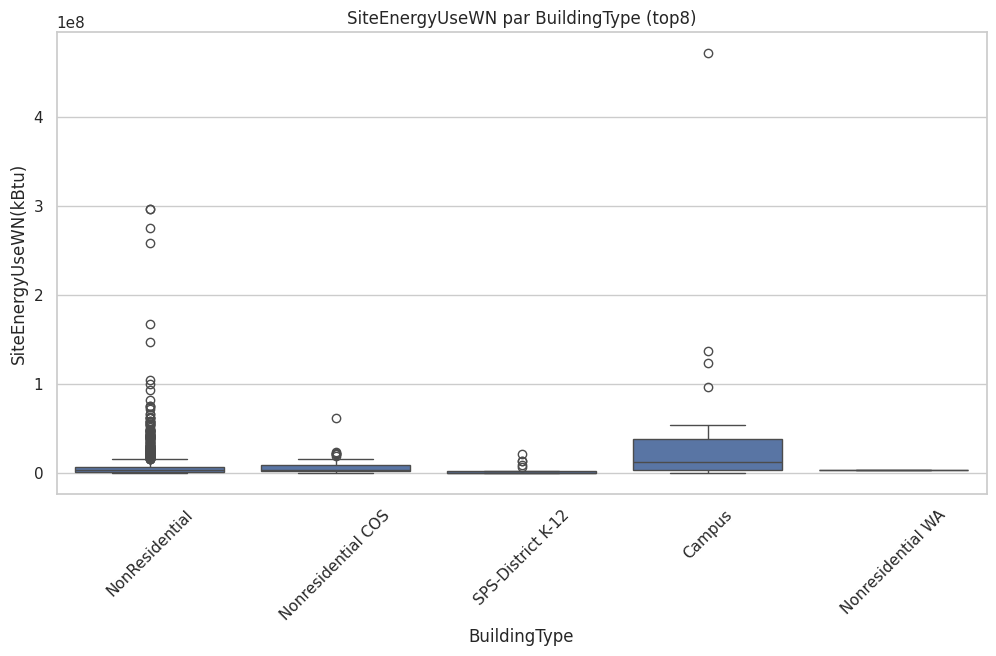

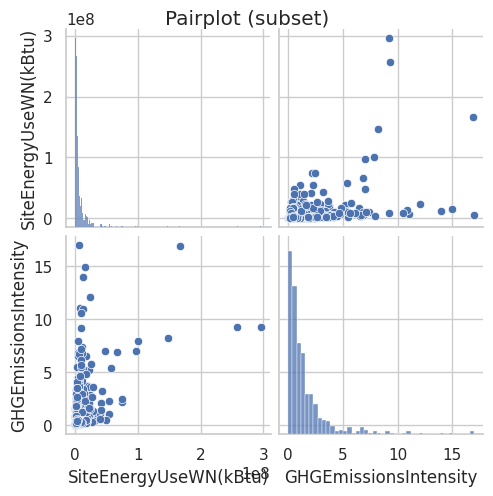

In [12]:

# ===========================================================
# Cellule 13 — visualisations
# ===========================================================


import matplotlib.ticker as ticker

# Histogramme target consommation
if 'SiteEnergyUseWN(kBtu)' in dfc.columns:
    plt.figure()
    sns.histplot(dfc['SiteEnergyUseWN(kBtu)'].dropna(), kde=True)
    plt.title('Distribution : SiteEnergyUseWN(kBtu)')
    plt.xlabel('SiteEnergyUseWN (kBtu)')
    plt.show()

    print("\n")

    plt.figure()
    sns.histplot(np.log1p(dfc['SiteEnergyUseWN(kBtu)'].dropna()), kde=True)
    plt.title('Distribution log1p(SiteEnergyUseWN)')
    plt.show()

print("\n")

# Heatmap corrélation (numériques)
if len(num_cols) >= 2:
    corr = dfc[num_cols].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matrice de corrélation (numériques)')
    plt.show()

print("\n")

# Boxplot par BuildingType (top 8)
if 'BuildingType' in dfc.columns and 'SiteEnergyUseWN(kBtu)' in dfc.columns:
    top_types = dfc['BuildingType'].value_counts().nlargest(8).index
    plt.figure(figsize=(12,6))
    sns.boxplot(x='BuildingType', y='SiteEnergyUseWN(kBtu)', data=dfc[dfc['BuildingType'].isin(top_types)])
    plt.xticks(rotation=45)
    plt.title('SiteEnergyUseWN par BuildingType (top8)')
    plt.show()

print("\n")

# Pairplot subset
pairs = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity', 'Building_age']
pairs = [p for p in pairs if p and p in dfc.columns]
if len(pairs) >= 2:
    sample = dfc[pairs].dropna().sample(min(500, len(dfc)))
    sns.pairplot(sample)
    plt.suptitle('Pairplot (subset)')
    plt.show()

print("\n")


## *14.* Détection et marquage des outliers énergétiques (IQR)

Cette cellule applique la **méthode de l’IQR (Interquartile Range)** pour détecter les **valeurs aberrantes (outliers)** sur la variable cible `SiteEnergyUseWN(kBtu)`.  
Elle permet de visualiser, quantifier et documenter les points extrêmes dans la distribution de la consommation énergétique.

---

### 🎯 Objectifs
- Identifier les bâtiments présentant une **consommation énergétique anormale**.
- Marquer ces valeurs dans une **nouvelle colonne booléenne** `outlier_iqr_energy`.
- Fournir un **diagnostic visuel** via un boxplot annoté des bornes IQR.
- Vérifier des **règles métiers simples** (valeurs négatives ou nulles sur la surface ou la consommation).

---

### 🧠 Méthodologie
- L’IQR est défini comme `Q3 - Q1` (écart interquartile).  
- Les outliers sont les points situés :
  - en dessous de `Q1 - 1.5 × IQR`
  - au-dessus de `Q3 + 1.5 × IQR`
- Cette approche est **non paramétrique** et robuste aux distributions asymétriques.

---

### 📊 Étapes principales
| Étape | Action | Détail |
|:--:|:--|:--|
| 1️⃣ | Calcul de l’IQR | Extraction des quantiles et bornes limites. |
| 2️⃣ | Visualisation | Boxplot annoté pour visualiser les outliers. |
| 3️⃣ | Marquage | Ajout de la colonne `outlier_iqr_energy` dans `dfc`. |
| 4️⃣ | Vérifications métiers | Suppression des lignes avec valeurs négatives ou nulles. |
| 5️⃣ | Résumé final | Affichage du nombre d’outliers et dimensions du dataset. |

---

### ⚙️ Paramètres ajustables
- `k=1.5` : seuil de sensibilité de l’IQR (augmenter pour réduire la détection).
- `plot=True` : active la visualisation (boxplot interactif).
- `verbose=True` : affiche les bornes et statistiques descriptives.

---

### 🧩 Interprétation
- Un **taux élevé d’outliers** peut révéler des erreurs de saisie ou des profils énergétiques atypiques.  
- Les outliers ne sont pas supprimés automatiquement : ils sont **signalés** pour examen ou traitement ultérieur.




📊 Résumé IQR (SiteEnergyUseWN(kBtu))
  - Q1 (25%)          : 1,270,514.75
  - Q3 (75%)          : 7,419,337.00
  - IQR               : 6,148,822.25
  - Borne inférieure  : -7,952,718.62
  - Borne supérieure  : 16,642,570.38
  - Valeur min réelle : 0.00
  - Valeur max réelle : 471,613,856.00




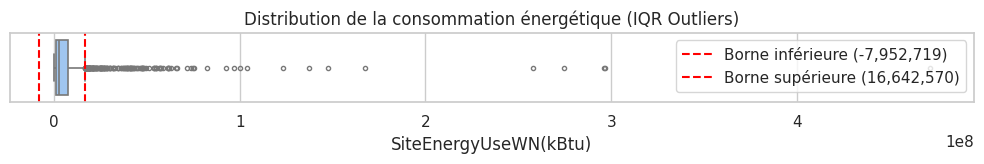


⚠️  Outliers énergie détectés (IQR) : 173 (10.97 % des données valides)

🧹 Règles métiers détectées (voir messages) :
- Lignes avec SiteEnergyUseWN(kBtu) <= 0 : 24
✅ Suppression appliquée pour valeurs <= 0 (surface/consommation).

📦 DataFrame final : 1553 lignes × 32 colonnes
🏷️  Colonne d’outliers ajoutée : 'outlier_iqr_energy'


In [13]:

# ===========================================================
# Cellule 14 — marquer les outliers par IQR sur la target consommation + visualisation
# ===========================================================

import matplotlib.pyplot as plt
import seaborn as sns

def iqr_outlier_mask(series, k=1.5, verbose=False, plot=False):
    """Retourne un masque booléen des outliers selon la méthode IQR.
       Si verbose=True, affiche les bornes et statistiques associées.
       Si plot=True, affiche un boxplot annoté des bornes IQR."""

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr

    if verbose:
        print("📊 Résumé IQR (SiteEnergyUseWN(kBtu))")
        print(f"  - Q1 (25%)          : {q1:,.2f}")
        print(f"  - Q3 (75%)          : {q3:,.2f}")
        print(f"  - IQR               : {iqr:,.2f}")
        print(f"  - Borne inférieure  : {lower:,.2f}")
        print(f"  - Borne supérieure  : {upper:,.2f}")
        print(f"  - Valeur min réelle : {series.min():,.2f}")
        print(f"  - Valeur max réelle : {series.max():,.2f}")

    print("\n")

    if plot:
        plt.figure(figsize=(10, 1.8))
        sns.boxplot(x=series, color="#93C5FD", fliersize=3, linewidth=1.2)
        plt.axvline(lower, color='red', linestyle='--', lw=1.5, label=f"Borne inférieure ({lower:,.0f})")
        plt.axvline(upper, color='red', linestyle='--', lw=1.5, label=f"Borne supérieure ({upper:,.0f})")
        plt.title("Distribution de la consommation énergétique (IQR Outliers)")
        plt.xlabel("SiteEnergyUseWN(kBtu)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return (series < lower) | (series > upper)

print("\n")

# --- Application sur la colonne cible ---
if 'SiteEnergyUseWN(kBtu)' in dfc.columns:
    target_col = 'SiteEnergyUseWN(kBtu)'
    series = dfc[target_col].dropna()
    mask_out = iqr_outlier_mask(series, k=1.5, verbose=True, plot=True)

    # Construire une série alignée sur le df complet
    out_series = pd.Series(False, index=dfc.index)
    out_series.loc[mask_out.index] = mask_out.values
    dfc['outlier_iqr_energy'] = out_series

    # Compter les outliers
    n_out = dfc['outlier_iqr_energy'].sum()
    pct_out = n_out / len(series) * 100
    print(f"\n⚠️  Outliers énergie détectés (IQR) : {n_out} ({pct_out:.2f} % des données valides)")

# ===========================================================
# Vérification de règles métiers simples
# ===========================================================

rules_msgs = []

n_bad_energy = (dfc['SiteEnergyUseWN(kBtu)'] <= 0).sum() if 'SiteEnergyUseWN(kBtu)' in dfc.columns else 0
if n_bad_energy > 0:
    rules_msgs.append(f"Lignes avec SiteEnergyUseWN(kBtu) <= 0 : {n_bad_energy}")

if rules_msgs:
    print("\n🧹 Règles métiers détectées (voir messages) :")
    for m in rules_msgs:
        print("-", m)
    # Suppression conservatrice
    if 'SiteEnergyUseWN(kBtu)' in dfc.columns:
        dfc = dfc[dfc['SiteEnergyUseWN(kBtu)'] > 0].copy()
    print("✅ Suppression appliquée pour valeurs <= 0 (surface/consommation).")

# Résumé final
print(f"\n📦 DataFrame final : {dfc.shape[0]} lignes × {dfc.shape[1]} colonnes")
print(f"🏷️  Colonne d’outliers ajoutée : 'outlier_iqr_energy'")


## *15.* Suivi du nettoyage et sauvegarde du DataFrame final

Cette cellule assure le **suivi global du nettoyage des données** et la **sauvegarde du jeu de données final** destiné à la modélisation.

## 📋 Étapes principales :
1. **Rechargement du jeu de données initial** :
   - Permet de comparer les dimensions (lignes / colonnes) avant et après nettoyage.

2. **Comparaison des dimensions avant/après** :
   - Affiche un résumé clair du nombre de lignes conservées.  
   - Calcule le pourcentage de lignes restantes après le nettoyage.

3. **Sauvegarde du DataFrame nettoyé (`dfc`)** :
   - Export du jeu de données propre dans le dossier `data/processed/` sous le nom :  
     `2016_cleaned_for_modeling_v02.csv`.

## 🎯 Objectif :
Fournir un **bilan synthétique du nettoyage** (effet des filtres, suppressions d’outliers, règles métiers, etc.)  
et **archiver la version finale du jeu de données** prête pour la modélisation (Étape 4 et suivantes).


In [14]:

# ===========================================================
# Cellule 15 — suivi des comptes et sauvegarde
# ===========================================================

df = pd.read_csv(CSV_PATH, low_memory=False)
# print(f"Chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# 🧮 Suivi du nettoyage : dimensions avant / après
initial_rows, initial_cols = df.shape
final_rows, final_cols = dfc.shape

# Calcul du pourcentage de lignes conservées
pct_kept = (final_rows / initial_rows) * 100 if initial_rows > 0 else 0

print("=== Résumé du nettoyage des données ===")
print(f"Dimensions initiales : {initial_rows} lignes × {initial_cols} colonnes")
print(f"Dimensions finales   : {final_rows} lignes × {final_cols} colonnes")
print(f"✅ Pourcentage de lignes conservées : {pct_kept:.2f}%")


# 💾 Sauvegarde du DataFrame nettoyé
processed_path = ROOT / 'data' / 'processed' / '2016_cleaned_for_modeling_v02.csv'
dfc.to_csv(processed_path, index=False)

print(f"\nFichier nettoyé sauvegardé : {processed_path}")


=== Résumé du nettoyage des données ===
Dimensions initiales : 3376 lignes × 46 colonnes
Dimensions finales   : 1553 lignes × 32 colonnes
✅ Pourcentage de lignes conservées : 46.00%

Fichier nettoyé sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_cleaned_for_modeling_v02.csv


## Résumé des opérations et décisions prises

1. **Chargement** du CSV local et sauvegarde d'une copie brute pour traçabilité.  
2. **Arborescence** du projet créée sous `/content/2016_Building_Energy_Benchmarking`.  
3. **Filtrage** : seuls les `buildingType` non résidentiels retenus (liste adaptative selon les labels présents).  
4. **Nettoyage** : suppression des lignes où `DefaultData==True`, `Outlier==True` et certains statuts `complianceStatus` indiquant l'absence de relevé. Ces colonnes ont été supprimées ensuite.  
5. **Doublons** supprimés. Colonnes à >70% de NA listées pour décision ultérieure.  
6. **Targets retenues** : `SiteEnergyUseWN(kBtu)` (consommation) et `GHGEmissionsIntensity` (émissions).  
7. **Transformations** : création de `building_age`, détection d'outliers IQR et create `energy_per_area`.  
8. **Visualisations** produites : distributions, heatmap corrélation, boxplots, scatter plots, pairplots.  
9. **Export** : jeu nettoyé enregistré dans `data/processed/2016_cleaned_for_modeling_v02.csv`.


---


## Ma démarche & logique pour cette Étape 1
1. **Comprendre le contexte métier** : je lis l'énoncé et je me concentre exclusivement sur les bâtiments non résidentiels comme demandé.  
2. **Chargement & backup** : je sauvegarde une copie brute pour revenir en arrière si une décision de nettoyage se révèle erronée.  
3. **Filtrer tôt mais prudemment** : retirer les catégories non pertinentes (résidentiel) pour éviter de biaiser les patterns.  
4. **Nettoyage guidé par la source** : si la source marque une ligne `DefaultData` ou `Outlier`, c'est un signal fort — je les retire mais j’archive toujours.  
5. **Ne pas supprimer aveuglément les NA** : l'imputation est préférable à l'élimination lorsque cela préserve la taille d'entraînement.   
6. **Visualiser avant de décider** : histogrammes, boxplots et corrélations guident les décisions sur transformations (log), segmentation et règles d'exclusion.  
7. **Traçabilité** : chaque suppression est comptée et documentée pour la transparence avec le Project Lead.

---


## 7 questions qu’on pourrait me poser sur mes choix et comment y répondre

1. **Q : Pourquoi avez-vous choisi `SiteEnergyUseWN(kBtu)` comme target et pas une autre colonne d'énergie ?**  
   R : J'ai choisi `SiteEnergyUseWN(kBtu)` car il s'agit d'une consommation **weather-normalized** — cela réduit la variance liée aux conditions météo et rend les comparaisons entre bâtiments plus justes. D'autres colonnes peuvent exister, mais elles sont souvent redondantes ou non-normalisées.

2. **Q : Pourquoi supprimer les lignes `DefaultData == True` ?**  
   R : Ces lignes contiennent des valeurs **estimées** ou auto-remplies, pas des mesures fiables ; les inclure biaiserait l'apprentissage. J'archive cependant ces lignes pour analyse postérieure.

3. **Q : N'est-il pas risqué de supprimer les outliers signalés par la source ?**  
   R : C'est une décision conservatrice — je les retire pour l'entraînement principal afin d'éviter d'apprendre des erreurs ou données corrompues. Je propose de conserver un fichier de quarantaine pour réexamen s'il faille les traiter différemment.

4. **Q : Pourquoi ne pas supprimer toutes les colonnes à NA ?**  
   R : Supprimer toutes les colonnes contenant des NA peut laisser trop peu de données pour modéliser. Je liste d'abord les colonnes à >70% NA comme candidates à suppression et je propose une discussion pour décider.

5. **Q : Avez-vous envisagé une segmentation par type de bâtiment ?**  
   R : Oui — c'est prévu. Si les comportements énergétiques diffèrent fortement par usage (ex. hôpitaux vs bureaux), je recommanderai des modèles par segment ou features d'interaction.

6. **Q : Comment gérez-vous l'échelle des variables (ex. surfaces très grandes) ?**  
   R : Pour les modèles sensibles à l'échelle (régression linéaire, réseaux), j’appliquerai des scalers (StandardScaler / RobustScaler). Pour les arbres/boosting, le scaling est moins crucial. J’ai aussi testé un log-transform pour la target.

7. **Q : Quelles métriques utiliserez-vous ensuite pour évaluer les modèles ?**  
   R : Principalement RMSE, MAE et R². Je regarderai aussi des métriques relatives (MAPE/SMAPE) et l'erreur par segment (usage/quartile de consommation) pour comprendre où le modèle performe ou échoue.

---




## ✅ Conclusion synthétique

J'ai réalisé une analyse exploratoire structurée et reproductible en respectant vos consignes : filtration sur les bâtiments non résidentiels, nettoyage via `complianceStatus`/`DefaultData`/`Outlier`, choix des targets (`SiteEnergyUseWN(kBtu)`, `GHGEmissionsIntensity`), transformations initiales (âge, consommation/m²), détection d'outliers et sauvegarde d'un jeu prêt pour l'étape suivante.

Prochaines étapes proposées (Étape 2) :  
- finaliser les décisions sur colonnes fortement manquantes (>70%),  
- définir les stratégies d'imputation (par usage/quartier ou modèles),  
- créer features avancées (interaction, features spatiales),  
- préparer pipeline de preprocessing (scikit-learn) et préparer tests unitaires pour le preprocessing.

---
---




# 🧭 Étape 2 — Feature Engineering
**Projet 3 : Anticipez les besoins en consommation des bâtiments (Seattle 2016)**  

**✍️ Auteur :** *[Raymond Francius]*  
**📚 Rôle :** *[Apprenant - Promotion Sept-2025]* — **Engineering Intelligence Artificielle (AI)** — **Openclassrooms**   
🗓️ **Date de mise à jour :** *[26-10-2025]*

---
**But de ce notebook :** enrichir le jeu de données produit à l’Étape 1, sans introduire de *data leakage*, et produire un fichier prêt pour la modélisation + visualisations sauvegardées.

**Fichiers attendus / produits :**
- Entrée attendue : `/content/2016_Building_Energy_Benchmarking/data/processed/2016_cleaned_for_modeling_v02.csv`
- Sortie principale : `/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv`
- Graphiques et résumés sauvegardés dans le dossier ci-dessus.

> Mode d'emploi : exécutez les cellules dans l'ordre. Si le fichier d'entrée est manquant, la cellule dédiée vous proposera d'uploader le fichier depuis votre PC.



## *1.* Imports et paramètres globaux

Cette première cellule prépare l’environnement de travail et définit les **paramètres généraux** utilisés dans l’étape de préparation des données.

---

### 📋 Objectifs :
1. **Importer les bibliothèques principales** :
   - `os`, `shutil` : gestion des chemins et fichiers.  
   - `datetime` : manipulation des dates pour le calcul de l’âge des bâtiments.  
   - `numpy`, `pandas` : manipulation et analyse des données.  
   - `matplotlib`, `seaborn` : visualisation des distributions et corrélations.  
   - `google.colab.files` : support pour les environnements Colab (upload manuel si besoin).

2. **Définir les chemins de fichiers essentiels** :
   - `TARGET_DIR` : dossier principal contenant les données traitées.  
   - `INPUT_FILENAME` : fichier CSV nettoyé (issu de l’étape précédente).  
   - `TARGET_FILE` : chemin complet vers le fichier d’entrée attendu.  
   - `LOCAL_COPY` : copie alternative du fichier (pour exécution locale).  
   - `OUTPUT_FILE` : nom du fichier de sortie contenant les **features enrichies**.

3. **Créer le dossier cible si nécessaire** :
   - La commande `os.makedirs(..., exist_ok=True)` assure la création sécurisée du répertoire.

---

### 🎯 Résultat attendu :
Affichage des chemins configurés pour vérifier que les fichiers sont bien détectés ou créés avant les prochaines étapes (chargement et enrichissement des données).


In [15]:

# ==================================================
# Cellule 1 — Imports et paramètres globaux
# ==================================================


# Import des bibliothèques nécessaires
import os                            # gestion des chemins
import shutil                        # copie de fichiers
from datetime import datetime       # date/heure courante pour calc âge bâtiment
import numpy as np                  # calculs numériques
import pandas as pd                 # manipulation des données
import matplotlib.pyplot as plt     # visualisations
import seaborn as sns               # visualisation corrélations
from google.colab import files      # utilitaire Colab pour upload si nécessaire

# Paramètres / chemins
TARGET_DIR = "/content/2016_Building_Energy_Benchmarking/data/processed"  # dossier cible
INPUT_FILENAME = "2016_cleaned_for_modeling_v02.csv"                         # nom attendu
TARGET_FILE = os.path.join(TARGET_DIR, INPUT_FILENAME)                   # chemin complet attendu
LOCAL_COPY = "/mnt/data/2016_cleaned_for_modeling_v02.csv"                   # copie locale possible (fournie)
OUTPUT_FILE = os.path.join(TARGET_DIR, "2016_features_engineered_for_modeling.csv")  # fichier de sortie

# Création du dossier si absent (sécurisé)
os.makedirs(TARGET_DIR, exist_ok=True)

# Affichage info
print("Fichier attendu :", TARGET_FILE)
print("Copie locale possible :", LOCAL_COPY)
print("Fichier de sortie prévu :", OUTPUT_FILE)


Fichier attendu : /content/2016_Building_Energy_Benchmarking/data/processed/2016_cleaned_for_modeling_v02.csv
Copie locale possible : /mnt/data/2016_cleaned_for_modeling_v02.csv
Fichier de sortie prévu : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv


## *2.* Vérification / Copie / Upload du fichier si nécessaire

Cette cellule garantit la **présence du fichier d’entrée** (`2016_cleaned_for_modeling_v02.csv`) dans le répertoire de travail défini (`TARGET_FILE`).

---

### ⚙️ Étapes réalisées :

1. **Vérification de la présence du fichier principal** :
   - Si `TARGET_FILE` existe → affichage d’un message de confirmation ✅.  

2. **Copie automatique depuis une source locale** :
   - Si le fichier n’est pas trouvé mais qu’une **copie locale** (`LOCAL_COPY`) existe, celle-ci est copiée automatiquement dans le dossier cible.  
   - Un message d’avertissement ⚠️ signale cette opération de secours.

3. **Upload manuel (environnement Google Colab)** :
   - Si ni `TARGET_FILE` ni `LOCAL_COPY` ne sont présents, un **dialogue d’upload** s’ouvre pour permettre à l’utilisateur de téléverser le fichier manuellement depuis son ordinateur.
   - Le code gère :
     - le **cas nominal** (fichier au bon nom) ;
     - le **cas alternatif** où le fichier uploadé porte un autre nom → renommage automatique.

4. **Gestion des erreurs** :
   - Si aucune source valide n’est trouvée (ni locale ni uploadée), une exception `FileNotFoundError` est levée avec une explication claire.

---

### 🎯 Résultat attendu :
À la fin de cette cellule, le fichier `2016_cleaned_for_modeling_v02.csv` est **garanti présent et prêt à être chargé** pour la phase suivante d’ingénierie de features.



In [16]:

# ==================================================
# Cellule 2 — Vérification / copie / upload si nécessaire
# ==================================================


# Vérifier la présence du fichier dans TARGET_FILE
if os.path.exists(TARGET_FILE):
    print("✅ Fichier trouvé à TARGET_FILE.")
else:
    # si fichier existant dans /mnt/data/, on copie automatiquement
    if os.path.exists(LOCAL_COPY):
        print("⚠️ TARGET_FILE introuvable — copie depuis LOCAL_COPY détectée.")
        shutil.copy(LOCAL_COPY, TARGET_FILE)   # copie physique
        print("📋 Copie effectuée vers TARGET_FILE.")
    else:
        # Si pas trouvé, demander upload depuis l'ordinateur local (Colab)
        print("❗ Fichier introuvable. Veuillez uploader le fichier CSV depuis votre PC.")
        print("Utilisez la fenêtre de sélection de fichiers qui va apparaître.")
        uploaded = files.upload()  # ouvre un dialogue d'upload dans Colab
        # uploaded est un dict {filename: content}
        if INPUT_FILENAME in uploaded:
            # Sauvegarde vers TARGET_FILE
            with open(TARGET_FILE, "wb") as f:
                f.write(uploaded[INPUT_FILENAME])
            print("📥 Fichier uploadé et sauvegardé dans TARGET_FILE.")
        else:
            # Si l'utilisateur a uploadé un fichier avec un nom différent, on essaie de le renommer
            uploaded_keys = list(uploaded.keys())
            if len(uploaded_keys) > 0:
                first = uploaded_keys[0]
                print(f"⚠️ Fichier uploadé: '{first}'. Je le renomme en '{INPUT_FILENAME}'.")
                os.rename(first, TARGET_FILE)
                print("✅ Fichier renommé et placé dans TARGET_FILE.")
            else:
                raise FileNotFoundError(
                    f"Aucun fichier uploadé et {LOCAL_COPY} absent. "
                    f"Veuillez déposer `{INPUT_FILENAME}` dans `/mnt/data/` ou uploader manuellement."
                )


✅ Fichier trouvé à TARGET_FILE.


## *3.* Chargement et aperçu initial du jeu de données

Cette cellule assure le **chargement du jeu de données nettoyé** depuis le fichier CSV vérifié dans la Cellule 2, puis effectue une **analyse exploratoire rapide** pour en contrôler la cohérence avant toute transformation.

---

### ⚙️ Étapes réalisées :

1. **Chargement du fichier CSV**  
   - Lecture du fichier `TARGET_FILE` avec `pandas.read_csv()`  
   - L’option `low_memory=False` évite les avertissements dus aux types de colonnes mixtes.

2. **Aperçu général du dataset**  
   - Affichage des dimensions du DataFrame (`shape`)  
   - Visualisation des **5 premières lignes** pour vérifier la structure et le format des colonnes.

3. **Analyse rapide des types et valeurs manquantes**  
   - Comptage des types de colonnes (`df.dtypes.value_counts()`)  
   - Classement des 20 colonnes présentant le plus de valeurs manquantes (`df.isna().sum()` trié par ordre décroissant).

4. **Sauvegarde d’un échantillon pour audit**  
   - Les 50 premières lignes du dataset sont exportées au format CSV (`2016_preview_head50.csv`) dans le dossier `data/processed/`.  
   - Ce fichier sert de **snapshot rapide** pour inspection externe ou contrôle qualité.

---

### 🎯 Objectif :
Valider que le fichier de données chargé est **lisible, complet et cohérent** avant de procéder à toute étape d’ingénierie de variables.


In [17]:

# ==================================================
# Cellule 3 — Chargement et aperçu initial
# ==================================================


# Chargement du CSV en DataFrame pandas
df = pd.read_csv(TARGET_FILE, low_memory=False)  # low_memory=False pour éviter warnings sur types mixtes

# Taille et aperçu
print("Taille du DataFrame (lignes, colonnes) :", df.shape)  # affiche shape
display(df.head(5))                                        # affiche les 5 premières lignes

# Types et missing values : résumé
print("\n--- Types des colonnes ---")
display(df.dtypes.value_counts())                          # compte par type
print("\n--- Top 20 colonnes par valeurs manquantes ---")
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(20))                                  # affiche top 20 colonnes manquantes

# Sauvegarde rapide du head pour audit
df.head(50).to_csv(os.path.join(TARGET_DIR, "2016_preview_head50.csv"), index=False)
print("\nPreview sauvegardé :", os.path.join(TARGET_DIR, "2016_preview_head50.csv"))


Taille du DataFrame (lignes, colonnes) : (1553, 32)


,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,GHGEmissionsIntensity,BuildingType_clean,is_residential,outlier_iqr_energy
0,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.612,-122.338,1927,1.000,12,88434,0,88434,Hotel,88434.000,NaN,NaN,60.000,84.300,189.000,7456910.000,2003882.000,1156514.250,3946027.000,12764.529,1276453.000,Compliant,2.830,nonresidential,False,False
1,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.613,-122.334,1996,1.000,11,103566,15064,88502,Hotel,83880.000,Parking,15064.000,61.000,97.900,179.400,8664479.000,0.000,950425.188,3242851.000,51450.816,5145082.000,Compliant,2.860,nonresidential,False,False
2,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.614,-122.338,1969,1.000,41,956110,196718,759392,Hotel,756493.000,NaN,NaN,43.000,97.700,244.100,73937112.000,21566554.000,14515435.000,49526664.000,14938.000,1493800.000,Compliant,2.190,nonresidential,False,True
3,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.614,-122.337,1926,1.000,10,61320,0,61320,Hotel,61320.000,NaN,NaN,56.000,113.300,224.000,6946800.500,2214446.250,811525.312,2768924.000,18112.131,1811213.000,Compliant,4.670,nonresidential,False,False
4,2016,NonResidential,Hotel,98121.000,7,DOWNTOWN,47.614,-122.340,1980,1.000,18,175580,62000,113580,Hotel,123445.000,Parking,68009.000,75.000,118.700,215.600,14656503.000,0.000,1573448.625,5368607.000,88039.984,8803998.000,Compliant,2.880,nonresidential,False,False



--- Types des colonnes ---


,count
float64,16
int64,7
object,7
bool,2



--- Top 20 colonnes par valeurs manquantes ---


,0
SecondLargestPropertyUseTypeGFA,709
SecondLargestPropertyUseType,709
ENERGYSTARScore,554
ZipCode,13
LargestPropertyUseTypeGFA,4
LargestPropertyUseType,4
CouncilDistrictCode,0
DataYear,0
Longitude,0
Latitude,0



Preview sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_preview_head50.csv


## *4.* Fonctions utilitaires (commentées)

Cette cellule regroupe un ensemble de **fonctions utilitaires réutilisables** destinées à faciliter le traitement, la transformation et la création de variables dérivées dans les étapes suivantes du pipeline d’ingénierie de features.

---

### ⚙️ Fonctions définies

#### 1. `safe_div(a, b)`
Effectue une **division sécurisée** :
- Évite les erreurs de division par zéro ou sur valeurs manquantes (`ZeroDivisionError`, `NaN`).
- Retourne `NaN` si le diviseur est nul ou invalide.

#### 2. `make_age(year_built)`
Calcule **l’âge d’un bâtiment** à partir de son année de construction :
- Utilise l’année courante (`datetime.now().year`).
- Gère les valeurs manquantes et les erreurs de conversion en entier.
- Retourne `NaN` si la donnée d’origine est absente ou invalide.

#### 3. `make_flag_from_text(val, keywords)`
Crée un **indicateur binaire (flag)** à partir d’un texte :
- Retourne `1` si la chaîne contient au moins un mot-clé parmi la liste fournie.
- Retourne `0` sinon ou si la valeur est manquante.
- Utile pour créer des variables booléennes à partir de libellés ou de descriptions textuelles.

---

### 🎯 Objectif :
Centraliser ces petites fonctions pour **fiabiliser les calculs et éviter les erreurs répétitives** dans les transformations de données à venir.


In [18]:

# ==================================================
# Cellule 4 — Fonctions utilitaires (commentées)
# ==================================================


# Date courante pour calcul d'âge
CURRENT_YEAR = datetime.now().year

# safe_div : division sûre (évite ZeroDivisionError)
def safe_div(a, b):
    try:
        # si b est nul / None / NaN, on retourne NaN
        if b in (0, None) or (isinstance(b, float) and np.isnan(b)):
            return np.nan
        return a / b
    except Exception:
        return np.nan

# make_age : calcul d'age à partir d'une année de construction
def make_age(year_built):
    try:
        # si valeur manquante, retourner NaN
        if pd.isna(year_built):
            return np.nan
        # cast en int et calcul différence
        return CURRENT_YEAR - int(year_built)
    except Exception:
        return np.nan

# make_flag_from_text : crée un flag si un texte contient l'un des mots-clés donnés
def make_flag_from_text(val, keywords):
    if pd.isna(val):
        return 0
    s = str(val).lower()
    # retourne 1 si l'un des mots-clés est présent dans la chaîne
    return 1 if any(k in s for k in keywords) else 0


## *5.* Création : `age_building` + `age_bucket` (avec protection anti-leakage)

Cette cellule introduit deux nouvelles variables dérivées de l’année de construction des bâtiments, tout en **prévenant toute fuite de données ("data leakage")** en s’assurant qu’aucune variable cible n’est utilisée pour les inférences.

---

### 🎯 Objectifs

- **Créer une feature continue `age_building`** :  
  représente l’âge du bâtiment (ref_year – `YearBuilt`).

- **Créer une feature catégorielle `age_bucket`** :  
  découpe l’âge en tranches utiles pour la modélisation :
  - `new_<=20y` → bâtiments récents  
  - `mid_21-60y` → bâtiments intermédiaires  
  - `old_>60y` → bâtiments anciens

- **Appliquer une protection anti-leakage** :  
  les colonnes cibles (`SiteEnergyUseWN(kBtu)` et `GHGEmissionsIntensity`) sont explicitement exclues avant toute transformation.

---

### 🧠 Points importants
- Les valeurs aberrantes (`YearBuilt` < 1800 ou > 2025) sont exclues.  
- Si la colonne `YearBuilt` est absente, aucune variable dérivée n’est créée.  
- L’ensemble des nouvelles variables est visualisé en fin de cellule pour vérification rapide.

---

### 📦 Résultat attendu
Deux nouvelles colonnes ajoutées au DataFrame :
- `age_building`
- `age_bucket`


In [19]:

# ==================================================
# Cellule 5 — Création et analyse : age_building + age_bucket (ref_year=2016)
# Objectif :
# - Créer/Mettre à jour les features dérivées de 'YearBuilt'
# - Supprimer 'YearBuilt' (pour éviter redondance et colinéarité)
# - Éviter toute fuite de données (data leakage)
# - Afficher les statistiques descriptives et corrélations avec les cibles
# ==================================================

import pandas as pd
import numpy as np

# --- Paramètres globaux ---
ref_year = 2016
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- Fonction de calcul de l'âge ---
def make_age(year_built, ref_year=2016):
    """Retourne l'âge du bâtiment (année de référence - YearBuilt)"""
    if pd.isna(year_built) or year_built < 1800 or year_built > ref_year:
        return np.nan
    return ref_year - year_built

# --- Vérification de la présence de YearBuilt ---
if 'YearBuilt' not in df.columns:
    raise ValueError("⚠️ La colonne 'YearBuilt' est absente du DataFrame.")

# --- Copie sans colonnes cibles (protection anti-leakage) ---
df_temp = df.drop(columns=[c for c in target_cols if c in df.columns], errors='ignore')

# --- Création des features ---
df['age_building'] = df['YearBuilt'].apply(lambda x: make_age(x, ref_year))

df['age_bucket'] = pd.cut(
    df['age_building'],
    bins=[-1, 20, 60, 1000],
    labels=['new_<=20y', 'mid_21-60y', 'old_>60y']
)

print("✅ Features 'age_building' et 'age_bucket' créées avec ref_year =", ref_year)

# ==================================================
# ❌ Suppression de YearBuilt (pour éviter redondance)
# ==================================================
if 'YearBuilt' in df.columns:
    df.drop(columns=['YearBuilt'], inplace=True)
    print("🗑️ Colonne 'YearBuilt' supprimée pour éviter la redondance.")

# ==================================================
# 📊 Analyse descriptive
# ==================================================
print("\n--- Statistiques de base ---")
print(f"Nombre total de lignes : {len(df)}")
print(f"Valeurs manquantes 'age_building' : {df['age_building'].isna().sum()}")
print("\nDistribution des buckets :")
print(df['age_bucket'].value_counts(dropna=False))

# ==================================================
# 🔗 Corrélations avec les cibles
# ==================================================
def safe_corr(col1, col2):
    """Calcule la corrélation Pearson et Spearman de manière sécurisée"""
    s1 = df[col1]
    s2 = df[col2]
    valid = s1.notna() & s2.notna()
    if valid.sum() == 0:
        return (np.nan, np.nan, 0)
    pearson = s1[valid].corr(s2[valid], method='pearson')
    spearman = s1[valid].corr(s2[valid], method='spearman')
    return (pearson, spearman, valid.sum())

print("\n--- Corrélations de age_building avec les cibles ---")
for tgt in target_cols:
    if tgt in df.columns:
        p, s, n = safe_corr('age_building', tgt)
        print(f"{tgt}: Pearson={p:.4f}, Spearman={s:.4f}, n={n}")
    else:
        print(f"{tgt}: (colonne absente)")

# ==================================================
# 📈 Moyennes et médianes des cibles par tranche d'âge
# ==================================================
print("\n--- Moyennes et médianes des cibles par age_bucket ---")
for tgt in target_cols:
    if tgt in df.columns:
        stats = df.groupby('age_bucket')[tgt].agg(['mean', 'median', 'count']).round(3)
        print(f"\n{tgt}:")
        display(stats)
    else:
        print(f"\n{tgt}: (colonne absente)")

# ==================================================
# 💾 (Optionnel) Sauvegarde du dataset modifié
# ==================================================
# output_path = "/content/2016_Building_Energy_Benchmarking_modified.csv"
# df.to_csv(output_path, index=False)
# print(f"\n💾 Dataset sauvegardé dans : {output_path}")


✅ Features 'age_building' et 'age_bucket' créées avec ref_year = 2016
🗑️ Colonne 'YearBuilt' supprimée pour éviter la redondance.

--- Statistiques de base ---
Nombre total de lignes : 1553
Valeurs manquantes 'age_building' : 0

Distribution des buckets :
age_bucket
mid_21-60y    648
old_>60y      599
new_<=20y     306
Name: count, dtype: int64

--- Corrélations de age_building avec les cibles ---
SiteEnergyUseWN(kBtu): Pearson=-0.1383, Spearman=-0.2811, n=1553
GHGEmissionsIntensity: Pearson=-0.0011, Spearman=0.0324, n=1553

--- Moyennes et médianes des cibles par age_bucket ---

SiteEnergyUseWN(kBtu):


,mean,median,count
age_bucket,,,
new_<=20y,12989734.640,6842545.000,306
mid_21-60y,8940583.490,2788273.875,648
old_>60y,5631963.304,2061027.625,599



GHGEmissionsIntensity:


,mean,median,count
age_bucket,,,
new_<=20y,1.554,0.770,306
mid_21-60y,1.742,0.880,648
old_>60y,1.622,0.940,599


## *7.* Création de `floor_area_bucket` (segmentation par quantiles)

Cette cellule crée une **variable catégorielle dérivée** de la surface totale du bâtiment (`PropertyGFATotal`) afin de segmenter les bâtiments selon leur taille, en quatre classes :  
`small`, `medium`, `large` et `xlarge`.

---

### 🎯 Objectifs

- **Discrétiser la surface totale (`PropertyGFATotal`)** en quartiles (via `pd.qcut`),  
  pour faciliter la comparaison entre groupes de bâtiments de tailles similaires.  
- **Assurer une protection anti-leakage**, en supprimant toute colonne cible (`SiteEnergyUseWN(kBtu)`, `GHGEmissionsIntensity`) avant le calcul.  
- **Vérifier la qualité des données** : exclusion des valeurs nulles, nulles ou négatives avant le bucketing.  
- **Gérer les doublons de quantiles** avec `duplicates='drop'` pour éviter les erreurs lorsque certaines valeurs sont identiques.

---

### 🧠 Points clés

- Si la colonne `PropertyGFATotal` est absente, la création est ignorée.  
- Si le nombre de valeurs valides est inférieur à 10, aucun bucket n’est créé.  
- En sortie, un aperçu et une distribution des catégories générées sont affichés.

---

### 📦 Résultat attendu

Une nouvelle colonne ajoutée au DataFrame :  
- `floor_area_bucket` → catégorisation de la surface totale en 4 groupes (`small`, `medium`, `large`, `xlarge`)

L’objectif est d’introduire une variable qualitative utile pour les modèles ne capturant pas naturellement les non-linéarités, comme les régressions linéaires simples.


In [20]:

# ==================================================
# Cellule 7 — Création de 'floor_area_bucket' (qcut sur quantiles)
# Objectif :
# - Créer des tranches ("buckets") de surface totale selon les quartiles
# - Vérifier la présence de la colonne concernée
# - Éviter tout risque de data leakage avec les cibles
# ==================================================


import pandas as pd
import numpy as np

# --- Définition des colonnes à protéger (targets à ne jamais utiliser dans la feature engineering) ---
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- Correspondance automatique avec les colonnes du dataset ---
floor_area_col = 'PropertyGFATotal'  # équivalent de floor_area

# --- Étape 1 : Vérification de la colonne source ---
if floor_area_col in df.columns:

    # --- Étape 2 : Protection anti-leakage ---
    # On crée une copie de travail sans les cibles pour garantir qu’aucune corrélation n’est exploitée indirectement
    df_temp = df.copy()
    for col in target_cols:
        if col in df_temp.columns:
            df_temp = df_temp.drop(columns=col)

    # --- Étape 3 : Nettoyage et préparation des données ---
    # Suppression des valeurs négatives ou nulles incohérentes
    valid_floor_area = df_temp[floor_area_col].copy()
    valid_floor_area = valid_floor_area.apply(lambda x: np.nan if pd.isna(x) or x <= 0 else x)

    # Vérification du nombre de valeurs valides avant bucketing
    n_valid = valid_floor_area.notna().sum()
    if n_valid < 10:
        print(f"⚠️ Trop peu de valeurs valides pour créer des quantiles ({n_valid} valides).")
    else:
        try:
            # --- Étape 4 : Création du bucketing via pd.qcut ---
            # Utilisation de duplicates='drop' pour éviter les erreurs si les quantiles sont identiques
            df['floor_area_bucket'] = pd.qcut(
                valid_floor_area,
                q=4,
                labels=['small', 'medium', 'large', 'xlarge'],
                duplicates='drop'
            )

            print(f"✅ 'floor_area_bucket' créé à partir de '{floor_area_col}' (quartiles).")

            # --- Étape 5 : Vérification et résumé ---
            print("\n📊 Distribution des catégories de 'floor_area_bucket' :")
            print(df['floor_area_bucket'].value_counts(dropna=False).sort_index())
            display(df[[floor_area_col, 'floor_area_bucket']].head())

        except Exception as e:
            print(f"⚠️ Erreur lors de la création de 'floor_area_bucket' : {e}")

else:
    print(f"⚠️ '{floor_area_col}' absent — 'floor_area_bucket' non créé.")


✅ 'floor_area_bucket' créé à partir de 'PropertyGFATotal' (quartiles).

📊 Distribution des catégories de 'floor_area_bucket' :
floor_area_bucket
small     389
medium    388
large     388
xlarge    388
Name: count, dtype: int64


,PropertyGFATotal,floor_area_bucket
0,88434,large
1,103566,large
2,956110,xlarge
3,61320,large
4,175580,xlarge


## *8.* — Encodage du type d’usage du bâtiment : top-K + 'other' (One-Hot)

Cette cellule s’occupe d’**encoder la variable catégorielle d’usage principal du bâtiment**
(`primary_use` ou `PrimaryPropertyType`) afin de rendre l’information exploitable par
les modèles de machine learning.

---

### 🎯 Objectifs

- **Identifier automatiquement la colonne d’usage principale** :  
  recherche de `primary_use` ou `PrimaryPropertyType`.  
- **Protéger contre le data leakage** :  
  suppression des colonnes cibles (`SiteEnergyUseWN(kBtu)`, `GHGEmissionsIntensity`)
  avant toute opération.  
- **Créer des variables binaires (`use_is_...`)** pour les *K* usages les plus fréquents.  
- **Regrouper les autres catégories** dans une classe `other`.  
- **Créer une version simplifiée one-hot** basée sur les 5 usages les plus représentés.  

---

### ⚙️ Détails techniques

- `topk = 10` : conserve les 10 catégories principales sous forme de drapeaux binaires.  
- `top5` : version compacte pour le one-hot encoding via `pd.get_dummies()`.  
- Les noms de colonnes sont nettoyés (`espace`, `/`, `-` → `_`) pour éviter les conflits.  
- Les nouvelles colonnes suivent une nomenclature claire :
  - `use_is_<catégorie>` : indicateur binaire top-K.  
  - `pu_<catégorie>` : version one-hot du top-5.  

---

### 📦 Résultat attendu

Ajout des nouvelles colonnes au DataFrame :
- `use_is_<...>` → indicateurs binaires top-K  
- `use_is_other` → flag pour les catégories restantes  
- `pu_<...>` → version one-hot top-5  
- `primary_use_top5` → version catégorielle simplifiée

Cette étape enrichit la représentation des bâtiments selon leur usage, une variable clé
pour expliquer la consommation énergétique et les émissions associées.


In [21]:

# ==================================================
# Cellule 8 — Encodage du type d’usage du bâtiment : top-K + 'other' (One-Hot)
# Objectif :
# - Identifier automatiquement la colonne d’usage principale
# - Encoder les usages les plus fréquents en variables binaires
# - Créer une version simplifiée one-hot (top 5 catégories)
# - Éviter tout data leakage en excluant les colonnes cibles du traitement
# ==================================================


import pandas as pd

# --- 1️⃣ Définition des cibles à protéger (jamais utilisées pour l'encodage) ---
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- 2️⃣ Détection automatique de la colonne d’usage principale ---
use_col = None
if 'primary_use' in df.columns:
    use_col = 'primary_use'
elif 'PrimaryPropertyType' in df.columns:
    use_col = 'PrimaryPropertyType'
    print("ℹ️ 'primary_use' absent — utilisation de 'PrimaryPropertyType' comme équivalent.")
else:
    print("⚠️ Aucune colonne d’usage trouvée ('primary_use' ni 'PrimaryPropertyType'). Encodage non réalisé.")

# --- 3️⃣ Exécution de l'encodage uniquement si la colonne existe ---
if use_col:
    # --- Sécurisation du DataFrame contre tout risque de leakage ---
    df_temp = df.copy()
    for col in target_cols:
        if col in df_temp.columns:
            df_temp = df_temp.drop(columns=col)

    # --- Vérification du contenu de la colonne d’usage ---
    unique_values = df_temp[use_col].nunique(dropna=True)
    print(f"📊 Colonne d’usage '{use_col}' détectée avec {unique_values} valeurs uniques.")

    if unique_values < 2:
        print(f"⚠️ Trop peu de valeurs uniques pour encodage dans '{use_col}'. Encodage annulé.")
    else:
        # --- Paramètres d'encodage ---
        topk = 10  # nombre de catégories principales à conserver
        top_uses = df_temp[use_col].value_counts().nlargest(topk).index.tolist()

        # ✅ Création explicite des colonnes binaires (flags top-K)
        for use in top_uses:
            safe_name = str(use).replace(' ', '_').replace('/', '_').replace('-', '_')
            colname = f"use_is_{safe_name}"
            df[colname] = df[use_col].apply(lambda x: 1 if x == use else 0)

        # ✅ Colonne "other" = toutes les catégories hors top-K
        df['use_is_other'] = df[use_col].apply(lambda x: 1 if x not in top_uses else 0)

        # ✅ Version simplifiée (top 5) pour démonstration du one-hot encoding
        top5 = top_uses[:5]
        df['primary_use_top5'] = df[use_col].apply(lambda x: x if x in top5 else 'other')

        # ✅ One-hot encoding via get_dummies
        dummies = pd.get_dummies(df['primary_use_top5'], prefix='pu', dtype=int)
        df = pd.concat([df, dummies], axis=1)

        print(f"✅ Encodage top-{topk} '{use_col}' réalisé : {len(top_uses)} flags + one-hot (top5).")

        # --- Vérification du résultat ---
        print("\n📋 Nouvelles colonnes ajoutées :")
        new_cols = [col for col in df.columns if col.startswith('use_is_') or col.startswith('pu_')]
        print(new_cols)

        # --- Aperçu du DataFrame encodé ---
        display(df.filter(like='use_is_').head())
        display(df.filter(like='pu_').head())
else:
    print("⚠️ Encodage non effectué — aucune colonne d’usage détectée.")


ℹ️ 'primary_use' absent — utilisation de 'PrimaryPropertyType' comme équivalent.
📊 Colonne d’usage 'PrimaryPropertyType' détectée avec 21 valeurs uniques.
✅ Encodage top-10 'PrimaryPropertyType' réalisé : 10 flags + one-hot (top5).

📋 Nouvelles colonnes ajoutées :
['use_is_Small__and_Mid_Sized_Office', 'use_is_Other', 'use_is_Warehouse', 'use_is_Large_Office', 'use_is_Mixed_Use_Property', 'use_is_Retail_Store', 'use_is_Hotel', 'use_is_Worship_Facility', 'use_is_Distribution_Center', 'use_is_K_12_School', 'use_is_other', 'pu_Large Office', 'pu_Mixed Use Property', 'pu_Other', 'pu_Small- and Mid-Sized Office', 'pu_Warehouse', 'pu_other']


,use_is_Small__and_Mid_Sized_Office,use_is_Other,use_is_Warehouse,use_is_Large_Office,use_is_Mixed_Use_Property,use_is_Retail_Store,use_is_Hotel,use_is_Worship_Facility,use_is_Distribution_Center,use_is_K_12_School,use_is_other
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0


,pu_Large Office,pu_Mixed Use Property,pu_Other,pu_Small- and Mid-Sized Office,pu_Warehouse,pu_other
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


## *9.* Flags structurels : chauffage / climatisation / fuel (heuristiques sans leakage)

### 🎯 Objectif :
Cette cellule vise à détecter et encoder automatiquement des indicateurs binaires (flags) reflétant la présence de **sources d’énergie** ou de **systèmes thermiques** (chauffage, clim, vapeur, fuel, électricité, etc.) dans les bâtiments.  

---

### ⚙️ Méthodologie :
1. **Recherche heuristique de colonnes pertinentes**  
   → Identification automatique des colonnes dont le nom contient des mots-clés énergétiques (ex. `fuel`, `heating`, `hvac`, `gas`, `electric`, `steam`).  

2. **Création de flags robustes et explicites**  
   - Détection textuelle (par mots-clés dans des colonnes comme `fuel_type`, `heating_type`, etc.)  
   - Inférence numérique (présence/usage à partir de valeurs > 0)  
   - Génération de variables booléennes : `has_gas`, `has_electricity`, `has_steam`, `has_heating`, `has_cooling`.

3. **Prévention du leakage**  
   → Exclusion systématique des colonnes cibles (`target_cols`) pour éviter toute fuite d’information dans les features.

4. **Rapport synthétique**  
   → Affichage des colonnes candidates, des flags effectivement créés, et des premiers exemples du DataFrame enrichi.

---

### 📦 Résultat :
Cette étape ajoute de nouvelles colonnes indicatrices dans `df`, facilitant l’analyse énergétique et la modélisation supervisée à venir.


In [22]:

# ==================================================
# Cellule 9 — Flags structurels : chauffage / clim / fuel (heuristiques, sans leakage)
# Objectif :
# - Repérer automatiquement des colonnes candidates liées au fuel / chauffage / clim
# - Créer des flags robustes (texte -> mots-clés, valeurs numériques -> présence/usage)
# - Éviter le leakage (ne pas utiliser target-like columns)
# - Fournir un récapitulatif des flags créés
# ==================================================


import re
import numpy as np
import pandas as pd

# --- Fonction utilitaire : création d'un flag à partir d'un texte (insensible à la casse) ---
def make_flag_from_text(x, keywords):
    """Retourne 1 si l'une des keywords est trouvée dans x (texte), 0 sinon."""
    if pd.isna(x):
        return 0
    try:
        s = str(x).lower()
        return int(any(re.search(r'\b' + re.escape(kw.lower()) + r'\b', s) for kw in keywords))
    except Exception:
        return 0

# --- Définir les colonnes à exclure pour éviter le leakage ---
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- Heuristique : colonnes candidates contenant des mots-clés énergétiques ---
heuristic_keys = ['fuel', 'heating', 'cool', 'hvac', 'gas', 'electric', 'energy', 'steam', 'has_']
candidates = [c for c in df.columns if any(k in c.lower() for k in heuristic_keys)]
print("🔎 Colonnes candidates pour flags structurels (heuristique) :", candidates)

# --- Liste des flags créés ---
flags_created = []

# 1️⃣ Colonne textuelle fuel_type ou équivalent
possible_fuel_text_cols = ['fuel_type', 'Fuel', 'fuel', 'primary_fuel', 'PrimaryFuel']
fuel_text_col = next((c for c in possible_fuel_text_cols if c in df.columns), None)

if fuel_text_col:
    df['has_gas'] = df[fuel_text_col].apply(lambda x: make_flag_from_text(x, ['gas', 'propane', 'natural']))
    df['has_electricity'] = df[fuel_text_col].apply(lambda x: make_flag_from_text(x, ['electric', 'electricity']))
    flags_created += ['has_gas', 'has_electricity']
    print(f"✅ Flags créés depuis colonne textuelle '{fuel_text_col}': has_gas, has_electricity")

else:
    # 2️⃣ Inférence numérique : on exclut les targets
    excluded = set(target_cols)
    gas_cols = [c for c in df.columns if (
        ('gas' in c.lower() or 'naturalgas' in c.replace(' ', '').lower())
        and c not in excluded
    )]
    elec_cols = [c for c in df.columns if (
        ('electric' in c.lower() or 'electricity' in c.lower())
        and c not in excluded
    )]

    if gas_cols:
        df['has_gas'] = df[gas_cols].fillna(0).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
        flags_created.append('has_gas')
        print(f"✅ 'has_gas' inféré depuis colonnes numériques : {gas_cols}")

    if elec_cols:
        df['has_electricity'] = df[elec_cols].fillna(0).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
        flags_created.append('has_electricity')
        print(f"✅ 'has_electricity' inféré depuis colonnes numériques : {elec_cols}")

# 3️⃣ Steam : création d'un flag basé sur présence / usage
steam_cols = [c for c in df.columns if 'steam' in c.lower() and c not in target_cols]
if steam_cols:
    df['has_steam'] = df[steam_cols].fillna(0).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    flags_created.append('has_steam')
    print(f"✅ 'has_steam' inféré depuis colonnes : {steam_cols}")

# 4️⃣ Heating / Cooling : textuel ou heuristique
possible_heating_text_cols = ['heating_type', 'HeatingType', 'heating', 'HeatingSystem', 'Heating']
heating_col = next((c for c in possible_heating_text_cols if c in df.columns), None)
if heating_col:
    df['has_heating'] = df[heating_col].apply(lambda x: 0 if pd.isna(x) else 1)
    flags_created.append('has_heating')
    print(f"✅ 'has_heating' créé depuis colonne textuelle '{heating_col}'")
else:
    # Exclure les targets pour éviter le leakage
    energy_cols = [
        c for c in df.columns
        if any(k in c.lower() for k in ['siteenergy', 'sourceenergy', 'naturalgas', 'steam', 'electricity'])
        and c not in target_cols
    ]
    if energy_cols:
        df['has_heating'] = df[energy_cols].fillna(0).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
        flags_created.append('has_heating')
        print(f"ℹ️ 'has_heating' heuristique créé depuis colonnes énergétiques : {energy_cols} (sans leakage)")

possible_cooling_text_cols = ['cooling_type', 'CoolingType', 'cooling', 'CoolingSystem', 'Cooling']
cooling_col = next((c for c in possible_cooling_text_cols if c in df.columns), None)
if cooling_col:
    df['has_cooling'] = df[cooling_col].apply(lambda x: 0 if pd.isna(x) else 1)
    flags_created.append('has_cooling')
    print(f"✅ 'has_cooling' créé depuis colonne textuelle '{cooling_col}'")
else:
    hvac_cols = [c for c in df.columns if 'hvac' in c.lower() and c not in target_cols]
    if hvac_cols:
        df['has_cooling'] = df[hvac_cols].apply(lambda x: 0 if pd.isna(x) else 1).any(axis=1).astype(int)
        flags_created.append('has_cooling')
        print(f"✅ 'has_cooling' inféré depuis colonnes HVAC : {hvac_cols}")

# --- Rapport final ---
if flags_created:
    flags_created = list(dict.fromkeys(flags_created))  # éviter doublons
    print("\n🎯 Flags effectivement ajoutés :", flags_created)
    display(df[flags_created].head())
else:
    print("\n⚠️ Aucun flag n'a pu être créé automatiquement avec les heuristiques actuelles. "
          "Considère fournir des colonnes textuelles (ex: 'fuel_type', 'heating_type', 'cooling_type') "
          "ou indiquer manuellement les colonnes à utiliser.")


🔎 Colonnes candidates pour flags structurels (heuristique) : ['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'outlier_iqr_energy']
✅ 'has_gas' inféré depuis colonnes numériques : ['NaturalGas(therms)', 'NaturalGas(kBtu)']
✅ 'has_electricity' inféré depuis colonnes numériques : ['Electricity(kWh)', 'Electricity(kBtu)']
✅ 'has_steam' inféré depuis colonnes : ['SteamUse(kBtu)']
ℹ️ 'has_heating' heuristique créé depuis colonnes énergétiques : ['SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'has_electricity', 'has_steam'] (sans leakage)

🎯 Flags effectivement ajoutés : ['has_gas', 'has_electricity', 'has_steam', 'has_heating']


,has_gas,has_electricity,has_steam,has_heating
0,1,1,1,1
1,1,1,0,1
2,1,1,1,1
3,1,1,1,1
4,1,1,0,1


## *10.* Création de variables de saisonnalité

### 🎯 Objectif :
Cette cellule identifie automatiquement les colonnes temporelles pertinentes du jeu de données afin de créer des **variables saisonnières** exploitables pour la modélisation.  
Les nouvelles variables binaires (`is_winter`, `is_summer`) permettent de capturer les effets de saison sur la consommation énergétique, tout en évitant tout **data leakage**.

---

### ⚙️ Méthodologie :
1. **Exclusion des colonnes cibles** (`target_cols`)  
   → Évite toute utilisation indirecte de la cible dans les inférences temporelles.

2. **Détection automatique des colonnes temporelles**  
   → Recherche de noms de colonnes contenant `date`, `year`, `month`, ou `built`.

3. **Création conditionnelle des variables saisonnières** selon le type d’information disponible :  
   - Si `month` existe : création directe des flags.  
   - Si `date` ou `install_date` existe : conversion en datetime, extraction du mois, puis création des flags.  
   - Si seule une information annuelle (`DataYear` ou `YearBuilt`) existe : création d’une colonne `year_reference`, sans flags saisonniers.  
   - Sinon : aucun champ temporel créé.

4. **Vérification et affichage** des nouvelles colonnes produites.

---

### 📦 Résultat :
Des variables telles que :
- `month` : mois numérique (1–12)  
- `is_winter` : 1 si le mois ∈ {12, 1, 2}  
- `is_summer` : 1 si le mois ∈ {6, 7, 8}  
- `year_reference` : (facultatif, si info annuelle seulement)  

Ces indicateurs serviront à améliorer la sensibilité du modèle aux effets saisonniers.


In [23]:

# ==================================================
# 📆 Cellule 10 — Création de variables de saisonnalité
# Objectif :
# - Identifier automatiquement les colonnes temporelles pertinentes
# - Créer des variables binaires saisonnières (is_winter, is_summer)
# - Prévenir tout data leakage (aucune inférence depuis les cibles)
# ==================================================


import pandas as pd

# --- 1️⃣ Définition des colonnes cibles (jamais utilisées pour inférence) ---
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- 2️⃣ Création d'une copie sécurisée du DataFrame (sans targets) ---
df_temp = df.copy()
for col in target_cols:
    if col in df_temp.columns:
        df_temp = df_temp.drop(columns=col)

# --- 3️⃣ Recherche automatique de colonnes temporelles ---
potential_date_cols = [
    c for c in df_temp.columns
    if any(k in c.lower() for k in ['date', 'year', 'month', 'built'])
]

print("🔍 Colonnes temporelles candidates :", potential_date_cols)

# --- 4️⃣ Détection et création des variables de saison ---
if 'month' in df_temp.columns:
    # ✅ Cas 1 : la colonne 'month' existe déjà
    df['month'] = df_temp['month'].astype('Int64')
    df['is_winter'] = df['month'].apply(lambda m: 1 if m in [12, 1, 2] else 0)
    df['is_summer'] = df['month'].apply(lambda m: 1 if m in [6, 7, 8] else 0)
    print("✅ Flags saison (is_winter, is_summer) créés à partir de 'month'.")

elif any(c in df_temp.columns for c in ['date', 'install_date']):
    # ✅ Cas 2 : on détecte une colonne de type date complète
    date_col = 'date' if 'date' in df_temp.columns else 'install_date'
    df[date_col] = pd.to_datetime(df_temp[date_col], errors='coerce')
    df['month'] = df[date_col].dt.month
    df['is_winter'] = df['month'].apply(lambda m: 1 if m in [12, 1, 2] else 0)
    df['is_summer'] = df['month'].apply(lambda m: 1 if m in [6, 7, 8] else 0)
    print(f"✅ Flags saison créés à partir de '{date_col}'.")

elif any(c in df_temp.columns for c in ['DataYear', 'YearBuilt']):
    # ✅ Cas 3 : on ne dispose que d’une information annuelle
    year_col = 'DataYear' if 'DataYear' in df_temp.columns else 'YearBuilt'
    df['year_reference'] = df_temp[year_col]
    df['is_winter'] = 0
    df['is_summer'] = 0
    print(f"ℹ️ Colonne '{year_col}' détectée — pas d’information mensuelle : flags saisonniers neutres (0).")

else:
    # ⚠️ Cas 4 : aucune information temporelle exploitable
    print("⚠️ Aucune colonne temporelle détectée ('month', 'date', 'install_date', 'DataYear', 'YearBuilt'). Aucune variable saisonnière créée.")

# --- 5️⃣ Vérification des nouvelles colonnes ---
cols_created = [c for c in ['month', 'is_winter', 'is_summer', 'year_reference'] if c in df.columns]
if cols_created:
    print("\n📋 Variables temporelles créées :", cols_created)
    display(df[cols_created].head())
else:
    print("ℹ️ Aucun champ temporel ajouté au DataFrame.")


🔍 Colonnes temporelles candidates : ['DataYear']
ℹ️ Colonne 'DataYear' détectée — pas d’information mensuelle : flags saisonniers neutres (0).

📋 Variables temporelles créées : ['is_winter', 'is_summer', 'year_reference']


,is_winter,is_summer,year_reference
0,0,0,2016
1,0,0,2016
2,0,0,2016
3,0,0,2016
4,0,0,2016


## *11.* Détection de colonnes potentiellement "leakantes"

### 🎯 Objectif :
Cette cellule a pour but d’**identifier les colonnes du dataset susceptibles de causer du “data leakage”**, c’est-à-dire celles contenant des informations directement ou indirectement dérivées des cibles (consommation énergétique, émissions, intensité énergétique, etc.).

L’approche adoptée combine :
- une **détection large** par mots-clés (ex. : `energy`, `consumption`, `emission`, etc.),
- une **détection fine** via des **patterns normalisés** (ex. : `siteeui`, `energystarscore`, `ghg`...).

L’objectif n’est **pas de supprimer** ces colonnes automatiquement, mais de **les signaler clairement** pour inspection manuelle avant toute modélisation.

---

### ⚙️ Méthodologie :
1. **Définir les cibles protégées** (`target_cols`) : colonnes à ne jamais utiliser pour l’ingénierie de variables.
2. **Lister les mots-clés suspects** : ceux fréquemment liés à la consommation ou aux émissions.
3. **Nettoyer les noms de colonnes** via une fonction `normalize()` (suppression des unités, espaces, caractères spéciaux…).
4. **Rechercher deux types de correspondances** :
   - *Détection large* : via `leak_keywords`
   - *Détection fine* : via `leak_patterns`
5. **Fusionner et filtrer** les résultats pour obtenir la liste finale des colonnes suspectes.
6. **Afficher un diagnostic clair** :
   - Liste des colonnes potentiellement “leakantes”
   - Rappel des colonnes cibles officielles

---

### 📦 Résultat attendu :
Un rapport clair au format texte :
- ⚠️ *Colonnes potentiellement leakantes détectées*  
  → à examiner manuellement avant entraînement du modèle  
- 🎯 *Colonnes cibles protégées*  
  → rappel des champs à exclure systématiquement

Cette étape garantit la robustesse du pipeline et la fiabilité des modèles supervisés.


In [24]:

# ==================================================
# 🔒 Cellule 11 — Détection de colonnes potentiellement "leakantes"
# ==================================================
# Objectif :
# - Identifier les variables susceptibles de contenir des informations de type "target"
#   (mesures d’énergie, d’émission, ou dérivées directement des cibles)
# - Prévenir tout data leakage : signaler les colonnes à risque, sans les supprimer
# - Combine une détection large (mots-clés) et fine (patterns normalisés)
# ==================================================

import re
import pandas as pd

# --- 1️⃣ Définir explicitement les cibles (jamais utilisées pour inférence) ---
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- 2️⃣ Liste de mots-clés à risque ---
# Inclut les termes souvent liés à la consommation énergétique ou à ses dérivés
leak_keywords = [
    'consumption', 'kwh', 'eui', 'energy', 'annual_kwh', 'site_eui',
    'total_kwh', 'meter', 'usage', 'emission', 'carbon', 'fuel', 'intensity'
]

# --- 3️⃣ Fonction de normalisation des noms de colonnes ---
def normalize(col):
    """
    Nettoie et uniformise le nom d'une colonne :
    - passage en minuscules
    - suppression des espaces, parenthèses, unités et caractères spéciaux
    """
    col = str(col).lower()
    col = re.sub(r'[\W_]+', '', col)
    return col

# --- 4️⃣ Liste de patterns de fuite d'information (détection fine et ciblée) ---
leak_patterns = [
    'energystarscore', 'siteeui', 'siteeuiwn', 'sourceeui', 'sourceeuiwn',
    'electricity', 'electricitykwh', 'electricitykbtu',
    'naturalgas', 'naturalgaskbtu', 'naturalgastherms',
    'steamuse', 'steamusekbtu',
    'energyperarea', 'energyuse', 'energyusage',
    'emission', 'ghg', 'carbon'
]

# --- 5️⃣ Détection large (mots-clés simples) ---
leak_candidates_keywords = [
    c for c in df.columns
    if any(k in c.lower() for k in leak_keywords)
]

# --- 6️⃣ Détection fine (patterns normalisés) ---
leak_candidates_patterns = [
    c for c in df.columns
    if any(pat in normalize(c) for pat in leak_patterns)
]

# --- 7️⃣ Fusion des deux listes et nettoyage ---
leak_candidates = sorted(set(leak_candidates_keywords + leak_candidates_patterns))
leak_candidates = [c for c in leak_candidates if c not in target_cols]

# --- 8️⃣ Signalement clair des résultats ---
if leak_candidates:
    print("⚠️ Colonnes POTENTIELLEMENT leakantes détectées :")
    for col in leak_candidates:
        print(f"   - {col}")
    print("\n🧠 Action recommandée : examiner manuellement ces colonnes avant modélisation.")
else:
    print("✅ Aucune colonne potentiellement leakante détectée (hors cibles explicites).")

# --- 9️⃣ Rappel des colonnes cibles (à ne jamais utiliser pour feature engineering) ---
print("\n🎯 Colonnes cibles protégées (jamais utilisées pour inférence) :")
for col in target_cols:
    print(f"   - {col}")


⚠️ Colonnes POTENTIELLEMENT leakantes détectées :
   - ENERGYSTARScore
   - Electricity(kBtu)
   - Electricity(kWh)
   - NaturalGas(kBtu)
   - NaturalGas(therms)
   - SiteEUIWN(kBtu/sf)
   - SourceEUIWN(kBtu/sf)
   - SteamUse(kBtu)
   - has_electricity
   - outlier_iqr_energy

🧠 Action recommandée : examiner manuellement ces colonnes avant modélisation.

🎯 Colonnes cibles protégées (jamais utilisées pour inférence) :
   - SiteEnergyUseWN(kBtu)
   - GHGEmissionsIntensity


## *11bis.* Application pratique : exclusion automatique des colonnes leakantes

### 🎯 Objectif
Cette cellule met en œuvre la **suppression automatique** des variables détectées comme potentiellement *"leakantes"* (susceptibles de contenir des informations liées aux cibles).

---

### 🔍 Détails des actions :
1. **Vérifie la présence** de la variable `leak_candidates` (issue de la Cellule 11).
2. **Protège les colonnes cibles** `SiteEnergyUseWN(kBtu)` et `GHGEmissionsIntensity` pour éviter toute suppression accidentelle.
3. **Supprime du DataFrame principal (`df`)** les colonnes identifiées comme "leakantes" afin de créer un nouveau DataFrame propre : `df_model`.
4. **Contrôle la conservation des cibles** dans le jeu de données.
5. **Affiche un rapport clair** listant les colonnes retirées et résumant le nombre de variables restantes.

---

### 🧩 Résultat final :
Un DataFrame `df_model` prêt à être utilisé pour la modélisation, sans risque de fuite d'information.


In [25]:

# ==================================================
# 🧠 Cellule 11bis — Application pratique : exclusion automatique des colonnes leakantes (version avec exceptions)
# ==================================================
# Objectif :
# - Supprimer du DataFrame toutes les colonnes identifiées comme "leakantes" par la cellule précédente,
#   sauf certaines explicitement protégées (par ex. ENERGYSTARScore)
# - Préparer un jeu de données propre (df_model) pour la modélisation
# - Conserver les colonnes cibles à part et les protéger de toute utilisation accidentelle
# ==================================================

import pandas as pd

# --- 1️⃣ Vérification préalable ---
try:
    leak_candidates
except NameError:
    raise NameError("⚠️ Variable 'leak_candidates' introuvable. "
                    "Assurez-vous d’avoir exécuté la Cellule 11 avant cette cellule.")

# --- 2️⃣ Cibles à protéger (jamais supprimées ni utilisées pour inférence) ---
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# --- 3️⃣ Colonnes leakantes à conserver malgré tout (exceptions) ---
protected_leak_cols = ['ENERGYSTARScore']  # 🔒 Liste extensible selon les besoins

# --- 4️⃣ Filtrage effectif des colonnes à supprimer ---
leak_to_drop = [c for c in leak_candidates if c not in protected_leak_cols]

# --- 5️⃣ Création du DataFrame sans les colonnes leakantes non protégées ---
df_model = df.drop(columns=leak_to_drop, errors='ignore')

# --- 6️⃣ Vérification que les cibles sont toujours présentes ---
missing_targets = [c for c in target_cols if c not in df_model.columns]
if missing_targets:
    print(f"⚠️ Attention : certaines cibles ont disparu du DataFrame : {missing_targets}")
else:
    print("🎯 Colonnes cibles protégées et conservées.")

# --- 7️⃣ Rapport récapitulatif ---
if leak_to_drop:
    print("\n🚫 Colonnes exclues pour éviter le data leakage :")
    for c in leak_to_drop:
        print(f"   - {c}")
else:
    print("\n✅ Aucune colonne à exclure (aucune fuite détectée).")

if protected_leak_cols:
    print("\n🔒 Colonnes leakantes conservées volontairement :")
    for c in protected_leak_cols:
        if c in leak_candidates:
            print(f"   - {c}")

# --- 8️⃣ Résumé final ---
print(f"\n✅ Jeu de données prêt pour la modélisation : {df_model.shape[1]} colonnes restantes sur {df.shape[1]} initiales.")


🎯 Colonnes cibles protégées et conservées.

🚫 Colonnes exclues pour éviter le data leakage :
   - Electricity(kBtu)
   - Electricity(kWh)
   - NaturalGas(kBtu)
   - NaturalGas(therms)
   - SiteEUIWN(kBtu/sf)
   - SourceEUIWN(kBtu/sf)
   - SteamUse(kBtu)
   - has_electricity
   - outlier_iqr_energy

🔒 Colonnes leakantes conservées volontairement :
   - ENERGYSTARScore

✅ Jeu de données prêt pour la modélisation : 50 colonnes restantes sur 59 initiales.


In [ ]:

# ===========================================================================
# 🧩 Cellule 11ter — Détection colonnes très fortement corrélées (seuil) avant suppression
# ===========================================================================


corrmat = df.select_dtypes(include=['number']).corr().abs()
# lister paires avec corr > 0.99
high_corr = [(i,j,corrmat.loc[i,j]) for i in corrmat.columns for j in corrmat.columns if i<j and corrmat.loc[i,j]>0.99]
print(high_corr)


In [26]:
import pandas as pd

# Charger ton fichier CSV
# df = pd.read_csv("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv")

# --- Étape 1 : Identifier les colonnes dupliquées (même contenu exact)
duplicated_cols = df.T.duplicated()

# --- Étape 2 : Lister les colonnes dupliquées
dupe_columns = df.columns[duplicated_cols].tolist()
print(f"Colonnes dupliquées détectées : {dupe_columns}")

# --- Étape 3 : Supprimer les colonnes dupliquées
df_cleaned = df.loc[:, ~df.T.duplicated()]

# --- Étape 4 : Vérification
print(f"Forme initiale : {df.shape}")
print(f"Forme après nettoyage : {df_cleaned.shape}")

# --- Étape 5 (optionnelle) : Sauvegarder le fichier nettoyé
# df_cleaned.to_csv("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_no_duplicates.csv", index=False)
# print("✅ Fichier nettoyé enregistré : 2016_features_engineered_no_duplicates.csv")


Colonnes dupliquées détectées : ['pu_Large Office', 'pu_Mixed Use Property', 'pu_Other', 'pu_Small- and Mid-Sized Office', 'pu_Warehouse', 'year_reference', 'is_winter', 'is_summer']
Forme initiale : (1553, 59)
Forme après nettoyage : (1553, 51)


## *12.* Sauvegarde du jeu de données prêt pour la modélisation

### 🎯 Objectif
Cette cellule a pour but de **sauvegarder le DataFrame final (`df_model`)** obtenu après exclusion des colonnes "leakantes" (issues de la Cellule 11bis).  
Elle assure ainsi la **traçabilité** du jeu de données qui servira à l’entraînement des modèles supervisés.

---

### ⚙️ Étapes principales :
1. **Définir le chemin de sauvegarde** du fichier CSV final.
2. **Créer automatiquement le dossier cible** s’il n’existe pas.
3. **Exporter le DataFrame `df_model`** au format CSV.
4. **Afficher un rapport de confirmation**, incluant l’emplacement du fichier et la taille du DataFrame.
5. **Rappeler le rôle** de ce fichier : il constitue la version propre, finale et sans fuite de données, destinée à la modélisation.

---

### 📂 Résultat attendu :
Un fichier CSV nommé :
```
/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv
```
contenant le jeu de données prêt pour l’étape suivante : **l’entraînement et la comparaison de modèles supervisés.**



In [27]:

# ==================================================
# 💾 Cellule 12 — Sauvegarde du jeu de données prêt pour la modélisation
# ==================================================
# Objectif :
# - Sauvegarder le DataFrame final (df_model) après exclusion des colonnes leakantes
# - Garantir la traçabilité du jeu de données utilisé pour l’entraînement des modèles
# ==================================================

import os

# --- 1️⃣ Définition du chemin de sauvegarde ---
output_path = "/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv"

# --- 2️⃣ Création du dossier s’il n’existe pas ---
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# --- 3️⃣ Sauvegarde du DataFrame ---
df_model.to_csv(output_path, index=False)

# --- 4️⃣ Rapport de confirmation ---
print("✅ Jeu de données sauvegardé avec succès !")
print(f"📁 Emplacement du fichier : {output_path}")
print(f"🧩 Dimensions du DataFrame final : {df_model.shape[0]} lignes × {df_model.shape[1]} colonnes")

# --- 5️⃣ Rappel : ce fichier servira pour la modélisation ---
print("\n🔹 Ce fichier est la version finale et sans fuite de données, prête à être utilisée pour l’entraînement des modèles.")


✅ Jeu de données sauvegardé avec succès !
📁 Emplacement du fichier : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv
🧩 Dimensions du DataFrame final : 1553 lignes × 50 colonnes

🔹 Ce fichier est la version finale et sans fuite de données, prête à être utilisée pour l’entraînement des modèles.


## *13.* Statistiques récapitulatives des nouvelles features

### 🎯 Objectif
Cette cellule a pour but d’**analyser les nouvelles variables créées** lors du feature engineering,  
en les comparant au jeu de données original (fichier CSV de référence).

---

### ⚙️ Étapes principales :
1. **Identifier automatiquement les nouvelles colonnes** (`created_cols`)  
   en comparant les colonnes actuelles de `df` à celles du fichier original (`TARGET_FILE`).
2. **Lister les nouvelles colonnes détectées**.
3. **Calculer des statistiques descriptives** (`describe()`) pour les variables numériques nouvellement créées.
4. **Afficher les résultats sous forme de tableau** (grâce à `display()`).
5. **Sauvegarder les statistiques** dans un fichier CSV (`2016_stats_new_features.csv`) dans le répertoire `TARGET_DIR`.

---

### 📂 Résultat attendu :
- Affichage des noms de nouvelles colonnes ajoutées depuis la dernière sauvegarde.
- Tableau récapitulatif des statistiques descriptives des nouvelles variables numériques.
- Fichier de sortie :
```
{TARGET_DIR}/2016_stats_new_features.csv
```

---

### 🧠 Utilité :
Permet de **valider la cohérence et la distribution des nouvelles features** avant de les inclure dans la modélisation.




In [28]:

# ==================================================
# Cellule 13 — Statistiques récapitulatives des nouvelles features
# ==================================================


# Liste des nouvelles colonnes créées (heuristique : colonnes récemment ajoutées)
created_cols = [c for c in df.columns if c not in pd.read_csv(TARGET_FILE, low_memory=False).columns]  # comparaison brute
print("Colonnes créées (comparaison avec le CSV original) :")
print(created_cols)

# Calcul de statistiques clés pour les nouvelles colonnes numériques
numeric_new = df[created_cols].select_dtypes(include=[np.number]).columns.tolist()
if numeric_new:
    stats_new = df[numeric_new].describe().T
    display(stats_new)
    # Sauvegarde des stats
    stats_new.to_csv(os.path.join(TARGET_DIR, "2016_stats_new_features.csv"))
    print("Statistiques des nouvelles features sauvegardées :", os.path.join(TARGET_DIR, "2016_stats_new_features.csv"))
else:
    print("Aucune nouvelle colonne numérique détectée via la comparaison simple.")


Colonnes créées (comparaison avec le CSV original) :
['age_building', 'age_bucket', 'floor_area_bucket', 'use_is_Small__and_Mid_Sized_Office', 'use_is_Other', 'use_is_Warehouse', 'use_is_Large_Office', 'use_is_Mixed_Use_Property', 'use_is_Retail_Store', 'use_is_Hotel', 'use_is_Worship_Facility', 'use_is_Distribution_Center', 'use_is_K_12_School', 'use_is_other', 'primary_use_top5', 'pu_Large Office', 'pu_Mixed Use Property', 'pu_Other', 'pu_Small- and Mid-Sized Office', 'pu_Warehouse', 'pu_other', 'has_gas', 'has_electricity', 'has_steam', 'has_heating', 'year_reference', 'is_winter', 'is_summer']


,count,mean,std,min,25%,50%,75%,max
age_building,1553.000,54.621,32.995,1.000,28.000,51.000,87.000,116.000
use_is_Small__and_Mid_Sized_Office,1553.000,0.185,0.389,0.000,0.000,0.000,0.000,1.000
use_is_Other,1553.000,0.160,0.366,0.000,0.000,0.000,0.000,1.000
use_is_Warehouse,1553.000,0.119,0.324,0.000,0.000,0.000,0.000,1.000
use_is_Large_Office,1553.000,0.108,0.311,0.000,0.000,0.000,0.000,1.000
use_is_Mixed_Use_Property,1553.000,0.073,0.260,0.000,0.000,0.000,0.000,1.000
use_is_Retail_Store,1553.000,0.055,0.229,0.000,0.000,0.000,0.000,1.000
use_is_Hotel,1553.000,0.049,0.216,0.000,0.000,0.000,0.000,1.000
use_is_Worship_Facility,1553.000,0.044,0.206,0.000,0.000,0.000,0.000,1.000
use_is_Distribution_Center,1553.000,0.034,0.182,0.000,0.000,0.000,0.000,1.000


Statistiques des nouvelles features sauvegardées : /content/2016_Building_Energy_Benchmarking/data/processed/2016_stats_new_features.csv


## *14.* Visualisations & sauvegardes (histogrammes, heatmap)

### 🎯 Objectif
Cette cellule vise à **visualiser les distributions et corrélations principales** des variables du jeu de données,
tout en sauvegardant automatiquement les graphiques générés pour analyse ultérieure.

---

### ⚙️ Étapes principales :
1. **Création d’un dossier dédié aux figures** (`TARGET_DIR/figures`).
2. **Histogramme** de la variable `log_floor_area` si elle existe,  
   afin d’observer la distribution logarithmique de la surface des bâtiments.
3. **Diagrammes en barres** des variables binaires structurelles (`has_gas`, `has_electricity`, `has_heating`, `has_cooling`),  
   pour évaluer leur proportion dans l’échantillon.
4. **Carte de chaleur (heatmap)** des **20 variables numériques à plus forte variance**,  
   afin de repérer visuellement les corrélations fortes.
5. **Sauvegarde automatique** de toutes les figures dans le répertoire `figures`.

---

### 📂 Résultats attendus :
- `2016_hist_log_floor_area.png`
- `2016_prop_has_gas.png`, `2016_prop_has_electricity.png`, etc.
- `2016_heatmap_corr_top_vars.png`

---

### 🧠 Utilité :
Ces visualisations facilitent le **diagnostic exploratoire** des données transformées et permettent de **valider visuellement la qualité du feature engineering** avant le passage à la modélisation.


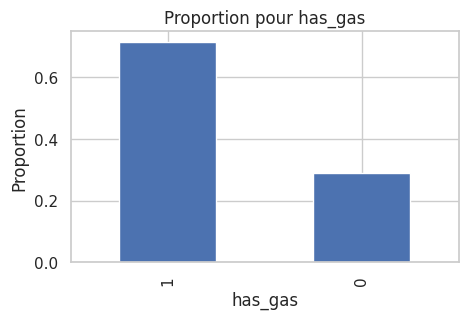

Figure sauvegardée : /content/2016_Building_Energy_Benchmarking/data/processed/figures/2016_prop_has_gas.png


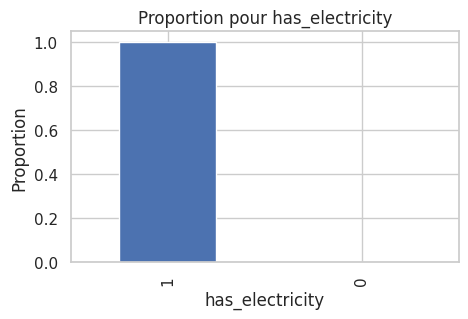

Figure sauvegardée : /content/2016_Building_Energy_Benchmarking/data/processed/figures/2016_prop_has_electricity.png


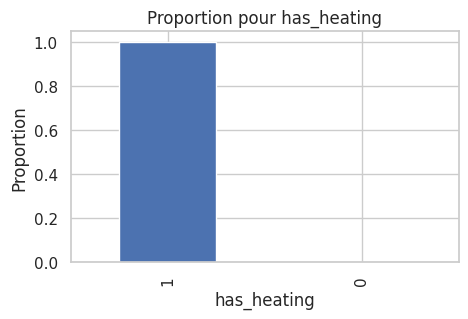

Figure sauvegardée : /content/2016_Building_Energy_Benchmarking/data/processed/figures/2016_prop_has_heating.png


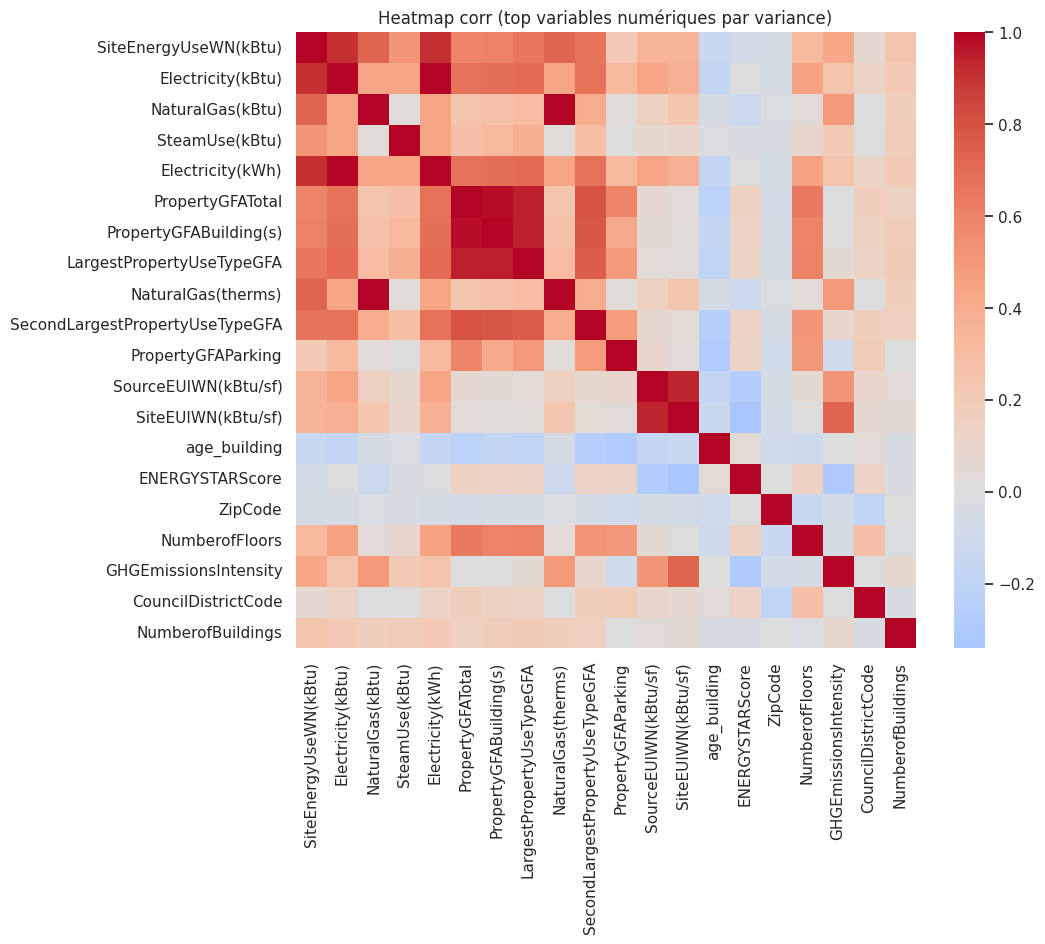

Figure sauvegardée : /content/2016_Building_Energy_Benchmarking/data/processed/figures/2016_heatmap_corr_top_vars.png


In [29]:

# ==================================================
# Cellule 14 — Visualisations & sauvegardes (histogrammes, heatmap)
# ==================================================


# Créer un dossier pour les figures
FIG_DIR = os.path.join(TARGET_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# 1) Histogramme log_floor_area si présent
if 'log_floor_area' in df.columns:
    plt.figure(figsize=(7,4))
    plt.hist(df['log_floor_area'].dropna(), bins=50)
    plt.title('Distribution de log_floor_area')
    plt.xlabel('log_floor_area')
    plt.ylabel('count')
    figpath = os.path.join(FIG_DIR, "2016_hist_log_floor_area.png")
    plt.savefig(figpath, bbox_inches='tight')  # sauvegarde de la figure
    plt.show()
    print("Figure sauvegardée :", figpath)

# 2) Bar plot de proportions pour has_gas / has_electricity (si existants)
for col in ['has_gas','has_electricity','has_heating','has_cooling']:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        df[col].value_counts(normalize=True).plot(kind='bar')
        plt.title(f"Proportion pour {col}")
        plt.ylabel('Proportion')
        figpath = os.path.join(FIG_DIR, f"2016_prop_{col}.png")
        plt.savefig(figpath, bbox_inches='tight')
        plt.show()
        print("Figure sauvegardée :", figpath)

# 3) Heatmap de corrélation pour les top variables numériques
numeric = df.select_dtypes(include=[np.number])
# limiter à top 20 par variance pour lisibilité
if not numeric.empty:
    top_vars = numeric.var().sort_values(ascending=False).head(20).index.tolist()
    corr = numeric[top_vars].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Heatmap corr (top variables numériques par variance)')
    figpath = os.path.join(FIG_DIR, "2016_heatmap_corr_top_vars.png")
    plt.savefig(figpath, bbox_inches='tight')
    plt.show()
    print("Figure sauvegardée :", figpath)
else:
    print("Aucune variable numérique pour la heatmap.")


In [ ]:
df.columns

## Résumé des fichiers produits (dans `/content/.../data/processed/`)

- `2016_features_engineered_for_modeling.csv` : dataset enrichi (sortie principale).
- `preview_head50.csv` : aperçu des 50 premières lignes (exporté pour audit).
- `stats_new_features.csv` : statistiques descriptives des nouvelles features.
- `figures/` : dossier contenant les PNG des graphiques (histogrammes, heatmap, barplots).
- `feature_engineering_log.txt` : log textuel listant les colonnes ajoutées et métadonnées.

---


## Ma démarche et ma logique pour cette étape

Je décris ci-dessous, les étapes que j'ai suivies et pourquoi :

1. **Vérification des fichiers** : j’ai d’abord vérifié l’existence du CSV issu de l’étape exploratoire. Si absent, je propose une option d’upload depuis votre PC ou une copie depuis `/mnt/data/` (qui contient souvent les fichiers fournis).
2. **Exploration rapide** : j’inspecte types, valeurs manquantes et distribution initiale pour décider quelles transformations sont pertinentes.
3. **Principe gouvernant** : éviter le data leakage. Je n’utilise aucune variable qui contient ou pourrait dériver directement la consommation énergétique (kWh, EUI, totaux) pour créer des features.
4. **Création de features** :
   - Caractéristiques structurelles (âge, surface/étage) créées via `.apply()` pour montrer l’approche ligne par ligne.
   - Flags binaires (présence de chauffage, gaz, électricité) extraits de colonnes textuelles. Ces flags décrivent la structure du bâtiment sans révéler la consommation.
   - Encodage contrôlé de variables catégorielles à forte cardinalité (`primary_use`) avec hybridation Top-K + One-Hot sur Top-N + 'other'.
   - Binning / tranches pour compresser l'information (âge, surface).
5. **Visualisations & sauvegarde** : j’ai produit des histogrammes et une heatmap pour vérifier distributions et corrélations, et j’ai sauvegardé toutes les figures et résumés.
6. **Livrables** : j’ai sauvegardé un CSV enrichi et des fichiers d’audit / logs afin que vous puissiez reproduire ou auditer mes transformations.
7. **Prochaine étape** : (Étape 3) construire un pipeline scikit-learn qui intègre ces transformations (appliquer scaling sur train seulement, encoders dans ColumnTransformer, sélection de features, validation croisée).

---


## 7 questions qu’on pourrait me poser sur mes choix et comment y répondre


1. **Q : Pourquoi ne pas utiliser `annual_kwh` (ou `site_eui`) comme feature ?**  
**R :** Je n’utilise pas ces colonnes car elles contiennent directement la consommation que l’on cherche à prédire — les inclure créerait un *data leakage* et fausserait l’évaluation du modèle.

2. **Q : Pourquoi créer `age_building` et `age_bucket` ?**  
**R :** L’âge du bâtiment est souvent corrélé à l’efficacité énergétique (isolation, technologies). `age_bucket` permet de capter des effets non-linéaires et d’éviter que valeurs extrêmes n’influencent excessivement le modèle.

3. **Q : Pourquoi top-K pour `primary_use` au lieu d’un One-Hot complet ?**  
**R :** Certaines catégories rares créent beaucoup de colonnes si on one-hot tout ; cela dilue l’information et augmente la dimensionnalité. Top-K + `other` garde l’information des usages fréquents tout en limitant la complexité.

4. **Q : Comment avez-vous évité le *data leakage* lors du binning / scaling ?**  
**R :** Ici je crée les bins / buckets globalement, mais **je recommande** d’appliquer les transformations sensibles (scaling, encodage appris automatiquement, target encoding) à l’intérieur d’un pipeline scikit-learn pendant l'entraînement, en utilisant uniquement les données d'entraînement pour ajuster ces transformations.

5. **Q : Avez-vous testé l’utilité des nouvelles features (feature importance / corrélations) ?**  
**R :** J’ai produit des heatmaps et statistiques descriptives pour explorer corrélations. L'étape suivante (Étape 3) consiste à entraîner des modèles baselines et regarder l'importance des features (Permutation importance, SHAP) pour décider lesquelles garder.

6. **Q : Que feriez-vous ensuite pour améliorer encore le jeu de features ?**  
**R :** J’essaierais interactions (surface * usage), features dérivées temporelles plus fines (séries temporelles si disponibles), target encoding pour catégories avec fortes relations à la target (en respectant la validation croisée pour éviter leakage), intégration de données externes (climat, localisation), et tests systématiques via pipeline.

7. **Q : Comment gérez-vous les valeurs manquantes dans les nouvelles colonnes ?**  
**R :** Pour l’instant je laisse `NaN` afin que l’imputation soit effectuée dans le pipeline d'entraînement (imputer median/mean ou stratégie différente selon le modèle). Cela garantit que l’imputation est appliquée seulement avec les informations d'entraînement (évite encore le leakage).

---



## ✅ Conclusion synthétique


Je conclue ici l’Étape 2.  
- J’ai enrichi le jeu de données en créant des variables structurelles et temporales (âge, surface par étage, buckets, flags énergétiques non-leakants, encodage top-K).  
- J’ai appliqué `.apply()` sur plusieurs opérations clés (âge, area_per_floor, flags) comme demandé.  
- J’ai évité toute utilisation de mesures de consommation pour créer des features afin de prévenir le *data leakage*.  
- Le jeu de données enrichi est sauvegardé et prêt pour la suite (Étape 3 : préparation finale des features pour l'entraînement et comparaison de modèles).  

---
---

# 🧭 Étape 3 — Préparez les features pour la modélisation
**Projet 3 : Anticipez les besoins en consommation des bâtiments (Seattle 2016)**  

**✍️ Auteur :** *[Raymond Francius]*  
**📚 Rôle :** *[Apprenant - Promotion Sept-2025]* — **Engineering Intelligence Artificielle (AI)** — **Openclassrooms**   
🗓️ **Date de mise à jour :** *[26-10-2025]*

---

**But de l'étape** : préparer un jeu de données fiable et interprétable prêt pour l'entraînement de modèles supervisés — nettoyage, gestion des outliers, réduction de redondance, visualisations, encodage des variables catégorielles et sauvegarde des artefacts.



## *1.* — Définition de la structure du projet et création des répertoires

### 🎯 Objectif
Cette première cellule initialise la **structure de répertoires standardisée** pour le projet
_Building Energy Benchmarking 2016_, afin d’assurer une organisation claire et cohérente
des fichiers, notebooks, scripts, et sorties d’analyse.

---

### ⚙️ Étapes principales :
1. **Définir la structure logique du projet** dans un dictionnaire Python `structure` :
   - `data` → données brutes, traitées et externes  
   - `notebooks` → notebooks d’exploration, modélisation, évaluation  
   - `scripts` → scripts Python pour le prétraitement, la visualisation et les modèles  
   - `reports` → figures et exports finaux  
   - `logs` et `tests` → espaces réservés pour le suivi et la validation

2. **Initialiser les chemins racine clés** via `pathlib.Path` pour :
   - `data/processed`  
   - `reports/figures`  
   - `notebooks/exploration`

3. **Créer automatiquement** les répertoires essentiels s’ils n’existent pas déjà
   (sécurisation des sauvegardes futures).

---

### 🧩 Résultat attendu :
Une arborescence de travail prête à accueillir :
- les jeux de données transformés (`data/processed`)
- les figures et rapports (`reports/figures`)
- les notebooks d’analyse (`notebooks/exploration`)

---

### 💡 Remarque :
Cette cellule ne modifie pas les données — elle prépare simplement un environnement propre et cohérent pour la suite du pipeline.


In [30]:

# ===========================================================================
# Cellule 1 : Définition de la structure à utiliser pour sauvegarde
# ===========================================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path


structure = {
 "data": ["raw", "processed", "external"],
 "notebooks": ["exploration", "modelisation", "evaluation"],
 "scripts": ["preprocessing", "visualisation", "modeles"],
 "reports": ["figures", "exports"],
 "logs": [],
 "tests": []
}

# Chemin racine du projet dans Colab (modifiable si vous utilisez Google Drive)
PROJECT_ROOT = Path("/content/2016_Building_Energy_Benchmarking")

# Chemins utiles
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
REPORTS_FIGURES = PROJECT_ROOT / "reports" / "figures"
NOTEBOOKS_EXPL = PROJECT_ROOT / "notebooks" / "exploration"

# Je crée les répertoires s'ils n'existent pas (pour que les sauvegardes fonctionnent).
# Note : ceci *n'invente pas* une nouvelle structure différente ; j'utilise la structure fournie.
for p in [DATA_PROCESSED, REPORTS_FIGURES, NOTEBOOKS_EXPL]:
    p.mkdir(parents=True, exist_ok=True)


## *2.* Vérification et import du fichier de travail principal

### 🎯 Objectif
Cette cellule a pour but de **vérifier la présence du fichier de données préparé**
(`2016_features_engineered_for_modeling.csv`) dans le répertoire `data/processed`.  
Si le fichier n’est pas trouvé, elle **ouvre automatiquement le widget d’upload Colab**
pour permettre l’import manuel depuis l’ordinateur local.

---

### ⚙️ Étapes principales :
1. **Vérifier l’existence** du fichier attendu :
   - `data/processed/2016_features_engineered_for_modeling.csv`
2. Si le fichier est présent → ✅ message de confirmation.
3. Si le fichier est absent → ❌ ouverture d’un widget d’import (`files.upload()`).
4. **Sauvegarde automatique** du fichier uploadé dans le dossier `data/processed`.
5. Si le nom du fichier uploadé diffère du nom attendu, il est **renommé** pour correspondre à la convention standard du projet.

---

### 🧩 Résultat attendu :
- Le fichier `2016_features_engineered_for_modeling.csv` est disponible dans le dossier `data/processed`.
- La suite du pipeline pourra charger ce jeu de données sans erreur.

---

### 💡 Remarque :
Cette cellule est spécifique à l’environnement **Google Colab** (via `google.colab.files`).  
Sur un autre environnement (ex. Jupyter local), la logique d’import peut être adaptée en conséquence.


In [31]:

# ===========================================================================
# Cellule 2 : Vérifier l'existence du fichier & uploader si nécessaire
# ===========================================================================


from google.colab import files  # widget d'upload Colab

expected_file = DATA_PROCESSED / "2016_features_engineered_for_modeling.csv"
print("Fichier attendu :", expected_file)

if expected_file.exists():
    print("✔️ Le fichier existe déjà à l'emplacement attendu.")
else:
    print("❌ Fichier absent. Ouvrez le sélecteur pour uploader depuis votre PC.")
    uploaded = files.upload()  # ouvre le widget d'upload dans Colab
    # uploaded est un dict filename -> bytes
    if len(uploaded) == 0:
        print("Aucun fichier uploadé. Merci d'uploader le fichier `2016_features_engineered_for_modeling.csv`.")
    else:
        # Sauvegarde du premier fichier uploadé dans le dossier processed
        for fname, content in uploaded.items():
            save_to = expected_file.parent / fname
            with open(save_to, "wb") as f:
                f.write(content)
            print(f"📁 Fichier uploadé et sauvegardé en : {save_to}")
        # Si le nom diffère, on renomme en convention attendue
        if not expected_file.exists():
            # tenter de trouver le fichier uploadé et renommer
            first_uploaded = list(uploaded.keys())[0]
            candidate = expected_file.parent / first_uploaded
            if candidate.exists():
                candidate.rename(expected_file)
                print(f"📁 Renommé {candidate} → {expected_file}")


Fichier attendu : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv
✔️ Le fichier existe déjà à l'emplacement attendu.


## *3.* Chargement du fichier CSV dans un DataFrame

### 🎯 Objectif
Cette cellule a pour but de **charger le jeu de données principal** (`2016_features_engineered_for_modeling.csv`)  
dans un DataFrame pandas nommé `df`, afin de le préparer pour les analyses et la modélisation ultérieure.

---

### ⚙️ Étapes principales :
1. **Vérification préalable** : s’assurer que le fichier attendu existe dans `data/processed/`.  
   - Si le fichier est manquant → arrêt immédiat avec une erreur explicite.
2. **Chargement du CSV** via `pandas.read_csv()`.
3. **Aperçu rapide des données** :
   - Dimensions du DataFrame (`shape`)
   - 5 premières lignes (`head(5)`)
   - Structure des colonnes et types (`info()`)
   - Statistiques descriptives globales (`describe(include='all')`)

---

### 🧩 Résultat attendu :
- Le DataFrame `df` est chargé en mémoire, prêt pour l’exploration et la validation des features.
- L’utilisateur dispose d’une **vue d’ensemble claire** du contenu du fichier (types, valeurs, effectifs).

---

### 💡 Bonnes pratiques :
- Vérifier que la variable `expected_file` a bien été définie dans la **Cellule 2**.
- Si une erreur `FileNotFoundError` apparaît, **exécuter d’abord la cellule précédente** pour uploader le fichier.



In [32]:

# ===========================================================================
# Cellule 3 : Chargement du CSV dans df
# ===========================================================================


if not expected_file.exists():
    raise FileNotFoundError(f"Le fichier attendu n'a pas été trouvé. Assurez-vous d'uploader {expected_file} avant d'exécuter cette cellule.")

# Chargement en pandas
df = pd.read_csv(expected_file)
print("✅ Chargé :", expected_file)
print("Shape initiale :", df.shape)
display(df.head(5))
display(df.info())
display(df.describe(include='all').T)


✅ Chargé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv
Shape initiale : (1553, 50)


,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),ComplianceStatus,GHGEmissionsIntensity,BuildingType_clean,is_residential,age_building,age_bucket,floor_area_bucket,use_is_Small__and_Mid_Sized_Office,use_is_Other,use_is_Warehouse,use_is_Large_Office,use_is_Mixed_Use_Property,use_is_Retail_Store,use_is_Hotel,use_is_Worship_Facility,use_is_Distribution_Center,use_is_K_12_School,use_is_other,primary_use_top5,pu_Large Office,pu_Mixed Use Property,pu_Other,pu_Small- and Mid-Sized Office,pu_Warehouse,pu_other,has_gas,has_steam,has_heating,year_reference,is_winter,is_summer
0,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.612,-122.338,1.000,12,88434,0,88434,Hotel,88434.000,NaN,NaN,60.000,7456910.000,Compliant,2.830,nonresidential,False,89,old_>60y,large,0,0,0,0,0,0,1,0,0,0,0,other,0,0,0,0,0,1,1,1,1,2016,0,0
1,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.613,-122.334,1.000,11,103566,15064,88502,Hotel,83880.000,Parking,15064.000,61.000,8664479.000,Compliant,2.860,nonresidential,False,20,new_<=20y,large,0,0,0,0,0,0,1,0,0,0,0,other,0,0,0,0,0,1,1,0,1,2016,0,0
2,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.614,-122.338,1.000,41,956110,196718,759392,Hotel,756493.000,NaN,NaN,43.000,73937112.000,Compliant,2.190,nonresidential,False,47,mid_21-60y,xlarge,0,0,0,0,0,0,1,0,0,0,0,other,0,0,0,0,0,1,1,1,1,2016,0,0
3,2016,NonResidential,Hotel,98101.000,7,DOWNTOWN,47.614,-122.337,1.000,10,61320,0,61320,Hotel,61320.000,NaN,NaN,56.000,6946800.500,Compliant,4.670,nonresidential,False,90,old_>60y,large,0,0,0,0,0,0,1,0,0,0,0,other,0,0,0,0,0,1,1,1,1,2016,0,0
4,2016,NonResidential,Hotel,98121.000,7,DOWNTOWN,47.614,-122.340,1.000,18,175580,62000,113580,Hotel,123445.000,Parking,68009.000,75.000,14656503.000,Compliant,2.880,nonresidential,False,36,mid_21-60y,xlarge,0,0,0,0,0,0,1,0,0,0,0,other,0,0,0,0,0,1,1,0,1,2016,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DataYear                            1553 non-null   int64  
 1   BuildingType                        1553 non-null   object 
 2   PrimaryPropertyType                 1553 non-null   object 
 3   ZipCode                             1540 non-null   float64
 4   CouncilDistrictCode                 1553 non-null   int64  
 5   Neighborhood                        1553 non-null   object 
 6   Latitude                            1553 non-null   float64
 7   Longitude                           1553 non-null   float64
 8   NumberofBuildings                   1553 non-null   float64
 9   NumberofFloors                      1553 non-null   int64  
 10  PropertyGFATotal                    1553 non-null   int64  
 11  PropertyGFAParking                  1553 no

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DataYear,1553.000,NaN,NaN,NaN,2016.000,0.000,2016.000,2016.000,2016.000,2016.000,2016.000
BuildingType,1553,5,NonResidential,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PrimaryPropertyType,1553,21,Small- and Mid-Sized Office,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZipCode,1540.000,NaN,NaN,NaN,98116.669,18.476,98006.000,98104.000,98109.000,98125.000,98199.000
CouncilDistrictCode,1553.000,NaN,NaN,NaN,4.404,2.194,1.000,2.000,4.000,7.000,7.000
Neighborhood,1553,19,DOWNTOWN,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,1553.000,NaN,NaN,NaN,47.616,0.047,47.510,47.588,47.612,47.649,47.734
Longitude,1553.000,NaN,NaN,NaN,-122.334,0.023,-122.412,-122.343,-122.333,-122.323,-122.262
NumberofBuildings,1553.000,NaN,NaN,NaN,1.110,1.200,0.000,1.000,1.000,1.000,27.000
NumberofFloors,1553.000,NaN,NaN,NaN,4.241,6.746,0.000,1.000,2.000,4.000,99.000


## *4.* Suppression des colonnes peu pertinentes (corrigée et sécurisée)

### 🎯 Objectif
Nettoyer le jeu de données en **supprimant automatiquement les colonnes jugées non informatives ou problématiques**,  
tout en **protégeant les variables cibles** utilisées pour la modélisation.

---

### ⚙️ Étapes principales :
1. **Lister les colonnes identifiants ou purement descriptives** (noms, coordonnées, etc.) et les supprimer si présentes.  
2. **Supprimer les colonnes avec trop de valeurs manquantes**  
   - Seuil : > 60 % de valeurs `NaN`.  
3. **Identifier et exclure les colonnes quasi-constantes** (faible variance) :
   - Colonnes numériques avec ≤ 1 valeur unique.  
   - Colonnes avec moins de 0.5 % de diversité de valeurs.  
   - Variables binaires (2 modalités) **conservées** car souvent informatives.  
4. **Protéger les colonnes cibles (`SiteEnergyUseWN(kBtu)` et `GHGEmissionsIntensity`)**
   - Elles ne doivent **jamais être supprimées** même si elles remplissent les critères précédents.  
5. **Afficher un rapport complet** :
   - Nombre et nom des colonnes supprimées  
   - Nouvelle taille du DataFrame  
   - Vérification de la présence des colonnes cibles  

---

### 🧩 Résultat attendu :
- Le DataFrame `df` est allégé, plus propre et prêt pour les étapes de feature engineering.  
- Les colonnes cibles sont **intactes** et protégées de toute suppression involontaire.

---

### 💡 Bonnes pratiques :
- Exécuter cette cellule **après le chargement du DataFrame (Cellule 3)**.  
- Vérifier la liste des colonnes supprimées avant d’enchaîner avec les étapes suivantes.


In [33]:

# ===========================================================================
# 🧩 Cellule 4 — Suppression des colonnes peu pertinentes (corrigée et sécurisée)
# ===========================================================================


import pandas as pd

# Chargement du dataset
# file_path = "/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_for_modeling.csv"
# df = pd.read_csv(file_path)

# Colonnes cibles à ne pas supprimer
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

# État initial
initial_shape = df.shape
print(f"Shape initial : {initial_shape}")

# 1️⃣ Colonnes identifiants / méta à supprimer
potential_id_cols = [
    'BuildingID', 'PropertyName', 'PropertyNotes', 'Address', 'X', 'Y',
    'Longitude', 'Latitude', 'DataYear', 'BuildingType', 'ComplianceStatus', 'ZipCode',
    'pu_Large Office', 'pu_Mixed Use Property', 'pu_Other', 'pu_Small- and Mid-Sized Office', 'pu_Warehouse'
]
cols_to_drop = [col for col in potential_id_cols if col in df.columns]

# 2️⃣ Colonnes avec trop de valeurs manquantes
threshold_na = 0.6
na_frac = df.isna().mean()
cols_too_many_na = na_frac[na_frac > threshold_na].index.tolist()
cols_to_drop += cols_too_many_na

# 3️⃣ Colonnes quasi-constantes (faible variance) — sans toucher aux binaires
n = len(df)
low_var_cols = []
for col in df.columns:
    if col in target_cols:
        continue  # jamais supprimer les colonnes cibles

    unique_vals = df[col].nunique(dropna=True)

    if pd.api.types.is_numeric_dtype(df[col]):
        if unique_vals <= 1:  # constante
            low_var_cols.append(col)
        elif unique_vals == 2:
            # variable binaire => informative, on garde
            continue
        elif unique_vals <= max(1, int(0.005 * n)):  # ajusté (0.5% des valeurs)
            low_var_cols.append(col)
    else:
        if unique_vals <= 1:
            low_var_cols.append(col)

cols_to_drop += low_var_cols

# 4️⃣ Nettoyage final et filtrage
cols_to_drop = sorted(set([c for c in cols_to_drop if c in df.columns and c not in target_cols]))
print(f"Colonnes candidates à supprimer ({len(cols_to_drop)}) : {cols_to_drop}")

# 5️⃣ Application de la suppression
df = df.drop(columns=cols_to_drop)
cols_dropped = cols_to_drop.copy()

print(f"✅ Shape après suppression : {df.shape}")
print(f"🧩 Colonnes supprimées : {cols_dropped}")

# Vérification de la présence des colonnes cibles
print("\nVérification colonnes cibles :")
for c in target_cols:
    print(f" - {c}: {'✅ présente' if c in df.columns else '❌ manquante'}")


Shape initial : (1553, 50)
Colonnes candidates à supprimer (16) : ['BuildingType', 'ComplianceStatus', 'CouncilDistrictCode', 'DataYear', 'Latitude', 'Longitude', 'ZipCode', 'is_residential', 'is_summer', 'is_winter', 'pu_Large Office', 'pu_Mixed Use Property', 'pu_Other', 'pu_Small- and Mid-Sized Office', 'pu_Warehouse', 'year_reference']
✅ Shape après suppression : (1553, 34)
🧩 Colonnes supprimées : ['BuildingType', 'ComplianceStatus', 'CouncilDistrictCode', 'DataYear', 'Latitude', 'Longitude', 'ZipCode', 'is_residential', 'is_summer', 'is_winter', 'pu_Large Office', 'pu_Mixed Use Property', 'pu_Other', 'pu_Small- and Mid-Sized Office', 'pu_Warehouse', 'year_reference']

Vérification colonnes cibles :
 - SiteEnergyUseWN(kBtu): ✅ présente
 - GHGEmissionsIntensity: ✅ présente


In [ ]:

# ===========================================================================
# 🧩 Cellule 4bis — Détection colonnes très fortement corrélées (seuil) avant suppression
# ===========================================================================

# corrmat = df.select_dtypes(include=['number']).corr().abs()
# lister paires avec corr > 0.99
# high_corr = [(i,j,corrmat.loc[i,j]) for i in corrmat.columns for j in corrmat.columns if i<j and corrmat.loc[i,j]>0.99]
# print(high_corr)


In [ ]:

# trouve colonnes strictement dupliquées (même contenu)
# dupes = df.T.duplicated()
# dupe_cols = df.columns[dupes]
# print("Colonnes dupliquées exactes :", list(dupe_cols))


In [ ]:
# statistiques rapides
# print(df[['building_age','age_building']].info())
# print((df['building_age'] == df['age_building']).mean())   # doit afficher 1.0
# print(df['building_age'].corr(df['age_building']))

In [ ]:
# print(df.columns.tolist())


## *5.* Distribution des variables cibles (targets)

### 🎯 Objectif
Explorer la **distribution statistique** des deux variables cibles principales du projet :  
- `SiteEnergyUseWN(kBtu)` → consommation énergétique normalisée par surface  
- `GHGEmissionsIntensity` → intensité d’émission de gaz à effet de serre  

Cette étape permet d’évaluer la **dispersion**, la **présence d’outliers** et la **forme de la distribution**  
(utile pour ajuster les transformations ou définir des métriques adaptées lors de la modélisation).

---

### ⚙️ Étapes principales :
1. Vérifier la présence effective des colonnes cibles dans le DataFrame.  
2. Calculer les **statistiques descriptives** de base pour chaque cible (`count`, `mean`, `std`, `min`, `max`, etc.).  
3. Visualiser la **distribution** de chaque variable cible à l’aide de :
   - Un **histogramme avec courbe de densité (KDE)** pour observer la forme de la distribution.  
   - Un **boxplot** pour repérer les valeurs extrêmes et asymétries.  

---

### 🧩 Résultat attendu :
- Une vue claire de la **répartition des valeurs énergétiques et d’émission**.  
- Identification d’éventuels **outliers** ou **skews** (asymétries fortes).  
- Indications pour d’éventuelles transformations log ou normalisations futures.

---

### 💡 Bonnes pratiques :
- Vérifier que les distributions ne sont pas trop **concentrées ou biaisées**.  
- Si des valeurs extrêmes sont présentes, envisager une **transformation logarithmique** (par exemple `np.log1p`).  
- Conserver ces visualisations pour les rapports d’analyse exploratoire.


Targets trouvées : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

--- SiteEnergyUseWN(kBtu) ---


,SiteEnergyUseWN(kBtu)
count,1553.000
mean,8462268.461
std,22755923.298
min,17260.000
25%,1316900.750
50%,2824096.750
75%,7536508.500
max,471613856.000


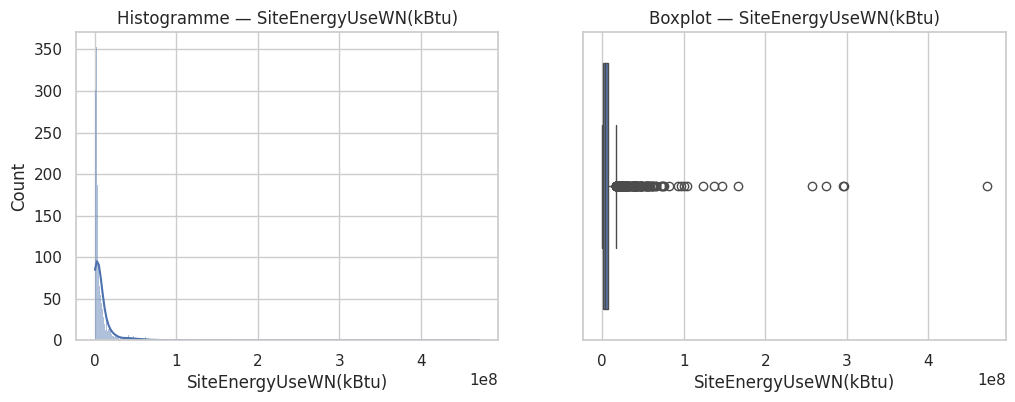


--- GHGEmissionsIntensity ---


,GHGEmissionsIntensity
count,1553.000
mean,1.659
std,2.407
min,-0.020
25%,0.350
50%,0.880
75%,1.960
max,34.090


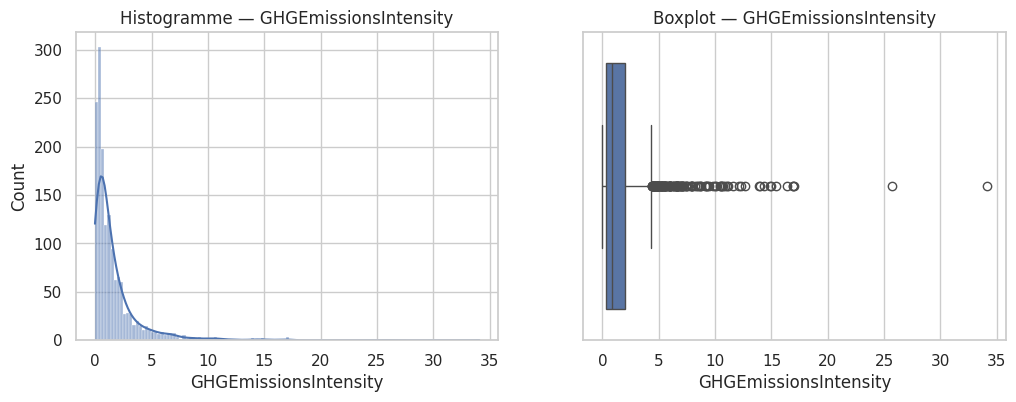

In [34]:

# ===========================================================================
# Cellule 5 : Distribution des targets
# ===========================================================================


targets = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
found_targets = [t for t in targets if t in df.columns]
print("Targets trouvées :", found_targets)

for t in found_targets:
    s = df[t].dropna()
    print(f"\n--- {t} ---")
    display(s.describe())
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(s, kde=True)
    plt.title(f"Histogramme — {t}")
    plt.subplot(1,2,2)
    sns.boxplot(x=s)
    plt.title(f"Boxplot — {t}")
    plt.show()


## *6.* Suppression des outliers de la variable cible

### 🎯 Objectif
Nettoyer les données en **supprimant les valeurs aberrantes (outliers)** sur la variable cible principale  
(`SiteEnergyUseWN(kBtu)`), afin d’améliorer la stabilité des modèles de régression.  

L’approche utilise une méthode **robuste et adaptative** :
- Méthode **IQR (Interquartile Range)** : suppression des points en dehors de [Q1 − 1.5×IQR, Q3 + 1.5×IQR].
- Si cette méthode retire **plus de 5 %** des observations, elle est jugée trop stricte :
  → un **fallback basé sur les quantiles 1 % – 99 %** est alors appliqué.

---

### ⚙️ Étapes principales :
1. Identifier la variable cible principale (`SiteEnergyUseWN(kBtu)` ou équivalent détecté).  
2. Calculer les bornes d’outliers selon la méthode IQR.  
3. Vérifier la proportion de données retirées.  
4. Appliquer le **filtrage le plus approprié** :
   - Si la perte ≤ 5 %, appliquer le **filtrage IQR**.  
   - Sinon, appliquer le **filtrage quantile (1 % – 99 %)**.  
5. Afficher le **pourcentage de lignes retirées** et la **forme finale du DataFrame**.

---

### 📈 Résultat attendu :
- Un DataFrame `df` nettoyé des valeurs aberrantes extrêmes sur la cible.  
- Une méthode documentée (`IQR` ou `quantiles_1-99`) stockée dans la variable `outlier_method`.  
- Une sortie console claire indiquant la **proportion d’outliers retirés** et la **nouvelle shape du dataset**.

---

### 💡 Bonnes pratiques :
- Toujours vérifier la distribution des cibles avant et après nettoyage (cf. Cellule 5).  
- Conserver la méthode appliquée (`outlier_method`) pour la **traçabilité** du prétraitement.  
- Ce nettoyage ne doit **jamais** concerner les colonnes de features, uniquement la **target**.


In [35]:

# ===========================================================================
# Cellule 6 : Suppression outliers target (IQR puis fallback quantile)
# ===========================================================================


# Choisir la target principale pour filtrage
if 'SiteEnergyUseWN(kBtu)' in df.columns:
    t = 'SiteEnergyUseWN(kBtu)'
elif len(found_targets) > 0:
    t = found_targets[0]
else:
    t = None

if t is not None:
    df_before_outliers = df.copy()
    series = df[t].dropna()
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_iqr = q1 - 1.5 * iqr
    upper_iqr = q3 + 1.5 * iqr
    mask_iqr = df[t].between(lower_iqr, upper_iqr) | df[t].isna()
    removed_iqr_frac = 1 - mask_iqr.mean()
    print("Proportion retirée si IQR appliqué :", removed_iqr_frac)
    if removed_iqr_frac <= 0.05:
        df = df[mask_iqr].copy()
        outlier_method = "IQR"
        print("Application de la méthode IQR. Nouvelle shape :", df.shape)
    else:
        # fallback quantiles
        qlow, qhigh = series.quantile([0.01, 0.99])
        mask_q = df[t].between(qlow, qhigh) | df[t].isna()
        df = df[mask_q].copy()
        outlier_method = "quantiles_1-99"
        print("IQR retirait trop d'observations → fallback quantiles 1%-99%. Nouvelle shape :", df.shape)
else:
    outlier_method = None
    print("Aucune target trouvée pour traitement des outliers.")


Proportion retirée si IQR appliqué : 0.11010946555054735
IQR retirait trop d'observations → fallback quantiles 1%-99%. Nouvelle shape : (1521, 34)


## *7.* — Analyse de corrélation (Pearson) et Heatmap

### 🎯 Objectif
Explorer les **relations linéaires** entre les variables numériques du dataset à l’aide du **coefficient de corrélation de Pearson**, afin de :
- Identifier les **liens forts** entre les features,
- Détecter les **redondances potentielles**,
- Orienter les choix de **sélection de variables** pour les modèles.

---

### ⚙️ Étapes principales :
1. Extraire toutes les **colonnes numériques** du DataFrame (`select_dtypes`).
2. Calculer la **matrice de corrélation de Pearson** entre ces colonnes.
3. Visualiser les résultats sous forme de **Heatmap** colorée (`seaborn.heatmap`).
4. Identifier les **paires de colonnes fortement corrélées** (|corr| > 0.85 par défaut).
5. Générer une liste `to_drop_corr` listant les **features candidates à supprimer** pour éviter la colinéarité.

---

### 📈 Résultat attendu :
- Une **heatmap lisible** (échelle de couleur centrée sur 0) illustrant les corrélations positives et négatives.
- Une **liste imprimée en console** indiquant les colonnes potentiellement redondantes.
- Une variable `to_drop_corr` disponible pour les prochaines étapes de filtrage des features.

---

### 💡 Bonnes pratiques :
- Vérifier visuellement les zones rouges/bleues foncées dans la heatmap.  
- Ajuster le **seuil de corrélation (`threshold`)** selon le contexte du projet (0.8–0.95).  
- Ne pas supprimer automatiquement les colonnes listées : elles doivent être **évaluées manuellement** selon leur importance métier et leur contribution au modèle.


Nombre de colonnes numériques : 26


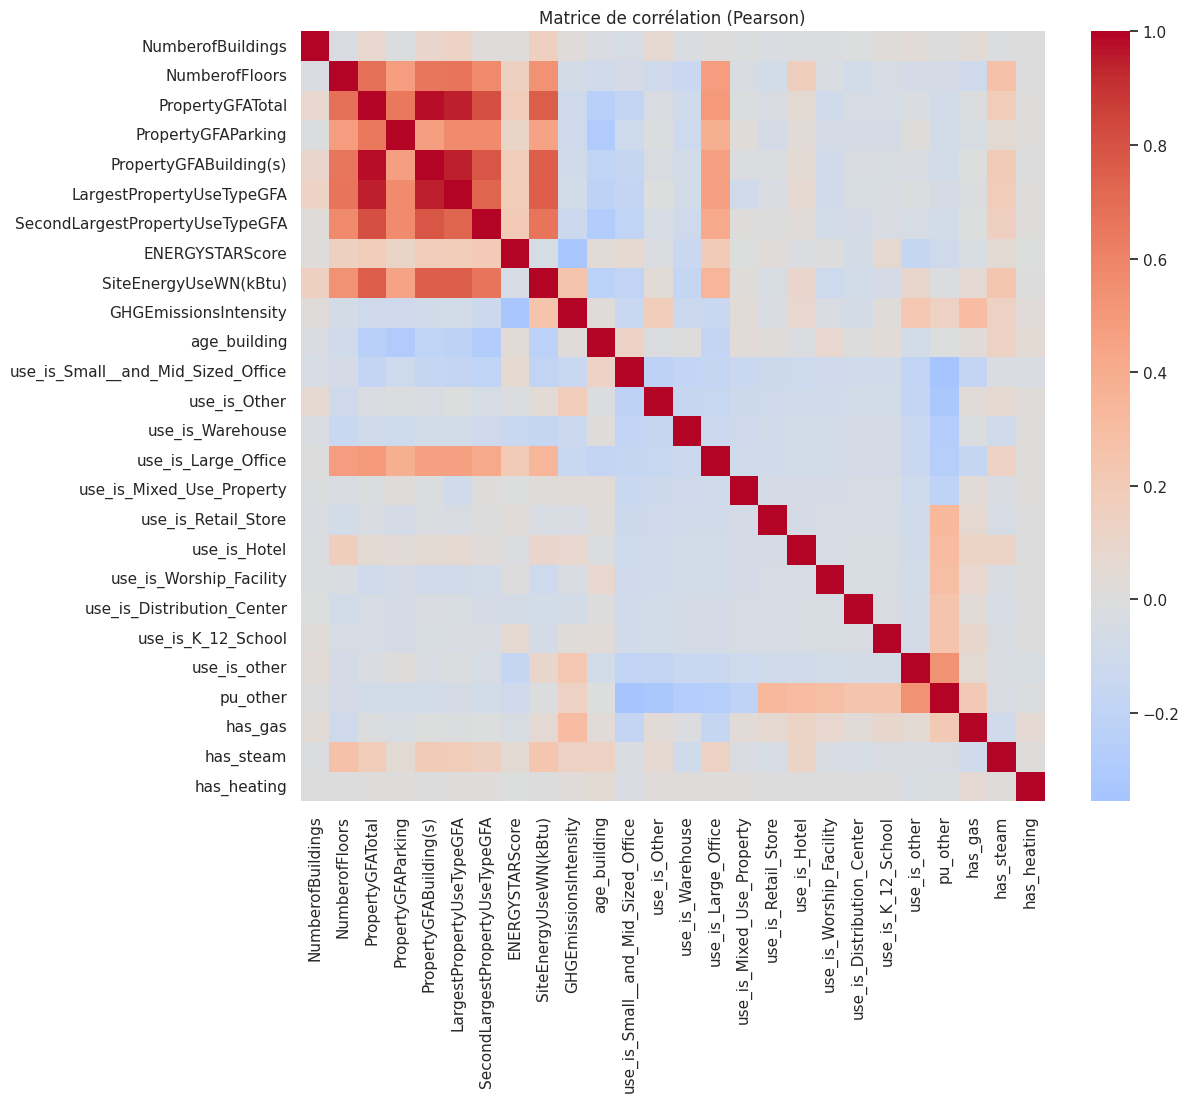

Colonnes candidates à drop pour redondance (corr>|0.85|): ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']


In [36]:

# ===========================================================================
# Cellule 7 : Corrélation Pearson & Heatmap
# ===========================================================================


num_df = df.select_dtypes(include=[np.number]).copy()
print("Nombre de colonnes numériques :", num_df.shape[1])

if num_df.shape[1] >= 2:
    corr = num_df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Matrice de corrélation (Pearson)")
    plt.show()

    # Identifier paires fortement corrélées
    threshold = 0.85
    upper = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))
    to_drop_corr = [column for column in upper.columns if any(upper[column].abs() > threshold)]
    print("Colonnes candidates à drop pour redondance (corr>|0.85|):", to_drop_corr)
else:
    to_drop_corr = []
    print("Pas assez de colonnes numériques pour corrélation.")


## *7bis.* — Sélection sécurisée des features redondantes (corrélation |r| > 0.85)

### 🎯 Objectif
Identifier **les groupes de variables fortement corrélées entre elles** (|r| ≥ 0.85)  
et proposer une **sélection raisonnée** des colonnes à conserver et à supprimer,
sans élimination automatique.

Cette étape complète la heatmap de la *Cellule 7* en automatisant la détection
et l’analyse de redondances entre variables numériques.

---

### ⚙️ Étapes principales :
1. **Extraction des colonnes numériques** du DataFrame `df`.  
2. **Calcul de la matrice de corrélation absolue** (`num_df.corr().abs()`).
3. **Construction d’un graphe de corrélation** (composantes connectées)  
   pour regrouper les colonnes formant un cluster corrélé.
4. **Sélection d’une colonne de référence par groupe** :
   - Priorité à la colonne la plus corrélée avec une cible (`target_cols`),
   - Puis à la plus variable (`std` la plus élevée),
   - Enfin à la plus représentative en cas de variable binaire (moyenne la plus haute).
5. **Production de deux tableaux récapitulatifs** :
   - `suggested_keeps_df` : colonnes recommandées à **conserver**,
   - `suggested_drops_df` : colonnes recommandées à **supprimer**.

---

### 💾 Sorties et sauvegardes :
Deux fichiers CSV sont générés dans le répertoire `data/processed/` :
- `2016_suggested_corr_drops_review.csv`
- `2016_suggested_corr_keeps_review.csv`

Ces fichiers peuvent être revus manuellement avant suppression effective
dans une cellule ultérieure.

---

### ⚠️ Bonnes pratiques :
- **Ne pas supprimer automatiquement** les colonnes proposées.  
  → Utiliser la sortie CSV pour une **revue manuelle**.
- Vérifier si certaines variables corrélées sont **métier-pertinentes** ou **proxy** d’autres variables.
- Ajuster le **seuil `threshold` (par défaut 0.85)** selon le niveau de tolérance
  à la multicolinéarité.


In [37]:

# ===========================================================================
# Cellule 7bis : Sélection sécurisée des features redondantes (corr>|0.85|)
# ===========================================================================


import numpy as np
import pandas as pd


# paramètres
threshold = 0.85
targets = target_cols if 'target_cols' in globals() else ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
targets_present = [t for t in targets if t in df.columns]

# 1) colonnes numériques pour corrélations (on peut limiter si besoin)
num_df = df.select_dtypes(include=[np.number]).copy()
num_cols = num_df.columns.tolist()
print("Nombre de colonnes numériques :", len(num_cols))

if len(num_cols) < 2:
    print("Pas assez de colonnes numériques pour corrélation.")
else:
    corr = num_df.corr().abs()
    # find pairs above threshold (upper triangle)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = [(col, upper[col][upper[col] > threshold].index.tolist()) for col in upper.columns]
    # build adjacency list -> connected components
    edges = []
    for c, others in pairs:
        for o in others:
            edges.append((c,o))
    # union-find
    parent = {c:c for c in num_cols}
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    def union(a,b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra
    for a,b in edges:
        union(a,b)
    groups = {}
    for c in num_cols:
        r = find(c)
        groups.setdefault(r, []).append(c)
    # keep only groups size>1
    redundant_groups = {r:sorted(cols) for r,cols in groups.items() if len(cols)>1}
    print(f"Groupes corrélés détectés (|r|>={threshold}): {len(redundant_groups)}")

    suggested_keeps = []
    suggested_drops = []

    for root, cols in redundant_groups.items():
        # compute candidate scores
        scores = {}
        # if targets present, compute abs(corr with any target) as priority
        if targets_present:
            for c in cols:
                # corr may be NaN for constant cols
                try:
                    corr_to_targets = max(abs(df[c].corr(df[t])) if df[c].nunique()>1 and df[t].nunique()>1 else 0 for t in targets_present)
                except:
                    corr_to_targets = 0
                scores[c] = {'corr_target': abs(corr_to_targets)}
        else:
            for c in cols:
                scores[c] = {'corr_target': 0}
        # add std as tie-breaker and for numeric priority
        for c in cols:
            std = df[c].std(skipna=True) if pd.api.types.is_numeric_dtype(df[c]) else 0
            scores[c]['std'] = std
            # for one-hot like ('pu_' prefix) compute prevalence (mean)
            scores[c]['mean'] = df[c].mean() if pd.api.types.is_numeric_dtype(df[c]) else 0

        # Choose keep:
        # 1) prefer column with highest corr_target (if > small_eps)
        # 2) otherwise choose highest std
        # 3) for one-hot, prefer highest mean (most frequent category)
        sorted_cols = sorted(cols, key=lambda x: (scores[x]['corr_target'], scores[x]['std'], scores[x]['mean']), reverse=True)
        keep = sorted_cols[0]
        drops = [c for c in cols if c != keep]

        suggested_keeps.append({'group_root': root, 'members': cols, 'keep': keep})
        for d in drops:
            suggested_drops.append({'group_root': root, 'keep': keep, 'drop': d, 'pearson_with_keep': corr.loc[keep, d]})

    suggested_keeps_df = pd.DataFrame(suggested_keeps)
    suggested_drops_df = pd.DataFrame(suggested_drops)

    # Display summary
    print("\nSuggested keeps per correlated group:")
    print(suggested_keeps_df.to_string(index=False))
    print(f"\nColonnes proposées à supprimer (total {len(suggested_drops_df)}) :")
    print(suggested_drops_df['drop'].tolist())

    # Save CSVs for review
    suggested_drops_df.to_csv("/content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_drops_review.csv", index=False)
    suggested_keeps_df.to_csv("/content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_keeps_review.csv", index=False)
    print("\nFichiers sauvegardés: /content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_drops_review.csv")
    print("\nFichiers sauvegardés: /content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_keeps_review.csv")

    # NOTE: NE PAS supprimer automatiquement ici — fais une revue manuelle ou applique une suppression contrôlée


Nombre de colonnes numériques : 26
Groupes corrélés détectés (|r|>=0.85): 1

Suggested keeps per correlated group:
               group_root                                                               members             keep
LargestPropertyUseTypeGFA [LargestPropertyUseTypeGFA, PropertyGFABuilding(s), PropertyGFATotal] PropertyGFATotal

Colonnes proposées à supprimer (total 2) :
['LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)']

Fichiers sauvegardés: /content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_drops_review.csv

Fichiers sauvegardés: /content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_keeps_review.csv


## *7ter.* — Application contrôlée des suppressions corrélées

### 🎯 Objectif
Cette cellule applique **de manière contrôlée** la suppression des colonnes jugées **redondantes** (fortement corrélées entre elles) selon les résultats de la **Cellule 7bis**.  
Elle permet d’alléger le jeu de données tout en **préservant les cibles et la traçabilité**.

---

### ⚙️ Étapes principales :
1. **Chargement des suggestions** produites à la *Cellule 7bis* :  
   fichier CSV `2016_suggested_corr_drops_review.csv` contenant les colonnes proposées à la suppression.
2. **Protection automatique des variables cibles** (`target_cols`) pour éviter toute suppression indésirable.
3. **Création d’un nouveau DataFrame épuré** (`df_pruned`) sans les colonnes redondantes.
4. **Sauvegarde** du DataFrame allégé dans `data/processed/2016_features_after_corr_pruning.csv`.
5. **Option de remplacement contrôlée** :  
   - `apply_pruned = True` → remplace `df` par sa version épurée.  
   - `apply_pruned = False` → conserve `df` original et crée une copie séparée.

---

### 💾 Sortie :
- Nouveau fichier :  
  `data/processed/2016_features_after_corr_pruning.csv`
- Variables créées :  
  - `df_pruned` → version allégée du dataset  
  - `df` → éventuellement remplacé selon le paramètre `apply_pruned`

---

### ⚠️ Bonnes pratiques :
- Vérifier le contenu du fichier `2016_suggested_corr_drops_review.csv` avant exécution.  
- Toujours garder une **copie de sauvegarde** du DataFrame original avant toute suppression.
- Ne pas appliquer automatiquement sur des jeux de données sensibles sans validation humaine.


In [38]:

# ===========================================================================
# 🧩 Cellule 7ter : Application contrôlée des suppressions corrélées
# ⚙️ Objectif :
# Appliquer (si souhaité) la suppression des colonnes jugées redondantes à la Cellule 7bis.
# On protège les colonnes cibles (targets) et on sauvegarde un nouveau DataFrame allégé.
# Le remplacement du df original reste optionnel, afin de garder la traçabilité.
# ===========================================================================


import pandas as pd

# ----------------------------------------------------------------------------
# 1️⃣ Lecture des suggestions sauvegardées à la Cellule 7bis
corr_drops_path = "/content/2016_Building_Energy_Benchmarking/data/processed/2016_suggested_corr_drops_review.csv"
suggested_drops_df = pd.read_csv(corr_drops_path)

print("Aperçu des suggestions de colonnes à supprimer pour corrélation élevée :")
display(suggested_drops_df.head(10))

# ----------------------------------------------------------------------------
# 2️⃣ Préparation de la liste des colonnes à supprimer
drops = list(suggested_drops_df['drop'].unique())

# Protection des colonnes cibles (targets)
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
drops = [c for c in drops if c not in target_cols]

print(f"\nNombre total de colonnes proposées à la suppression : {len(drops)}")
print("Colonnes protégées (non supprimées) :", target_cols)
print("Liste finale des colonnes à supprimer :", drops)

# ----------------------------------------------------------------------------
# 3️⃣ Création d’un nouveau DataFrame épuré
df_pruned = df.drop(columns=[c for c in drops if c in df.columns], errors='ignore')

print(f"\nShape avant : {df.shape}")
print(f"Shape après suppression corrélations : {df_pruned.shape}")

# ----------------------------------------------------------------------------
# 4️⃣ Sauvegarde de la version prunée
output_path = "/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_after_corr_pruning.csv"
df_pruned.to_csv(output_path, index=False)
print(f"\n✅ Fichier sauvegardé : {output_path}")

# ----------------------------------------------------------------------------
# 5️⃣ (Optionnel) Remplacer df par la version épurée
apply_pruned = True  # ⚠️ Mets False si tu veux garder df original pour comparaison

if apply_pruned:
    df = df_pruned.copy()
    print("\n⚠️ df a été remplacé par sa version allégée (df_pruned).")
else:
    print("\nℹ️ df n’a PAS été modifié. Tu peux utiliser df_pruned séparément.")

# ----------------------------------------------------------------------------
# 6️⃣ Vérification des colonnes restantes
print("\nAperçu des colonnes finales disponibles :")
print(df.columns.tolist())


Aperçu des suggestions de colonnes à supprimer pour corrélation élevée :


,group_root,keep,drop,pearson_with_keep
0,LargestPropertyUseTypeGFA,PropertyGFATotal,LargestPropertyUseTypeGFA,0.950
1,LargestPropertyUseTypeGFA,PropertyGFATotal,PropertyGFABuilding(s),0.975



Nombre total de colonnes proposées à la suppression : 2
Colonnes protégées (non supprimées) : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
Liste finale des colonnes à supprimer : ['LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)']

Shape avant : (1521, 34)
Shape après suppression corrélations : (1521, 32)

✅ Fichier sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_after_corr_pruning.csv

⚠️ df a été remplacé par sa version allégée (df_pruned).

Aperçu des colonnes finales disponibles :
['PrimaryPropertyType', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity', 'BuildingType_clean', 'age_building', 'age_bucket', 'floor_area_bucket', 'use_is_Small__and_Mid_Sized_Office', 'use_is_Other', 'use_is_Warehouse', 'use_is_Large_Office', 'use_is_M

## *8.* Graphiques ciblés (version robuste après nettoyage corrélations)

### 🎯 Objectif
Cette cellule vise à **visualiser les relations clés entre les variables** après le nettoyage des corrélations redondantes (effectué dans la Cellule 7ter).  
L’analyse graphique permet d’évaluer la cohérence des tendances, la présence d’éventuelles anomalies résiduelles et la distribution des valeurs des variables principales.

---

### 🧠 Détails techniques
1. **Recalcul du sous-ensemble numérique** : on filtre `df` pour ne garder que les colonnes numériques (utile après suppression de colonnes corrélées).  
2. **Détection de la target** : on sélectionne la première target trouvée parmi `['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']`.  
3. **Sélection automatique des features les plus variables** : on retient les 6 variables numériques ayant la plus forte variance.  
4. **Visualisations générées** :
   - Scatterplots (`sns.scatterplot`) : relation entre chaque feature et la target.  
   - Boxplot (`sns.boxplot`) : si une variable catégorielle est disponible, comparaison visuelle de la distribution de la target par catégorie.

---

### 🧩 Résultats attendus
- Aperçu global de la structure du jeu de données nettoyé.  
- Identification visuelle des éventuelles non-linéarités ou outliers restants.  
- Vérification de la pertinence des variables avant passage à la modélisation (Étape 4).


✅ Target utilisée pour visualisation : SiteEnergyUseWN(kBtu)
Features sélectionnées pour scatterplots : ['SiteEnergyUseWN(kBtu)', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking', 'age_building', 'ENERGYSTARScore']


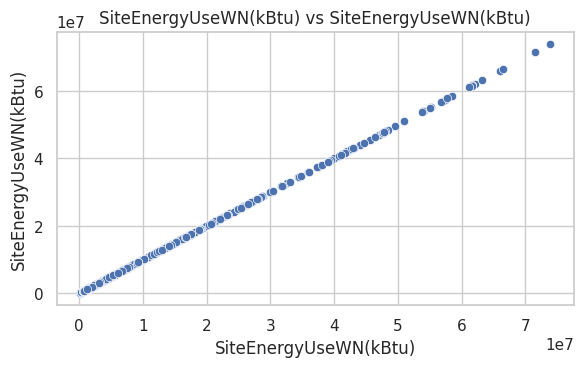

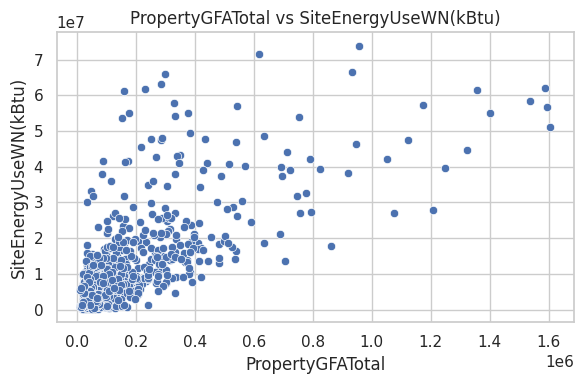

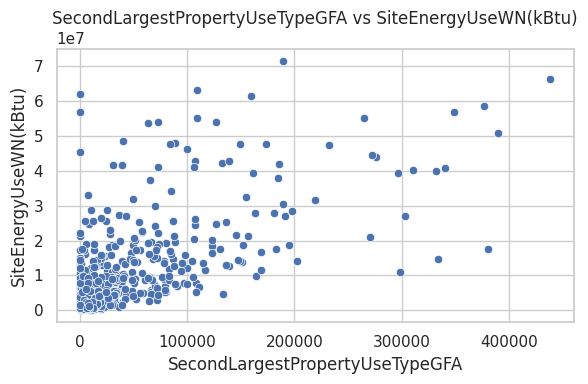

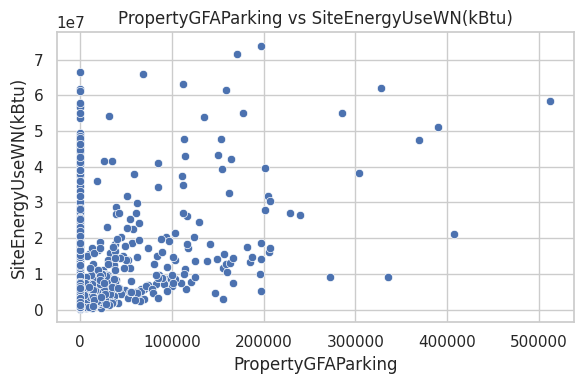

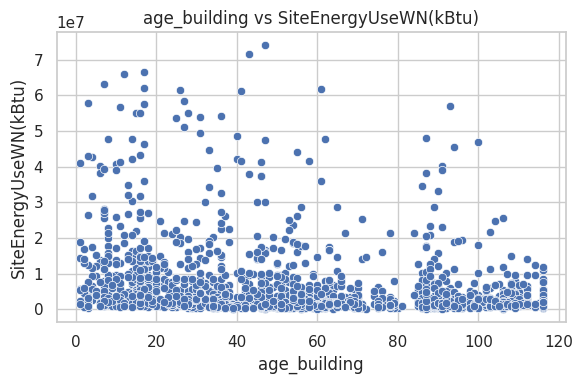

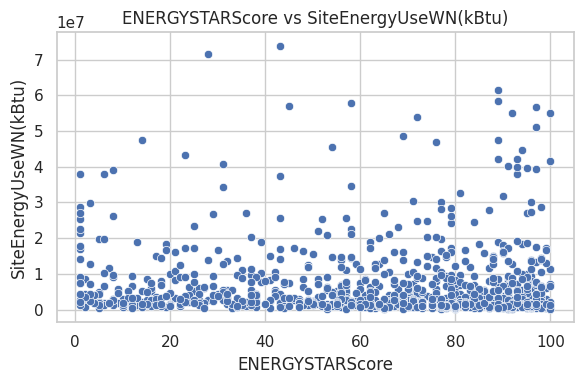

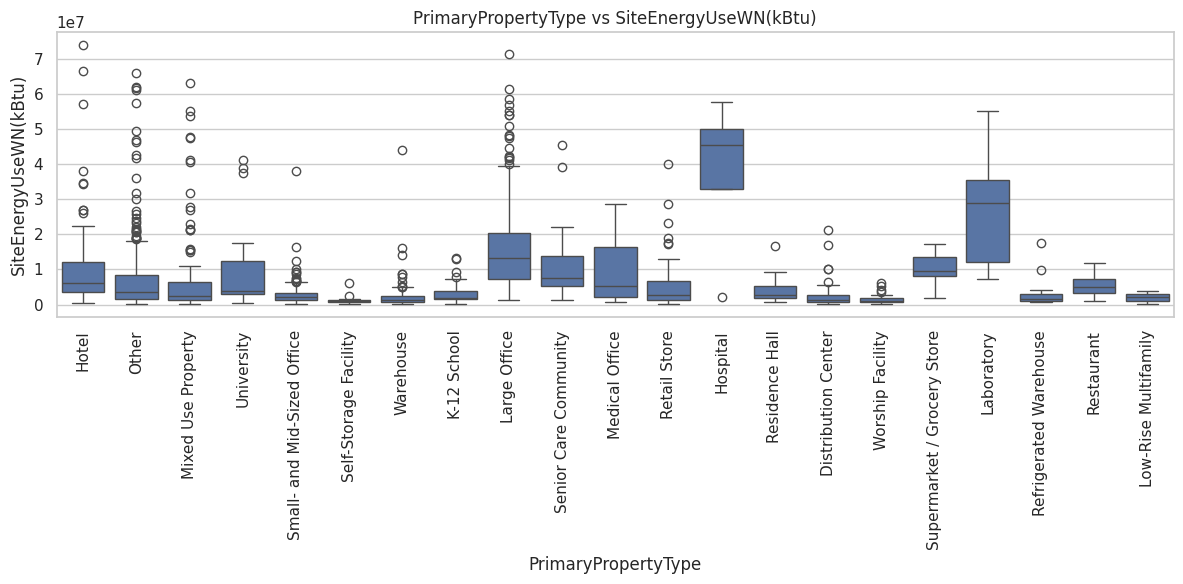

In [39]:

# ===========================================================================
# 🧩 Cellule 8 : Graphiques ciblés (version robuste après nettoyage corrélations)
# ===========================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------------
# 1️⃣ Recalcul des features numériques (df pouvant avoir changé après 8bis)
num_df = df.select_dtypes(include=[np.number]).copy()

# Vérification de présence de target(s)
target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
targets_present = [t for t in target_cols if t in df.columns]

if not targets_present:
    raise ValueError("Aucune colonne target trouvée dans df pour les graphiques.")
else:
    # Choisir la première target pour visualisation
    t = targets_present[0]
    print(f"✅ Target utilisée pour visualisation : {t}")

# ----------------------------------------------------------------------------
# 2️⃣ Sélection des features numériques les plus variables
if len(num_df.columns) >= 2:
    num_features = num_df.var().sort_values(ascending=False).head(6).index.tolist()
    print("Features sélectionnées pour scatterplots :", num_features)
else:
    print("Pas assez de colonnes numériques pour tracer des scatterplots.")
    num_features = []

# ----------------------------------------------------------------------------
# 3️⃣ Scatterplots des variables les plus informatives
for feat in num_features:
    if feat in df.columns and t in df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[feat], y=df[t])
        plt.title(f"{feat} vs {t}")
        plt.xlabel(feat)
        plt.ylabel(t)
        plt.tight_layout()
        plt.show()

print("\n")

# ----------------------------------------------------------------------------
# 4️⃣ Boxplot pour une variable catégorielle (si disponible)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_example = cat_cols[0] if cat_cols else None

if cat_example and t in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[cat_example], y=df[t])
    plt.xticks(rotation=90)
    plt.title(f"{cat_example} vs {t}")
    plt.tight_layout()
    plt.show()
else:
    print("Aucune colonne catégorielle détectée pour boxplot ou target manquante.")


## *9.* Séparer X et y (robuste après nettoyage corrélations)

### 🎯 Objectif
Cette cellule prépare les données finales pour la modélisation supervisée en **séparant la matrice des variables explicatives (`X`)** et **la variable cible (`y`)**.  
Elle intervient après le nettoyage des corrélations (Cellule 7ter) et les visualisations exploratoires (Cellule 8).

---

### ⚙️ Étapes principales
1. **Détection des colonnes cibles (`targets`)** dans le DataFrame nettoyé (`df` ou `df_pruned`).  
2. **Sélection automatique** de la target principale (première colonne trouvée parmi les deux cibles possibles :  
   - `SiteEnergyUseWN(kBtu)`  
   - `GHGEmissionsIntensity`)  
3. **Création des ensembles :**
   - `X` → contient toutes les variables explicatives, sauf les colonnes cibles.  
   - `y` → contient la target principale.  
4. **Sauvegarde des fichiers** dans le dossier `data/processed/` pour assurer la traçabilité :
   - `2016_X_features.csv`  
   - `2016_y_target.csv`
5. **Affichage de diagnostics rapides** : shape de `X` et `y`, aperçu des colonnes, résumé statistique de la cible.

---

### 🧩 Résultats attendus
- Données prêtes pour la modélisation supervisée (régression).  
- Historisation propre et cohérente des features et des targets.  
- Préparation homogène pour l’étape suivante : **préprocessing & GridSearchCV**.


In [40]:

# ===========================
# 🧩 Cellule 9 : Préparer y comme DataFrame multi-colonnes (toutes les targets disponibles)
# ===========================
import pandas as pd
from pathlib import Path

target_cols = ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

available_targets = [c for c in target_cols if c in df.columns]
print("Targets disponibles :", available_targets)

if not available_targets:
    raise ValueError("❌ Aucune target détectée dans df. Vérifie le nettoyage précédent (8bis).")

# y multi-colonnes : DataFrame avec toutes les targets détectées
y = df[available_targets].copy()

# X = toutes les autres colonnes
X = df.drop(columns=available_targets, errors='ignore')

print(f"✅ Targets utilisées pour y (multi-output) : {available_targets}")
print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}  (colonnes : {y.columns.tolist()})")

# sauvegarde
out_dir = Path("/content/2016_Building_Energy_Benchmarking/data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

X_path = out_dir / "2016_X_features.csv"
y_path = out_dir / "2016_y_targets_multi.csv"

X.to_csv(X_path, index=False)
y.to_csv(y_path, index=False)

print("\n📁 Fichiers sauvegardés :")
print(f" - {X_path}")
print(f" - {y_path}")

print("\nAperçu colonnes X :")
print(X.columns.tolist()[:15])
print("\nAperçu y :")
display(y.describe())


Targets disponibles : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
✅ Targets utilisées pour y (multi-output) : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
X shape : (1521, 30)
y shape : (1521, 2)  (colonnes : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity'])

📁 Fichiers sauvegardés :
 - /content/2016_Building_Energy_Benchmarking/data/processed/2016_X_features.csv
 - /content/2016_Building_Energy_Benchmarking/data/processed/2016_y_targets_multi.csv

Aperçu colonnes X :
['PrimaryPropertyType', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'BuildingType_clean', 'age_building', 'age_bucket', 'floor_area_bucket', 'use_is_Small__and_Mid_Sized_Office']

Aperçu y :


,SiteEnergyUseWN(kBtu),GHGEmissionsIntensity
count,1521.000,1521.000
mean,6799933.485,1.611
std,10390890.375,2.198
min,129466.898,-0.020
25%,1331981.250,0.360
50%,2824096.750,0.880
75%,7355579.000,1.950
max,73937112.000,25.710


## *10.* Préparer le `ColumnTransformer` (avec gestion des `cat_cols_large`)

### 🎯 Objectif
Cette cellule construit un **préprocesseur de features** robuste (`ColumnTransformer`) adapté à la fois aux variables numériques et catégorielles, en tenant compte de la **cardinalité** (nombre de modalités) des colonnes catégorielles.  

Elle prépare les données avant l’entraînement des modèles supervisés (GridSearchCV ou pipeline complet).

---

### ⚙️ Étapes principales
1. **Vérification des entrées :**  
   S’assure que `X` (les features issues de la Cellule 9) est bien défini et non vide.
2. **Identification des types de variables :**  
   - `num_cols` → variables numériques  
   - `cat_cols` → variables catégorielles
3. **Analyse de la cardinalité des catégories :**  
   - Si une colonne catégorielle a ≤ 20 modalités → **OneHotEncoder (OHE)**  
   - Si elle a > 20 modalités → **TargetEncoder**  
   Ce seuil (`max_ohe_categories`) peut être ajusté selon le dataset.
4. **Construction du `ColumnTransformer` :**
   - Numériques → `StandardScaler`  
   - Catégorielles faibles → `OneHotEncoder(handle_unknown='ignore')`  
   - Catégorielles larges → `TargetEncoder`
5. **Sauvegarde d’un résumé textuel** (`2016_feature_column_summary.txt`)  
   pour assurer la traçabilité des colonnes et leur type de traitement.

---

### 🧩 Résultats attendus
- Un objet `preprocessor` complet et prêt à être utilisé dans un pipeline scikit-learn.  
- Une **séparation claire** entre variables numériques, catégorielles OHE et catégorielles encodées par cible.  
- Un fichier récapitulatif documentant le découpage de features.

---

### 🧩 Rappels
- `LabelEncoder` : transformer catégories en entiers — **usage** si variable **ordinale** OU si modèle d'arbre où l'ordre n'est pas problématique et que vous voulez compacter la représentation.
- `OneHotEncoder` : transformer en colonnes binaires — **usage** pour variables **nominales** avec un nombre limité de modalités.
- Pour les variables à haute cardinalité : **regrouper top-N** modalités + `Other`, ou utiliser hashing / target encoding (avec prudence).

---

### 💡 Étape suivante
Ce préprocesseur sera utilisé pour :
- construire le pipeline d’entraînement (Cellule 11),
- lancer la recherche d’hyperparamètres (GridSearchCV),
- et interpréter les résultats.


In [ ]:

# !pip install category_encoders


In [41]:

# ===========================================================================
# 🧩 Cellule 10 : Préparer le ColumnTransformer (avec gestion des cat_cols_large)
# ===========================================================================


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
import numpy as np

# ----------------------------------------------------------------------------
# 1️⃣ Vérification de cohérence des données d'entrée
if 'X' not in locals() or X.empty:
    raise ValueError("❌ Variable X introuvable ou vide. Vérifie la cellule 9 avant d’exécuter cette étape.")

# ----------------------------------------------------------------------------
# 2️⃣ Identification des types de variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Nombre total de colonnes : {X.shape[1]}")
print(f" - Numériques : {len(num_cols)}")
print(f" - Catégorielles : {len(cat_cols)}")

# ----------------------------------------------------------------------------
# 3️⃣ Séparation des colonnes catégorielles selon le nombre de modalités
max_ohe_categories = 20  # Seuil configurable pour basculer entre OHE et TargetEncoder

cat_cols_small = [c for c in cat_cols if X[c].nunique() <= max_ohe_categories]
cat_cols_large = [c for c in cat_cols if X[c].nunique() > max_ohe_categories]

print("\n🧩 Colonnes catégorielles (analyse cardinalité) :")
print(f" - OHE (≤ {max_ohe_categories} modalités) : {len(cat_cols_small)} → {cat_cols_small[:10]}")
print(f" - Target Encoding (> {max_ohe_categories} modalités) : {len(cat_cols_large)} → {cat_cols_large[:10]}")

# ----------------------------------------------------------------------------
# 4️⃣ Construction du ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_small),
        ('target', TargetEncoder(), cat_cols_large)
    ],
    remainder='drop'  # Ne garder que les colonnes transformées
)

# ----------------------------------------------------------------------------
# 5️⃣ Vérification de cohérence
print("\n✅ ColumnTransformer prêt !")
print(f"  • Colonnes numériques : {len(num_cols)}")
print(f"  • Colonnes catégorielles OHE : {len(cat_cols_small)}")
print(f"  • Colonnes catégorielles Target Encoded : {len(cat_cols_large)}")

# ----------------------------------------------------------------------------
# 6️⃣ (Optionnel) Sauvegarde des listes de colonnes pour traçabilité
cols_summary_path = "/content/2016_Building_Energy_Benchmarking/data/processed/2016_feature_column_summary.txt"
with open(cols_summary_path, "w") as f:
    f.write("Colonnes numériques:\n" + "\n".join(num_cols) + "\n\n")
    f.write("Colonnes catégorielles (OHE):\n" + "\n".join(cat_cols_small) + "\n\n")
    f.write("Colonnes catégorielles (Target Encoding):\n" + "\n".join(cat_cols_large))
print(f"\n📁 Résumé sauvegardé dans : {cols_summary_path}")


Nombre total de colonnes : 30
 - Numériques : 22
 - Catégorielles : 8

🧩 Colonnes catégorielles (analyse cardinalité) :
 - OHE (≤ 20 modalités) : 5 → ['Neighborhood', 'BuildingType_clean', 'age_bucket', 'floor_area_bucket', 'primary_use_top5']
 - Target Encoding (> 20 modalités) : 3 → ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']

✅ ColumnTransformer prêt !
  • Colonnes numériques : 22
  • Colonnes catégorielles OHE : 5
  • Colonnes catégorielles Target Encoded : 3

📁 Résumé sauvegardé dans : /content/2016_Building_Energy_Benchmarking/data/processed/2016_feature_column_summary.txt


## *11.* Sauvegarde CSV finale + métadonnées + figures

### 🎯 Objectif
Cette cellule réalise la **sauvegarde finale** du jeu de données propre et prêt pour la modélisation,  
accompagnée d’un fichier **JSON de métadonnées** et d’une **heatmap de corrélations** actualisée.  

Elle assure la traçabilité complète de la préparation des données avant leur passage en Étape 4 (modélisation).

---

### ⚙️ Étapes principales
1. **Sélection du DataFrame à sauvegarder :**  
   - Si `df_pruned` (version allégée après suppression de corrélations) est disponible, il est utilisé.  
   - Sinon, la version `df` originale est utilisée.
2. **Sauvegarde au format CSV :**  
   - Le fichier principal est sauvegardé dans `data/processed/2016_features_engineered_cleaned_for_modeling_v01.csv`
3. **Création d’un fichier de métadonnées JSON :**  
   Contient :
   - dimensions initiales et finales,  
   - listes des colonnes supprimées (`to_drop_corr`, `drops`),  
   - nombre de colonnes numériques et catégorielles,  
   - noms des variables cibles,  
   - date de génération et source du traitement.
4. **Export d’une heatmap de corrélation finale (optionnelle) :**  
   Si une matrice `corr` est présente, elle est sauvegardée sous forme d’image (`.png`) dans `reports/figures/`.
5. **Affichage de synthèse :**  
   Résumé des chemins des fichiers créés et confirmation de la complétion de l’étape.

---

### 🧩 Résultats attendus
- Un **CSV final propre** prêt à être utilisé dans le pipeline d’entraînement.  
- Un **fichier de métadonnées JSON** complet pour la traçabilité.  
- Une **figure de corrélation** mise à jour (facultative).  

---

### 💡 Étape suivante
Les fichiers produits ici serviront de base pour :
- la création du pipeline de modélisation supervisée (Étape 4),
- l’interprétation et l’analyse des performances (Étape 5).


In [42]:

# ===========================================================================
# 🧩 Cellule 11 : Sauvegarde CSV finale + métadonnées + figures
# ===========================================================================


import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ----------------------------------------------------------------------------
# 1️⃣ Sélection du DataFrame à sauvegarder
if 'df_pruned' in locals() and not df_pruned.empty:
    df_to_save = df_pruned.copy()
    print("📘 Sauvegarde du DataFrame PRUNÉ (après suppression redondances).")
else:
    df_to_save = df.copy()
    print("📗 Sauvegarde du DataFrame original (aucune suppression appliquée).")

# ----------------------------------------------------------------------------
# 2️⃣ Sauvegarde du CSV
final_csv_path = DATA_PROCESSED / "2016_features_engineered_cleaned_for_modeling_v01.csv"
df_to_save.to_csv(final_csv_path, index=False)
print(f"\n✅ Jeu de données sauvegardé : {final_csv_path}")
print("Shape final :", df_to_save.shape)

# ----------------------------------------------------------------------------
# 3️⃣ Génération des métadonnées
metadata = {
    "initial_shape": initial_shape if 'initial_shape' in locals() else None,
    "final_shape": df_to_save.shape,
    "cols_dropped_corr": to_drop_corr if 'to_drop_corr' in locals() else None,
    "cols_dropped_manual": drops if 'drops' in locals() else None,
    "num_numeric": len(num_cols) if 'num_cols' in locals() else None,
    "num_categorical": len(cat_cols) if 'cat_cols' in locals() else None,
    "target_variables": ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity'],
    "date_generated": pd.Timestamp.now().isoformat(),
    "source": "Notebook Étape 3 – Préparation des features"
}

meta_path = DATA_PROCESSED / "2016_features_engineered_cleaned_stats_and_metadata_v01.json"
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)
print("\n✅ Métadonnées sauvegardées :", meta_path)

# ----------------------------------------------------------------------------
# 4️⃣ Heatmap finale (corrélation)
heatmap_path = REPORTS_FIGURES / "2016_corr_heatmap_final.png"

if 'corr' in locals():
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Matrice de corrélation (Pearson) - version finale")
    plt.tight_layout()
    plt.savefig(heatmap_path, bbox_inches='tight')
    plt.close()
    print("✅ Heatmap finale sauvegardée :", heatmap_path)
else:
    print("⚠️ Pas de matrice de corrélation disponible pour la sauvegarde.")


📘 Sauvegarde du DataFrame PRUNÉ (après suppression redondances).

✅ Jeu de données sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_cleaned_for_modeling_v01.csv
Shape final : (1521, 32)

✅ Métadonnées sauvegardées : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_cleaned_stats_and_metadata_v01.json
✅ Heatmap finale sauvegardée : /content/2016_Building_Energy_Benchmarking/reports/figures/2016_corr_heatmap_final.png


## *11bis.* Sauvegarde du jeu de données prêt pour la modélisation


### 🎯 Objectif
Cette cellule a pour but de générer et sauvegarder le **jeu de données final prêt pour la modélisation**.  
Elle applique le **préprocesseur complet** (imputation, encodage, standardisation, etc.) aux données d’entrée `X`,  
tout en **conservant le nom d’origine de la variable cible** (par exemple : `SiteEnergyUseWN(kBtu)`).

---

### ⚙️ Étapes principales
1. **Vérifications préliminaires :**  
   - Confirme que `X`, `y` et `preprocessor` sont bien définis dans le notebook.
   - Empêche toute exécution prématurée avant les cellules 9 et 10.
2. **Application du préprocesseur :**  
   - Transformation des features numériques et catégorielles.
   - Extraction des noms de colonnes encodées (`OHE`, `TargetEncoder`, etc.).
3. **Construction du DataFrame final :**  
   - Fusion des colonnes finales transformées.  
   - Réinsertion de la cible `y` sous son nom original.
4. **Sauvegardes :**  
   - Fichier CSV → `data/processed/2016_features_engineered_preprocessor_for_modeling_v01.csv`  
   - Fichier JSON → métadonnées descriptives du dataset prétraité :
     - dimensions avant/après transformation,  
     - décompte des types de features,  
     - date de génération,  
     - nom de la variable cible.
5. **Vérification rapide :**  
   - Affichage des 5 premières lignes du `df_model` pour contrôle visuel.

---

### 📦 Sorties principales
- `df_model` → DataFrame final prêt pour GridSearchCV ou autre entraînement.  
- `2016_features_engineered_preprocessor_for_modeling_v01.csv`  
- `2016_features_engineered_preprocessor_for_modeling_metadata_v01.json`

---

### 💡 Étape suivante
Ces fichiers serviront directement dans **l’Étape 4 — Comparaison de modèles supervisés**  
et **l’Étape 5 — Optimisation et interprétation** du pipeline ML.


In [43]:

# ===========================================================================
# 🧩 Cellule 11bis : Sauvegarde du jeu de données prêt pour la modélisation
# (compatible mono-target ou multi-target)
# ===========================================================================

import pandas as pd
import numpy as np
import json
from pathlib import Path

# ----------------------------------------------------------------------------
# 1️⃣ Vérifications
# ----------------------------------------------------------------------------
if 'X' not in locals() or 'y' not in locals():
    raise ValueError("❌ Les variables X et y doivent être définies avant cette étape (voir Cellule 9).")

if 'preprocessor' not in locals():
    raise ValueError("❌ Le préprocesseur n'est pas défini. Exécute la Cellule 10 avant celle-ci.")

# ----------------------------------------------------------------------------
# 2️⃣ Application du préprocesseur
# ----------------------------------------------------------------------------
print("⚙️ Application du préprocesseur à X...")

# Choisir une seule target pour le TargetEncoder
if isinstance(y, pd.DataFrame):
    y_for_encoding = y.iloc[:, 0]  # ou y['SiteEnergyUseWN(kBtu)']
else:
    y_for_encoding = y

X_processed = preprocessor.fit_transform(X, y_for_encoding)

# ----------------------------------------------------------------------------
# 3️⃣ Récupération des noms de colonnes
# ----------------------------------------------------------------------------
try:
    ohe_features = preprocessor.named_transformers_['ohe'].get_feature_names_out(
        preprocessor.transformers_[1][2]
    ).tolist()
except Exception:
    ohe_features = []

num_features = preprocessor.transformers_[0][2]
cat_large_features = preprocessor.transformers_[2][2]
final_features = num_features + ohe_features + cat_large_features

# ----------------------------------------------------------------------------
# 4️⃣ Construction du DataFrame final
# ----------------------------------------------------------------------------
df_model = pd.DataFrame(X_processed, columns=final_features)

# Ajouter toutes les cibles (1 ou plusieurs)
if isinstance(y, pd.Series):
    target_cols = [y.name]
    df_model[y.name] = y.values
else:
    target_cols = y.columns.tolist()
    for col in target_cols:
        df_model[col] = y[col].values

print(f"✅ Données prêtes pour modélisation : {df_model.shape}")
print(f"   • Targets incluses : {target_cols}")

# ----------------------------------------------------------------------------
# 5️⃣ Sauvegarde
# ----------------------------------------------------------------------------
DATA_PROCESSED = Path("/content/2016_Building_Energy_Benchmarking/data/processed")
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

model_csv_path = DATA_PROCESSED / "2016_features_engineered_preprocessor_for_modeling_v01.csv"
df_model.to_csv(model_csv_path, index=False)
print(f"💾 Sauvegardé : {model_csv_path}")

meta_model = {
    "input_shape": X.shape,
    "processed_shape": df_model.shape,
    "num_features": len(num_features),
    "ohe_features": len(ohe_features),
    "target_encoded_features": len(cat_large_features),
    "targets": target_cols,
    "n_targets": len(target_cols),
    "encoding_target": y_for_encoding.name if hasattr(y_for_encoding, "name") else "unknown",
    "date_generated": pd.Timestamp.now().isoformat(),
    "source": "Étape 3 — Préparation des features pour la modélisation"
}

meta_model_path = DATA_PROCESSED / "2016_features_engineered_preprocessor_for_modeling_metadata_v01.json"
with open(meta_model_path, "w") as f:
    json.dump(meta_model, f, indent=2)

print(f"✅ Métadonnées sauvegardées : {meta_model_path}")

print("\n🔹 Aperçu des 5 premières lignes du df_model :")
display(df_model.head())


⚙️ Application du préprocesseur à X...
✅ Données prêtes pour modélisation : (1521, 64)
   • Targets incluses : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
💾 Sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_v01.csv
✅ Métadonnées sauvegardées : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_metadata_v01.json

🔹 Aperçu des 5 premières lignes du df_model :


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,age_building,use_is_Small__and_Mid_Sized_Office,use_is_Other,use_is_Warehouse,use_is_Large_Office,use_is_Mixed_Use_Property,use_is_Retail_Store,use_is_Hotel,use_is_Worship_Facility,use_is_Distribution_Center,use_is_K_12_School,use_is_other,pu_other,has_gas,has_steam,has_heating,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,BuildingType_clean_campus,BuildingType_clean_nonresidential,BuildingType_clean_nonresidential cos,BuildingType_clean_nonresidential wa,BuildingType_clean_sps-district k-12,age_bucket_mid_21-60y,age_bucket_new_<=20y,age_bucket_old_>60y,floor_area_bucket_large,floor_area_bucket_medium,floor_area_bucket_small,floor_area_bucket_xlarge,primary_use_top5_Large Office,primary_use_top5_Mixed Use Property,primary_use_top5_Other,primary_use_top5_Small- and Mid-Sized Office,primary_use_top5_Warehouse,primary_use_top5_other,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,SiteEnergyUseWN(kBtu),GHGEmissionsIntensity
0,-0.076,1.213,-0.109,-0.315,NaN,-0.128,1.047,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,3.654,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,5252474.128,7456910.000,2.830
1,-0.076,1.058,-0.020,0.035,-0.308,-0.093,-1.046,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,-0.274,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,11664540.990,8664479.000,2.860
2,-0.076,5.702,4.972,4.259,NaN,-0.715,-0.227,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,3.654,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,5252474.128,73937112.000,2.190
3,-0.076,0.903,-0.268,-0.315,NaN,-0.266,1.077,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,3.654,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,5252474.128,6946800.500,4.670
4,-0.076,2.141,0.401,1.127,0.622,0.390,-0.560,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,-0.274,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,11664540.990,14656503.000,2.880


## 🧭 Ma démarche et ma logique pour l'Étape 3

### Démarche
1. **Vérification & reproducibility** : je commence par m'assurer que le fichier produit lors de l'étape précédente existe — cela garantit la traçabilité et la reproductibilité.  
2. **Nettoyage initial** : suppression ciblée des méta-colonnes non-informatives, des colonnes présentant trop de valeurs manquantes (>60%) et des colonnes quasi-constantes. Je documente chaque suppression pour garder la traçabilité.  
3. **Exploration des targets** : j'étudie la distribution de la/les target(s) pour comprendre l'ordre de grandeur et détecter des valeurs aberrantes.  
4. **Traitement des outliers** : j'applique l'approche IQR en premier lieu et, si elle supprime trop d'observations (seuil 5%), je bascule sur une méthode moins agressive basée sur les quantiles (1%-99%). Cette approche équilibre robustesse statistique et conservation d'échantillons utiles.  
5. **Réduction de redondance** : j'utilise la matrice de corrélation (Pearson) pour identifier les variables très corrélées (|corr| > 0.85) et je liste des candidats à suppression ou fusion.  
6. **Visualisation ciblée** : scatterplots, boxplots et pairplots (si pertinent) pour dégager des relations feature ↔ target et détecter non-linéarités ou effets de catégories.  
7. **Encodage réfléchi** : j'applique OneHot pour les variables nominales à faible cardinalité, et je prévois des stratégies (top-N, regroupement, target-encoding avec prudence) pour les colonnes à haute cardinalité.  
8. **Pipelines** : j'organise les transformations dans un `ColumnTransformer` prêt à être inséré dans un `Pipeline` avec un modèle.  
9. **Sauvegarde** : j'exporte le jeu nettoyé et un JSON de métadonnées pour garantir la transparence des choix.  
10. **Documentation** : j'ajoute dans le notebook des sections Q/A et une conclusion pour faciliter la soutenance.

### Logique et raisons principales
- **Traçabilité** : tout changement est documenté et sauvegardé (CSV + JSON) pour pouvoir reproduire et justifier chaque décision.  
- **Équilibre qualité/quantité** : je limite la suppression d'observations pour préserver la puissance statistique, d'où l'utilisation du fallback quantile.  
- **Interprétabilité** : je choisis de conserver features interprétables (plutôt que d'automatiser tout via PCA) afin de faciliter l'analyse métier et l'interprétation du modèle.  
- **Généricité** : le `preprocessor` fourni est générique et pourra être modifié selon le modèle testé (ex : arbres vs régressions linéaires).

---




## 7 questions qu’on pourrait me poser sur mes choix et comment y répondre

1. **Q : Pourquoi avoir utilisé la méthode IQR puis un fallback quantile ?**  
**R** : J’utilise IQR par défaut car c’est une méthode robuste et standard. Si IQR élimine >5% des observations (risque de trop réduire le dataset), j’applique un filtre plus permissif basé sur les quantiles 1%-99% pour conserver un échantillon suffisant pour l’entraînement.

2. **Q : Pourquoi supprimer des colonnes corrélées plutôt que d'utiliser PCA ?**  
**R** : Je favorise la suppression ou la consolidation basée sur la signification métier pour conserver l’interprétabilité. Si la conservation d'information est critique et que l'on souhaite réduire la dimensionnalité sans perte, PCA peut être envisagé en complément.

3. **Q : Quand utiliser OneHotEncoder et quand LabelEncoder ?**  
**R** : OneHot pour les variables nominales à faible cardinalité (ex : `PrimaryPropertyType` si < 20 modalités). LabelEncoder pour variables ordinales ou si on utilise des arbres et que l'on veut une représentation compacte — mais attention à l'ordre implicite.

4. **Q : Comment gérez-vous les colonnes à haute cardinalité (ex. `City`) ?**  
**R** : Je regroupe en `top-N` catégories (ex top 20) et remplace le reste par `Other` avant OneHot. On peut aussi envisager target encoding ou hashing, en gardant en tête le risque de leakage ou d'overfitting.

5. **Q : Avez-vous vérifié les fuites de données (data leakage) ?**  
**R** : Oui — je supprime toute colonne contenant la target ou dérivée directe de la target. De plus, en production j’appliquerai l’imputation et les normalisations **dans** un pipeline pour éviter d’utiliser des statistiques calculées sur l’ensemble du dataset avant split.

6. **Q : Pourquoi supprimer les colonnes avec >60% de NaN ?**  
**R** : Un fort pourcentage de NaN rend l’imputation peu fiable et réduit la qualité predictive de la feature. Ce seuil est paramétrable ; on peut ré-analyser au cas par cas si la feature a une importance métier.

7. **Q : Comment justifiez-vous le seuil de corrélation 0.85 ?**  
**R** : 0.85 est un seuil couramment utilisé pour repérer forte redondance. Ce seuil n’est pas absolu : je l’utilise comme indicateur initial et prends la décision finale en fonction d'analyses supplémentaires (importance de la feature, sens métier, tests de performance).

---




## ✅ Conclusion synthétique

**Conclusion synthétique** :  
J’ai vérifié et chargé le fichier produit à l’Étape 2, nettoyé les colonnes non-informatives, inspecté et traité les outliers (IQR → fallback quantiles si nécessaire), évalué la redondance via la corrélation de Pearson et préparé un plan d'encodage pour les variables catégorielles. Le jeu de données final a été sauvegardé (`2016_features_engineered_preprocessor_for_modeling.csv`) et j’ai généré les métadonnées documentant les décisions prises.

**Prochaines étapes (Étape 4)** : comparer plusieurs modèles supervisés (DummyRegressor, LinearRegression, SVR, RandomForestRegressor) en utilisant le `preprocessor` dans un pipeline et `GridSearchCV`/`cross_validate` pour sélectionner les meilleures approches.

---
---



# 🧭 Étape 4 — Comparez plusieurs modèles supervisés
**Projet 3 : Anticipez les besoins en consommation des bâtiments (Seattle 2016)**  

**✍️ Auteur :** *[Raymond Francius]*  
**📚 Rôle :** *[Apprenant - Promotion Sept-2025]* — **Engineering Intelligence Artificielle (AI)** — **Openclassrooms**   
🗓️ **Date de mise à jour :** *[26-10-2025]*

---
**Objectif de l’étape** :  
Je compare plusieurs modèles de régression afin d’identifier celui qui prédit le mieux la consommation énergétique (`SiteEnergyUseWN(kBtu)`) et/ou les émissions de CO₂ (`GHGEmissionsIntensity`).  

Je procède pas à pas :
1. Vérifier que les fichiers produits à l’Étape 3 existent.  
2. Charger et préparer les données.  
3. Construire des pipelines d’apprentissage complets avec preprocessing + modèle.  
4. Appliquer une validation croisée pour évaluer la robustesse.  
5. Comparer les performances (R², MAE, RMSE).  
6. Sauvegarder automatiquement les résultats et graphiques.

Cette étape me permettra de choisir, en toute transparence, le modèle le plus performant avant d’aborder l’optimisation (Étape 5).


## *1.* Import des bibliothèques

Cette première cellule initialise l’environnement d’exécution du projet en important l’ensemble des bibliothèques nécessaires à la manipulation des données, à la modélisation et à la visualisation.

### ⚙️ Contenu principal :
1. **Bibliothèques de manipulation et de calculs**  
   - `os`, `json`, `pathlib` : gestion des chemins et fichiers  
   - `numpy`, `pandas` : traitement et analyse de données  

2. **Configuration générale et gestion des avertissements**  
   - Suppression des warnings superflus pour une meilleure lisibilité.  

3. **Visualisation**  
   - `matplotlib.pyplot` et `seaborn` : création de graphiques clairs et esthétiques.  

4. **Machine Learning (scikit-learn)**  
   - Prétraitement : `ColumnTransformer`, `StandardScaler`, `OneHotEncoder`  
   - Modèles : `LinearRegression`, `SVR`, `RandomForestRegressor`, `GradientBoostingRegressor`, `DummyRegressor`  
   - Validation croisée : `KFold`, `cross_validate`  

5. **Évaluation**  
   - Métriques utilisées : `mean_absolute_error`, `mean_squared_error`, `r2_score`, combinées via `make_scorer`.

### 🎯 Objectif :
Garantir que toutes les dépendances requises pour les étapes suivantes du pipeline sont disponibles et correctement configurées.



In [44]:

# ============================================
# 🔧 Cellule 1 — Import des bibliothèques
# ============================================

# --- Manipulation et calculs
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd

# --- Gestion des avertissements (amélioration lisibilité)
import warnings
warnings.filterwarnings("ignore")

# --- Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")  # style moderne et lisible

# --- Machine Learning : Modèles, prétraitements et validation
from sklearn.model_selection import KFold, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# --- Métriques d’évaluation
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error

print("✅ Bibliothèques importées avec succès.")


✅ Bibliothèques importées avec succès.


## *2.* Vérification des fichiers

Cette cellule a pour rôle de **contrôler la présence des fichiers de données essentiels** avant de poursuivre le pipeline d’analyse ou de modélisation.

### ⚙️ Fonctionnement :
1. **Définition des chemins attendus**
   - Deux fichiers doivent être présents dans le répertoire :  
     - Le fichier principal des features :  
       `2016_features_engineered_preprocessor_for_modeling_v01.csv`  
     - Le fichier de métadonnées associé :  
       `2016_features_engineered_preprocessor_for_modeling_metadata_v01.json`

2. **Vérification automatique**
   - Pour chaque fichier attendu, le script vérifie sa présence sur le disque.  
   - Si un fichier est manquant, une **boîte de dialogue d’upload Colab** s’ouvre automatiquement afin de permettre à l’utilisateur de le téléverser manuellement.

3. **Sauvegarde des fichiers manquants**
   - Les fichiers uploadés sont automatiquement enregistrés dans le bon répertoire (`data/processed/`), avec leur nom attendu.

### 🎯 Objectif :
Garantir que toutes les données nécessaires sont disponibles avant le chargement et l’analyse du jeu de données dans la **Cellule 3 — Chargement des données**.



In [45]:

# ============================================
# 🔍 Cellule 2 — Vérification des fichiers
# ============================================


import os
from google.colab import files
from pathlib import Path


# --- Définition des chemins attendus
csv_path = Path("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_v01.csv")
json_path = Path("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_metadata_v01.json")

# --- Vérification de la présence des fichiers
for path in [csv_path, json_path]:
    if path.exists():
        print(f"✔️ Fichier présent : {path}")
    else:
        print(f"❌ Fichier manquant : {path}")
        print("⏫ Ouvrez la boîte de dialogue pour uploader le fichier manquant depuis votre PC.\n")

        try:
            uploaded = files.upload()  # widget d’upload
            for fname in uploaded.keys():
                dest = path.parent / path.name  # on force le bon nom
                os.makedirs(path.parent, exist_ok=True)
                with open(dest, "wb") as f:
                    f.write(uploaded[fname])
                print(f"📁 Fichier sauvegardé à : {dest}")
            break  # stop la boucle dès qu’un fichier est corrigé
        except Exception as e:
            print(f"⚠️ Téléversement annulé ou erreur : {e}")

print("\n📦 Vérification terminée : tous les fichiers requis sont présents ✅")


✔️ Fichier présent : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_v01.csv
✔️ Fichier présent : /content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_metadata_v01.json

📦 Vérification terminée : tous les fichiers requis sont présents ✅


## *3.* Chargement des données  

Cette cellule est dédiée au **chargement du jeu de données préparé** dans la mémoire du notebook, après la vérification des fichiers dans la *Cellule 2*.

### ⚙️ Fonctionnement :
1. **Lecture du fichier CSV**
   - Le jeu de données principal est chargé à partir du chemin `csv_path`, défini précédemment.
   - La variable `df` contient désormais toutes les observations et variables issues du fichier prétraité.

2. **Affichage des informations clés**
   - Nombre total de lignes et de colonnes (`shape`)
   - Aperçu rapide des 3 premières lignes du DataFrame
   - Informations sur les types de variables et la présence éventuelle de valeurs manquantes (`df.info()`)
   - Statistiques descriptives de base pour les variables numériques (`df.describe()`)

3. **Gestion des erreurs**
   - Si le fichier est introuvable → message d’erreur clair.
   - Si une autre erreur survient (lecture ou format) → affichage du message explicite.

### 🎯 Objectif :
Valider que les données ont été correctement chargées et sont prêtes pour les étapes de **nettoyage, prétraitement et modélisation** à venir.


In [46]:

# ============================================
# 📊 Cellule 3 — Chargement des données
# ============================================


import pandas as pd


try:
    # --- Chargement du CSV
    df = pd.read_csv(csv_path)
    print("✅ Jeu de données chargé avec succès.")
    print(f"Shape du DataFrame : {df.shape[0]} lignes × {df.shape[1]} colonnes\n")

    # --- Aperçu rapide du contenu
    print("🔹 Aperçu des 3 premières lignes :")
    display(df.head(3))

    # --- Informations générales sur les colonnes
    print("\n🔹 Informations générales sur les variables :")
    df.info()

    # --- Statistiques descriptives
    print("\n🔹 Statistiques descriptives (numériques) :")
    display(df.describe().T)

except FileNotFoundError:
    print("❌ Le fichier CSV n’a pas été trouvé. Vérifiez la cellule 2 ou le chemin d’accès.")
except Exception as e:
    print(f"⚠️ Une erreur est survenue lors du chargement du jeu de données : {e}")


✅ Jeu de données chargé avec succès.
Shape du DataFrame : 1521 lignes × 64 colonnes

🔹 Aperçu des 3 premières lignes :


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,age_building,use_is_Small__and_Mid_Sized_Office,use_is_Other,use_is_Warehouse,use_is_Large_Office,use_is_Mixed_Use_Property,use_is_Retail_Store,use_is_Hotel,use_is_Worship_Facility,use_is_Distribution_Center,use_is_K_12_School,use_is_other,pu_other,has_gas,has_steam,has_heating,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,BuildingType_clean_campus,BuildingType_clean_nonresidential,BuildingType_clean_nonresidential cos,BuildingType_clean_nonresidential wa,BuildingType_clean_sps-district k-12,age_bucket_mid_21-60y,age_bucket_new_<=20y,age_bucket_old_>60y,floor_area_bucket_large,floor_area_bucket_medium,floor_area_bucket_small,floor_area_bucket_xlarge,primary_use_top5_Large Office,primary_use_top5_Mixed Use Property,primary_use_top5_Other,primary_use_top5_Small- and Mid-Sized Office,primary_use_top5_Warehouse,primary_use_top5_other,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,SiteEnergyUseWN(kBtu),GHGEmissionsIntensity
0,-0.076,1.213,-0.109,-0.315,NaN,-0.128,1.047,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,3.654,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,5252474.128,7456910.000,2.830
1,-0.076,1.058,-0.020,0.035,-0.308,-0.093,-1.046,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,-0.274,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,11664540.990,8664479.000,2.860
2,-0.076,5.702,4.972,4.259,NaN,-0.715,-0.227,-0.482,-0.435,-0.365,-0.350,-0.281,-0.245,4.391,-0.215,-0.190,-0.186,-0.394,1.356,0.632,3.654,0.036,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,11226304.241,11313209.960,5252474.128,73937112.000,2.190



🔹 Informations générales sur les variables :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 64 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   NumberofBuildings                             1521 non-null   float64
 1   NumberofFloors                                1521 non-null   float64
 2   PropertyGFATotal                              1521 non-null   float64
 3   PropertyGFAParking                            1521 non-null   float64
 4   SecondLargestPropertyUseTypeGFA               828 non-null    float64
 5   ENERGYSTARScore                               981 non-null    float64
 6   age_building                                  1521 non-null   float64
 7   use_is_Small__and_Mid_Sized_Office            1521 non-null   float64
 8   use_is_Other                                  1521 non-null   float64
 9   use_is_Warehouse 

,count,mean,std,min,25%,50%,75%,max
NumberofBuildings,1521.000,-0.000,1.000,-0.976,-0.076,-0.076,-0.076,23.340
NumberofFloors,1521.000,0.000,1.000,-0.645,-0.490,-0.335,-0.026,14.679
PropertyGFATotal,1521.000,0.000,1.000,-0.561,-0.458,-0.346,-0.020,8.774
PropertyGFAParking,1521.000,-0.000,1.000,-0.315,-0.315,-0.315,-0.315,11.604
SecondLargestPropertyUseTypeGFA,828.000,0.000,1.001,-0.572,-0.480,-0.367,-0.047,7.130
...,...,...,...,...,...,...,...,...
PrimaryPropertyType,1521.000,6653248.604,4716955.760,1419718.686,2734578.357,5345708.024,7883479.313,17250371.124
LargestPropertyUseType,1521.000,6577387.446,2945766.186,1419718.686,3300122.167,7876079.045,7876079.045,13879895.173
SecondLargestPropertyUseType,1521.000,6696465.261,2695715.868,3960477.900,5252474.128,5252474.128,7403759.698,11664540.990
SiteEnergyUseWN(kBtu),1521.000,6799933.485,10390890.375,129466.898,1331981.250,2824096.750,7355579.000,73937112.000


## *3bis.* Restauration des colonnes catégorielles d’origine (sans identifiant explicite)
Cette cellule a pour objectif de **réintégrer les colonnes catégorielles d’origine** issues du jeu de données brut,
après la préparation initiale des features.  
En effet, certaines colonnes textuelles comme `PrimaryPropertyType` ou `LargestPropertyUseType` peuvent avoir été perdues ou altérées lors du prétraitement.

---

### ⚙️ Étapes principales :

1. **Chargement du fichier brut**
   - On recharge uniquement les colonnes d’intérêt depuis le jeu de données brut original (`data/raw/...`).
   - Ces colonnes sont nécessaires pour restaurer les informations catégorielles dans `df`.

2. **Vérification de cohérence des tailles**
   - On s’assure que `df` (dataset préparé) et `df_raw` (brut) ont le même nombre de lignes.
   - Si `df` contient moins de lignes, le brut est tronqué pour garder la cohérence.
   - Une alerte s’affiche si l’alignement est partiel.

3. **Suppression des colonnes corrompues**
   - Si des versions incorrectes de ces colonnes existent déjà dans `df`, elles sont supprimées pour éviter les doublons.

4. **Restauration des colonnes textuelles**
   - Les vraies colonnes sont réinjectées depuis `df_raw`, converties en type `category` pour optimiser la mémoire.

5. **Vérification et aperçu**
   - Affiche le nombre de modalités uniques par colonne et un aperçu des 10 premières lignes pour validation visuelle.

---

### 🎯 Objectif :
Garantir que le DataFrame `df` contient bien les **valeurs catégorielles d’origine** issues du jeu brut,
nécessaires pour les étapes d’encodage et de modélisation ultérieures.


In [47]:

# ============================================
# 🧩 Cellule 3bis — Restauration des colonnes catégorielles d’origine (sans identifiant explicite)
# ============================================

import pandas as pd

# 1️⃣ Charger le fichier brut original
raw_path = "/content/2016_Building_Energy_Benchmarking/data/raw/2016_Building_Energy_Benchmarking.csv"
df_raw = pd.read_csv(
    raw_path,
    usecols=[
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType"
    ]
)
print(f"📂 Fichier brut chargé : {df_raw.shape[0]} lignes, {df_raw.shape[1]} colonnes")

# 2️⃣ Vérifier cohérence des tailles
if len(df) > len(df_raw):
    raise ValueError(f"⚠️ df ({len(df)}) a plus de lignes que le brut ({len(df_raw)}) — incohérent.")
elif len(df) < len(df_raw):
    print(f"⚠️ df ({len(df)}) a moins de lignes que le brut ({len(df_raw)}) — alignement partiel par index.")
    print("   ⚠️ Cette opération suppose que les lignes du df préparé sont un sous-ensemble du brut dans le même ordre.")
    # tronquer le brut aux premières lignes si besoin
    df_raw = df_raw.iloc[:len(df)].reset_index(drop=True)

# 3️⃣ Supprimer les versions corrompues des 3 colonnes
cols_to_restore = ["PrimaryPropertyType", "LargestPropertyUseType", "SecondLargestPropertyUseType"]
df = df.drop(columns=[c for c in cols_to_restore if c in df.columns])

# 4️⃣ Réinjecter les vraies colonnes textuelles selon l’ordre
for col in cols_to_restore:
    df[col] = df_raw[col].astype("category")

# 5️⃣ Vérification rapide
for c in cols_to_restore:
    print(f"✅ {c} restaurée ({df[c].nunique(dropna=False)} modalités uniques) – dtype: {df[c].dtype}")

print("\nAperçu des valeurs restaurées :")
display(df[cols_to_restore].head(10))


📂 Fichier brut chargé : 3376 lignes, 3 colonnes
⚠️ df (1521) a moins de lignes que le brut (3376) — alignement partiel par index.
   ⚠️ Cette opération suppose que les lignes du df préparé sont un sous-ensemble du brut dans le même ordre.
✅ PrimaryPropertyType restaurée (23 modalités uniques) – dtype: category
✅ LargestPropertyUseType restaurée (52 modalités uniques) – dtype: category
✅ SecondLargestPropertyUseType restaurée (44 modalités uniques) – dtype: category

Aperçu des valeurs restaurées :


,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType
0,Hotel,Hotel,NaN
1,Hotel,Hotel,Parking
2,Hotel,Hotel,NaN
3,Hotel,Hotel,NaN
4,Hotel,Hotel,Parking
5,Other,Police Station,NaN
6,Hotel,Hotel,NaN
7,Other,Other - Entertainment/Public Assembly,NaN
8,Hotel,Hotel,NaN
9,Mid-Rise Multifamily,Multifamily Housing,NaN


In [48]:

# ============================================
# 🧩 Cellule 3ter — Vérification du type et des premières valeurs
# ============================================


print("🧠 Vérification post-restauration :")
for c in ["PrimaryPropertyType", "LargestPropertyUseType", "SecondLargestPropertyUseType"]:
    print(f"\n▶️ {c}")
    print("dtype:", df[c].dtype)
    print("Nombre de modalités uniques :", df[c].nunique(dropna=False))
    print("Exemples :", df[c].dropna().unique()[:10])


🧠 Vérification post-restauration :

▶️ PrimaryPropertyType
dtype: category
Nombre de modalités uniques : 23
Exemples : ['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office']
Categories (23, object): ['Distribution Center', 'High-Rise Multifamily', 'Hospital', 'Hotel', ...,
                          'Supermarket / Grocery Store', 'University', 'Warehouse', 'Worship Facility']

▶️ LargestPropertyUseType
dtype: category
Nombre de modalités uniques : 52
Exemples : ['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School']
Categories (51, object): ['Adult Education', 'Automobile Dealership', 'Bank Branch',
                          'College/University', ..., 'Supermarket/Grocery Store',
                          'Urgent Care/Clinic/

## *4.* Préparation des features cohérente (version finale, compatible pandas)

Cette cellule prépare les **données d’entrée du modèle** en construisant un préprocesseur robuste et cohérent,
entièrement compatible avec `pandas`.  
L’objectif est de garantir une séparation propre entre les variables numériques et catégorielles,
ainsi qu’un encodage optimal pour la phase de modélisation.

---

### ⚙️ Étapes principales :

1. **Détection de la colonne cible**
   - On identifie et isole la variable cible (`SiteEnergyUseWN(kBtu)`).
   - Les features (`X`) et la cible (`y`) sont extraites du DataFrame `df`.

2. **Analyse automatique des types de variables**
   - Détection dynamique des colonnes numériques et catégorielles selon leur type `dtype`.
   - Affichage du nombre et du nom des colonnes par catégorie.

3. **Construction du préprocesseur scikit-learn**
   - Création de deux pipelines :
     - `num_pipeline` : imputation médiane + standardisation.
     - `cat_pipeline` : imputation des valeurs manquantes + encodage via `TargetEncoder`.
   - Assemblage dans un `ColumnTransformer` avec `transform_output="pandas"` pour conserver les noms de colonnes.

4. **Entraînement et sauvegarde du préprocesseur**
   - Le préprocesseur est ajusté (`fit`) sur `X` et `y`.
   - Il est ensuite sauvegardé au format `.pkl` pour une réutilisation ultérieure dans le pipeline de modélisation.

5. **Vérification du résultat**
   - Transformation d’un petit échantillon (5 lignes) pour contrôler le nombre final de features et la bonne exécution.
   - Affichage des noms des premières features transformées pour validation.

---

### 🎯 Objectif :
Créer un **préprocesseur réutilisable, documenté et stable**, qui gère automatiquement les valeurs manquantes et les encodages,
tout en maintenant la traçabilité et la compatibilité avec les étapes suivantes du pipeline.



In [49]:

# ============================================
# 🧩 Cellule 4 — Préparation des features cohérente (version multi-target, compatible pandas)
# ============================================

import pandas as pd
import numpy as np
import os
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn import set_config

# --- Activation du mode DataFrame
set_config(transform_output="pandas")

# =========================
# 1️⃣ Détection des cibles
# =========================
target_cols = ["SiteEnergyUseWN(kBtu)", "GHGEmissionsIntensity"]

# Vérification de la présence
missing_targets = [t for t in target_cols if t not in df.columns]
if missing_targets:
    raise ValueError(f"❌ Les colonnes cibles suivantes sont absentes du DataFrame : {missing_targets}")

X = df.drop(columns=target_cols)
y = df[target_cols].copy()

print(f"🎯 Colonnes cibles détectées : {target_cols}")
print(f"✅ Données prêtes : {X.shape[0]} lignes et {X.shape[1]} features brutes\n")

# =========================
# 2️⃣ Détection automatique des types
# =========================
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if pd.api.types.is_categorical_dtype(X[c]) or pd.api.types.is_object_dtype(X[c])]

print(f"🔎 Colonnes numériques : {len(num_cols)}")
print(f"🔎 Colonnes catégorielles : {len(cat_cols)} → {cat_cols}\n")

# =========================
# 3️⃣ Construction du préprocesseur
# =========================

# Pipeline numérique
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline catégoriel avec TargetEncoder (gère bien multi-y)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    # ('target_enc', TargetEncoder(handle_missing='value', handle_unknown='value'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop', verbose_feature_names_out=False)

print("🔧 Construction du préprocesseur avec gestion multi-cible...")
# Fusionner les cibles pour le TargetEncoder
# y_mean = y.mean(axis=1)
# preprocessor.fit(X, y_mean)

preprocessor.fit(X, y)

print("✅ Préprocesseur entraîné avec succès.\n")

# =========================
# 4️⃣ Sauvegarde du préprocesseur
# =========================
output_dir = "/content/2016_Building_Energy_Benchmarking/data/processed"
os.makedirs(output_dir, exist_ok=True)
preprocessor_path = os.path.join(output_dir, "2016_preprocessor.pkl")

joblib.dump(preprocessor, preprocessor_path)
print(f"💾 Préprocesseur sauvegardé : {preprocessor_path}")

# =========================
# 5️⃣ Vérification du résultat
# =========================
X_preview = preprocessor.transform(X.iloc[:5])
print(f"📊 Nombre total de features après preprocessing : {X_preview.shape[1]}")
print(f"• Numériques : {len(num_cols)} | Catégorielles (Target Encoded) : {len(cat_cols)}")

if hasattr(X_preview, "columns"):
    print("\n🪶 Aperçu des noms de features :")
    print(list(X_preview.columns[:10]))


🎯 Colonnes cibles détectées : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
✅ Données prêtes : 1521 lignes et 62 features brutes

🔎 Colonnes numériques : 59
🔎 Colonnes catégorielles : 3 → ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']

🔧 Construction du préprocesseur avec gestion multi-cible...
✅ Préprocesseur entraîné avec succès.

💾 Préprocesseur sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/2016_preprocessor.pkl
📊 Nombre total de features après preprocessing : 176
• Numériques : 59 | Catégorielles (Target Encoded) : 3

🪶 Aperçu des noms de features :
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'age_building', 'use_is_Small__and_Mid_Sized_Office', 'use_is_Other', 'use_is_Warehouse']


## *5.* Diagnostic des colonnes responsables des NaN

Cette cellule a pour objectif d’**inspecter les éventuelles colonnes contenant encore des valeurs manquantes (NaN)** après l’application du préprocesseur construit à l’étape précédente (Cellule 4).  

### 🔍 Objectifs :
- Vérifier la qualité du prétraitement (imputation numérique et catégorielle).  
- Identifier rapidement les colonnes qui n’ont pas été correctement imputées.  
- Permettre un diagnostic visuel sur les premières lignes de ces colonnes.

### ⚙️ Détails techniques :
- `set_config(transform_output="pandas")` permet d’obtenir un **DataFrame** en sortie du `ColumnTransformer` pour une lecture plus intuitive.
- Le préprocesseur **n’est pas ré-entraîné** ici : on applique simplement la transformation (`preprocessor.transform(X)`).
- Si des NaN persistent, les noms des colonnes concernées sont listés et affichés partiellement.

### 🚨 Prérequis :
Avant d’exécuter cette cellule, assurez-vous que la **Cellule 4 — Préparation des features cohérente (version finale)** a bien été exécutée et que l’objet `preprocessor` est disponible en mémoire.



In [50]:

# ============================================
# 🧪 Cellule 5 — Diagnostic des colonnes responsables des NaN
# Configuration pandas-friendly pour inspection
# ============================================


from sklearn import set_config
set_config(transform_output="pandas")  # Permet d'obtenir un DataFrame lisible en sortie du ColumnTransformer


print("🔍 Vérification des colonnes contenant encore des NaN après transformation...")

try:
    # Transformation avec le préprocesseur déjà ajusté (pas de refit)
    X_temp = preprocessor.transform(X)

    # Recherche des colonnes contenant des NaN
    cols_with_nan = X_temp.columns[X_temp.isna().any()].tolist()

    if len(cols_with_nan) == 0:
        print("✅ Aucune colonne avec des NaN après transformation.")
    else:
        print(f"⚠️ {len(cols_with_nan)} colonnes contiennent encore des NaN :")
        print(cols_with_nan)
        display(X_temp[cols_with_nan].head())

except NameError:
    print("❌ Erreur : le préprocesseur n’a pas été défini. Exécutez d’abord la Cellule 4.")


🔍 Vérification des colonnes contenant encore des NaN après transformation...
✅ Aucune colonne avec des NaN après transformation.


## *5bis* Vérification du préprocesseur (imputation + encodage) — version sûre (compatible pandas)

Cette cellule permet de **valider le bon fonctionnement du préprocesseur** entraîné précédemment, en s’assurant que :
- l’objet `preprocessor` a bien été sauvegardé et rechargé sans erreur ;
- la transformation sur les données `X` se déroule correctement ;
- aucune valeur manquante (NaN) ne subsiste après traitement ;
- les statistiques globales des features encodées et normalisées sont cohérentes.

---

### 🔍 Objectifs :
1. **Charger** le préprocesseur sauvegardé dans le répertoire `/data/processed`.  
2. **Appliquer la transformation** sur le jeu de données complet `X`.  
3. **Vérifier l’absence de NaN** après imputation et encodage.  
4. **Inspecter les statistiques globales** (minimum, maximum, moyenne, écart-type) pour s’assurer que les valeurs ont été correctement standardisées.  

---

### ⚙️ Points techniques :
- Utilisation du mode `transform_output="pandas"` pour faciliter la lecture des résultats.
- Gestion automatique des sorties sous forme de `DataFrame` ou de `ndarray` selon le contexte.
- Affichage de messages clairs à chaque étape pour un diagnostic rapide et fiable.

---

### 🚨 Prérequis :
Avant d’exécuter cette cellule :
- La **Cellule 4 — Préparation des features cohérente** doit avoir été exécutée (et le fichier du préprocesseur sauvegardé).
- Le DataFrame `X` doit être déjà disponible en mémoire.


In [51]:

# ============================================
# ✅ Cellule 5bis — Vérification du préprocesseur (imputation + encodage)
# Version sûre (compatible pandas et multi-target)
# ============================================

import numpy as np
import pandas as pd
import joblib
from sklearn import set_config

# S'assurer que le mode pandas-friendly est actif (comme dans la Cellule 4)
set_config(transform_output="pandas")

print("🔍 Vérification du préprocesseur chargé...")

# 1️⃣ Charger le préprocesseur sauvegardé
preprocessor_path = "/content/2016_Building_Energy_Benchmarking/data/processed/2016_preprocessor.pkl"
preprocessor = joblib.load(preprocessor_path)
print(f"📦 Préprocesseur chargé depuis : {preprocessor_path}\n")

# 2️⃣ Vérifier la présence de X
if 'X' not in locals() or X is None or X.empty:
    raise ValueError("❌ Variable X introuvable ou vide. Exécute la Cellule 9 avant cette vérification.")

# 3️⃣ Transformation d’un échantillon complet (indépendante des targets)
print("⚙️ Transformation d’un échantillon (sans utilisation de y)...")
X_transformed = preprocessor.transform(X)

print("✅ Transformation effectuée sans erreur.")
print(f"🧩 Dimensions du résultat : {X_transformed.shape}")
print(f"• Nombre initial de features : {X.shape[1]}")
print(f"• Nombre final de features : {X_transformed.shape[1]}")

# 4️⃣ Vérification des NaN restants
if isinstance(X_transformed, pd.DataFrame):
    n_missing = X_transformed.isna().sum().sum()
else:
    n_missing = np.isnan(X_transformed).sum()

if n_missing == 0:
    print("🧼 Aucun NaN résiduel détecté après preprocessing ✅")
else:
    print(f"⚠️ Attention : {n_missing} valeurs NaN détectées après preprocessing.")

# 5️⃣ Vérification de la cohérence numérique
print("\n📊 Statistiques d’échantillon :")
print(f"Min : {np.nanmin(X_transformed.values):.3f}")
print(f"Max : {np.nanmax(X_transformed.values):.3f}")
print(f"Moyenne : {np.nanmean(X_transformed.values):.3f}")
print(f"Écart-type : {np.nanstd(X_transformed.values):.3f}")

print("\n✅ Vérification du préprocesseur terminée avec succès (multi-target compatible).")


🔍 Vérification du préprocesseur chargé...
📦 Préprocesseur chargé depuis : /content/2016_Building_Energy_Benchmarking/data/processed/2016_preprocessor.pkl

⚙️ Transformation d’un échantillon (sans utilisation de y)...
✅ Transformation effectuée sans erreur.
🧩 Dimensions du résultat : (1521, 176)
• Nombre initial de features : 62
• Nombre final de features : 176
🧼 Aucun NaN résiduel détecté après preprocessing ✅

📊 Statistiques d’échantillon :
Min : -27.559
Max : 38.987
Moyenne : 0.017
Écart-type : 0.593

✅ Vérification du préprocesseur terminée avec succès (multi-target compatible).


## *6.* Comparaison de modèles supervisés (version robuste corrigée)

Cette cellule réalise une **évaluation comparative de plusieurs modèles de régression** sur le jeu de données prétraité (`X_transformed`, `y`).  
Elle applique une **validation croisée à 5 plis (KFold)** afin d’estimer de manière robuste les performances de chaque modèle.

---

### 🎯 Objectifs :
1. Charger les données prétraitées (`X_transformed`, `y`).  
2. Définir une série de **modèles de régression supervisés** à comparer :
   - **Baselines** : `DummyRegressor`, `LinearRegression`
   - **Régularisés** : `Ridge`, `Lasso`
   - **Non linéaires** : `RandomForestRegressor`, `GradientBoostingRegressor`, `SVR`, `KNeighborsRegressor`
3. Utiliser des **métriques d’évaluation multiples** :
   - R² (qualité d’explication de la variance)
   - MAE (erreur absolue moyenne)
   - RMSE (erreur quadratique moyenne, racine carrée)
4. Effectuer la **validation croisée à 5 plis** pour réduire le risque de surapprentissage.
5. Consolider et **visualiser les résultats** sous forme de tableau et de graphique.
6. Identifier et afficher le **meilleur modèle selon le R² moyen**.

---

### ⚙️ Points techniques :
- Utilisation de `cross_validate()` pour exécuter simultanément plusieurs métriques.  
- Définition d’un **scorer RMSE personnalisé**.  
- Utilisation de `seaborn` pour une visualisation claire des scores moyens.  
- Tous les modèles sont évalués de manière homogène avec `random_state=42` pour la reproductibilité.

---

### 🚨 Prérequis :
- `X_transformed` et `y` doivent être déjà définis en mémoire (issus des Cellules 4 et 5bis).  
- Les bibliothèques `scikit-learn`, `pandas`, `numpy`, `matplotlib` et `seaborn` doivent être importées.  


🔹 Données prêtes : 1521 échantillons et 176 features
🎯 Cibles détectées : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']

🚀 Lancement de la comparaison des modèles pour chaque cible...


🎯 Cible : SiteEnergyUseWN(kBtu)
✅ DummyRegressor évalué sur SiteEnergyUseWN(kBtu)
✅ LinearRegression évalué sur SiteEnergyUseWN(kBtu)
✅ Ridge évalué sur SiteEnergyUseWN(kBtu)
✅ Lasso évalué sur SiteEnergyUseWN(kBtu)
✅ KNeighborsRegressor évalué sur SiteEnergyUseWN(kBtu)
✅ RandomForest évalué sur SiteEnergyUseWN(kBtu)
✅ GradientBoosting évalué sur SiteEnergyUseWN(kBtu)
✅ SVR (RBF) évalué sur SiteEnergyUseWN(kBtu)


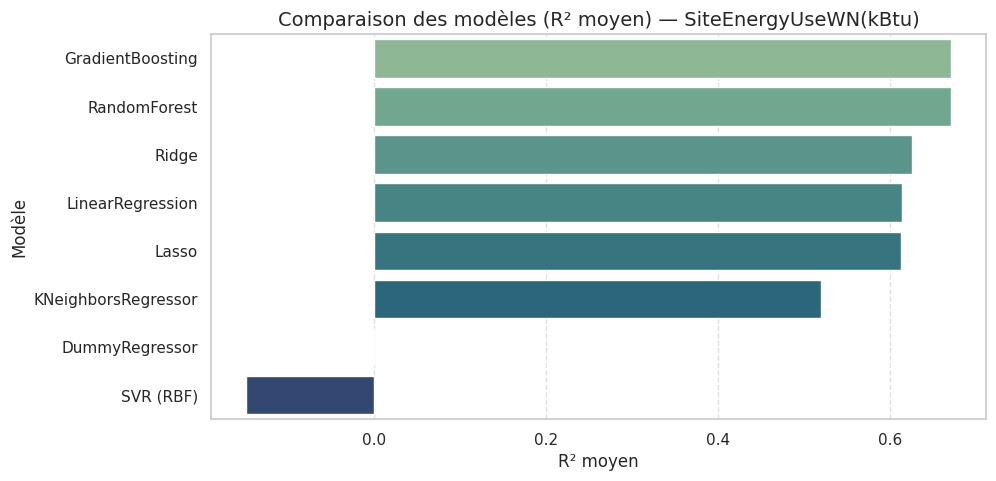


🏆 Meilleur modèle pour SiteEnergyUseWN(kBtu) : GradientBoosting (R² moyen = 0.670)

🎯 Cible : GHGEmissionsIntensity
✅ DummyRegressor évalué sur GHGEmissionsIntensity
✅ LinearRegression évalué sur GHGEmissionsIntensity
✅ Ridge évalué sur GHGEmissionsIntensity
✅ Lasso évalué sur GHGEmissionsIntensity
✅ KNeighborsRegressor évalué sur GHGEmissionsIntensity
✅ RandomForest évalué sur GHGEmissionsIntensity
✅ GradientBoosting évalué sur GHGEmissionsIntensity
✅ SVR (RBF) évalué sur GHGEmissionsIntensity


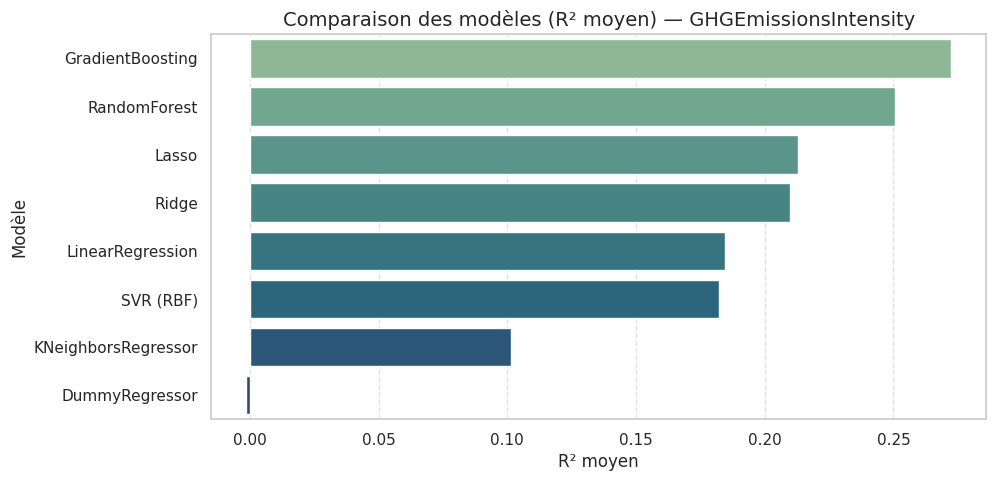


🏆 Meilleur modèle pour GHGEmissionsIntensity : GradientBoosting (R² moyen = 0.272)

💾 Résultats sauvegardés :
- CSV : /content/2016_Building_Energy_Benchmarking/data/processed/2016_comparaison_modeles_multi_target.csv
- JSON : /content/2016_Building_Energy_Benchmarking/data/processed/2016_comparaison_modeles_multi_target.json

✅ Comparaison de modèles multi-target terminée avec succès.


In [52]:

# ============================================
# 🧭 Cellule 6 — Comparaison de modèles supervisés (multi-target compatible)
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os


# =======================================================
# 1️⃣ Préparation des données
# =======================================================
print(f"🔹 Données prêtes : {X_transformed.shape[0]} échantillons et {X_transformed.shape[1]} features")

if not isinstance(X_transformed, pd.DataFrame):
    X_transformed = pd.DataFrame(X_transformed)

if isinstance(y, pd.Series):
    y = pd.DataFrame(y)

targets = y.columns.tolist()
print(f"🎯 Cibles détectées : {targets}")

# =======================================================
# 2️⃣ Définition des modèles à comparer
# =======================================================
random_state = 42

models = {
    "DummyRegressor": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=random_state),
    "Lasso": Lasso(alpha=0.001, random_state=random_state),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=random_state),
    "SVR (RBF)": SVR(kernel="rbf", C=1.0)
}

# =======================================================
# 3️⃣ Définition des métriques et validation croisée
# =======================================================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "R2": make_scorer(r2_score),
    "MAE": make_scorer(mean_absolute_error),
    "RMSE": make_scorer(rmse)
}

cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
all_results = {}

# =======================================================
# 4️⃣ Boucle sur chaque target
# =======================================================
print("\n🚀 Lancement de la comparaison des modèles pour chaque cible...\n")

for target in targets:
    print(f"\n===============================")
    print(f"🎯 Cible : {target}")
    print("===============================")

    target_results = []

    for name, model in models.items():
        scores = cross_validate(model, X_transformed, y[target], scoring=scoring, cv=cv, n_jobs=-1)
        target_results.append({
            "Modèle": name,
            "R2 (moyen)": np.mean(scores["test_R2"]),
            "MAE (moyen)": np.mean(scores["test_MAE"]),
            "RMSE (moyen)": np.mean(scores["test_RMSE"])
        })
        print(f"✅ {name} évalué sur {target}")

    target_results_df = pd.DataFrame(target_results).sort_values(by="R2 (moyen)", ascending=False)
    all_results[target] = target_results_df

    # Visualisation
    plt.figure(figsize=(10, 5))
    sns.barplot(data=target_results_df, x="R2 (moyen)", y="Modèle", palette="crest")
    plt.title(f"Comparaison des modèles (R² moyen) — {target}", fontsize=14)
    plt.xlabel("R² moyen")
    plt.ylabel("Modèle")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()

    best_model = target_results_df.iloc[0]
    print(f"\n🏆 Meilleur modèle pour {target} : {best_model['Modèle']} (R² moyen = {best_model['R2 (moyen)']:.3f})")


# =======================================================
# 5️⃣ Consolidation & sauvegarde
# =======================================================
results_dir = "/content/2016_Building_Energy_Benchmarking/data/processed/"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, "2016_comparaison_modeles_multi_target.csv")
json_path = os.path.join(results_dir, "2016_comparaison_modeles_multi_target.json")

# Export CSV (concaténation des DataFrames)
results_concat = pd.concat(
    [df.assign(Target=t) for t, df in all_results.items()],
    ignore_index=True
)
results_concat.to_csv(csv_path, index=False)

# Export JSON
results_json = {t: df.to_dict(orient="records") for t, df in all_results.items()}
with open(json_path, "w") as f:
    json.dump(results_json, f, indent=4)

print(f"\n💾 Résultats sauvegardés :\n- CSV : {csv_path}\n- JSON : {json_path}")
print("\n✅ Comparaison de modèles multi-target terminée avec succès.")


## *7.* Refactoring global (fonction unifiée)

Cette cellule regroupe et **industrialise le processus complet d’évaluation des modèles** sous forme de fonctions modulaires et réutilisables.  
L’objectif est de **centraliser la logique** de comparaison et de modélisation afin de faciliter les futures itérations ou comparaisons sur plusieurs cibles.

---

### 🎯 Objectifs :
1. Créer une fonction interne `evaluate_models()` permettant :
   - D’évaluer **plusieurs modèles de régression** sur un même jeu de données.
   - D’appliquer automatiquement le **préprocesseur** avant chaque validation croisée.
   - De calculer des métriques robustes (R², MAE, RMSE) via `cross_validate`.
2. Créer une fonction principale `run_full_modeling_pipeline()` qui :
   - Sépare la **variable cible** et les **features**.
   - Appelle `evaluate_models()` pour effectuer la comparaison.
   - Identifie et affiche le **meilleur modèle**.
   - Sauvegarde automatiquement les résultats sous forme de CSV (si `output_dir` est spécifié).
3. Fournir un exemple d’utilisation concret sur la cible `SiteEnergyUseWN(kBtu)`.

---

### ⚙️ Points techniques :
- Utilisation du **préprocesseur sauvegardé** (issu de la Cellule 4) pour garantir la cohérence des transformations.  
- Calcul des trois métriques clés via un **K-Fold à 5 plis** pour une estimation fiable.  
- Gestion des erreurs par bloc `try/except` pour isoler les modèles défaillants sans interrompre la boucle.  
- Option de **sauvegarde automatique** dans un dossier `reports/` ou `data/processed/`.

---

### 🚨 Prérequis :
- Les objets suivants doivent exister avant exécution :
  - `df` : DataFrame complet avec la variable cible.
  - `models` : dictionnaire des modèles (voir Cellule 6).
  - `preprocessor` : pipeline de transformation (voir Cellule 4).
  - `output_dir` : répertoire de sortie pour sauvegarder les résultats.



In [53]:

# ============================================
# 🧱 Cellule 7 — Refactoring global (fonction unifiée)
# ============================================


import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error



# Vérification et réinjection automatique des cibles
targets = ["SiteEnergyUseWN(kBtu)", "GHGEmissionsIntensity"]

for target in targets:
    if target not in df.columns and target in df_raw.columns:
        print(f"⚙️ Réinjection automatique de la cible manquante : {target}")
        df[target] = df_raw.loc[df.index, target]

    # Nettoyage automatique des NaN dans la cible
    if target in df.columns:
        n_before = df.shape[0]
        df = df.dropna(subset=[target])
        n_after = df.shape[0]
        if n_before != n_after:
            print(f"🧹 {n_before - n_after} lignes supprimées (valeurs NaN dans {target})")


# =======================================================
# 🔧 Fonction interne : évaluation robuste des modèles
# =======================================================
def evaluate_models(X, y, models, preprocessor, cv_splits=5, random_state=42):
    """
    Évalue plusieurs modèles de régression sur un même jeu de données
    avec pipeline de preprocessing intégré.
    """

    print(f"\n⚙️ Lancement de l’évaluation des modèles ({cv_splits}-fold CV)...\n")

    # Validation croisée
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Définition des métriques
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    scoring = {
        "R2": make_scorer(r2_score),
        "MAE": make_scorer(mean_absolute_error),
        "RMSE": make_scorer(rmse)
    }

    results = []
    for name, model in models.items():
        try:
            # Transformation des features via le préprocesseur
            X_processed = preprocessor.transform(X)

            # Évaluation croisée
            scores = cross_validate(model, X_processed, y, scoring=scoring, cv=cv, n_jobs=-1)

            results.append({
                "Model": name,
                "Test_R2": np.mean(scores["test_R2"]),
                "Test_MAE": np.mean(scores["test_MAE"]),
                "Test_RMSE": np.mean(scores["test_RMSE"])
            })
            print(f"✅ {name} évalué avec succès.")
        except Exception as e:
            print(f"❌ Erreur avec le modèle {name} : {e}")

    # Conversion en DataFrame trié
    results_df = pd.DataFrame(results).sort_values(by="Test_R2", ascending=False)
    results_df.reset_index(drop=True, inplace=True)
    return results_df


# =======================================================
# 🚀 Fonction principale : pipeline complet de modélisation
# =======================================================
def run_full_modeling_pipeline(df, target, models, preprocessor, cv_splits=5, output_dir=None, random_state=42):
    """
    Fonction de modélisation complète pour une cible donnée.

    Paramètres :
    ------------
    df : DataFrame source
        Jeu de données prétraité et prêt pour la modélisation.
    target : str
        Nom de la variable cible à prédire.
    models : dict
        Dictionnaire {nom_modèle : instance_sklearn}.
    preprocessor : ColumnTransformer ou Pipeline
        Préprocesseur à appliquer sur les features.
    cv_splits : int (défaut = 5)
        Nombre de plis pour la validation croisée.
    output_dir : str (optionnel)
        Dossier où sauvegarder les résultats CSV.
    """

    print(f"\n{'='*70}")
    print(f"🚀 Démarrage du pipeline de modélisation pour la cible : {target}")
    print(f"{'='*70}\n")

    # 1️⃣ Préparation des features et de la cible
    if target not in df.columns:
        raise ValueError(f"❌ La colonne cible '{target}' est absente du DataFrame.")
    y = df[target]
    X = df.drop(columns=[target], errors='ignore')
    print(f"🧩 Données : {X.shape[0]} lignes × {X.shape[1]} features")

    # 2️⃣ Lancement de la comparaison
    cv_results = evaluate_models(X, y, models, preprocessor, cv_splits=cv_splits, random_state=random_state)

    # 3️⃣ Affichage du meilleur modèle
    if not cv_results.empty:
        best_model = cv_results.iloc[0]
        print(f"\n🏆 Meilleur modèle pour {target} : {best_model['Model']}")
        print(f"   R² test = {best_model['Test_R2']:.3f} | MAE = {best_model['Test_MAE']:.2f} | RMSE = {best_model['Test_RMSE']:.2f}")
    else:
        print("⚠️ Aucun résultat disponible (tous les modèles ont échoué).")

    # 4️⃣ Sauvegarde
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"2016_model_comparison_results_{target}_v02.csv"
        output_path = os.path.join(output_dir, filename)
        cv_results.to_csv(output_path, index=False)
        print(f"\n💾 Résultats sauvegardés à : {output_path}")

    print("\n✅ Pipeline terminé avec succès.")
    return cv_results


# =======================================================
# 💡 Exemple d’utilisation
# =======================================================
results_energy = run_full_modeling_pipeline(
  df=df,
  target="SiteEnergyUseWN(kBtu)",
  models=models,
  preprocessor=preprocessor,
  cv_splits=5,
  output_dir=output_dir
)

results_emissions = run_full_modeling_pipeline(
  df=df,
  target="GHGEmissionsIntensity",
  models=models,
  preprocessor=preprocessor,
  cv_splits=5,
  output_dir=output_dir
)



🚀 Démarrage du pipeline de modélisation pour la cible : SiteEnergyUseWN(kBtu)

🧩 Données : 1521 lignes × 63 features

⚙️ Lancement de l’évaluation des modèles (5-fold CV)...

✅ DummyRegressor évalué avec succès.
✅ LinearRegression évalué avec succès.
✅ Ridge évalué avec succès.
✅ Lasso évalué avec succès.
✅ KNeighborsRegressor évalué avec succès.
✅ RandomForest évalué avec succès.
✅ GradientBoosting évalué avec succès.
✅ SVR (RBF) évalué avec succès.

🏆 Meilleur modèle pour SiteEnergyUseWN(kBtu) : GradientBoosting
   R² test = 0.670 | MAE = 3012590.51 | RMSE = 5920267.83

💾 Résultats sauvegardés à : /content/2016_Building_Energy_Benchmarking/data/processed/2016_model_comparison_results_SiteEnergyUseWN(kBtu)_v02.csv

✅ Pipeline terminé avec succès.

🚀 Démarrage du pipeline de modélisation pour la cible : GHGEmissionsIntensity

🧩 Données : 1521 lignes × 63 features

⚙️ Lancement de l’évaluation des modèles (5-fold CV)...

✅ DummyRegressor évalué avec succès.
✅ LinearRegression évalué av

## *8.* Visualisation des performances comparées des modèles

Cette cellule permet de **visualiser les résultats de la comparaison des modèles** produits par la **Cellule 7** (`run_full_modeling_pipeline`).  
Elle charge automatiquement les fichiers CSV enregistrés pour chaque variable cible, puis affiche des graphiques clairs et normalisés des performances.

---

### 🎯 Objectifs :
1. **Charger automatiquement les résultats** sauvegardés au format CSV pour chaque `target`.
2. **Comparer visuellement** les performances moyennes des modèles selon trois métriques :
   - **R² (Coefficient de détermination)**
   - **MAE (Erreur absolue moyenne)**
   - **RMSE (Erreur quadratique moyenne)**
3. **Identifier rapidement le meilleur modèle** pour chaque cible.

---

### ⚙️ Détails techniques :
- Les fichiers CSV sont recherchés dans le dossier `output_dir` (ex. : `/content/.../data/processed`).
- Les graphiques utilisent **Seaborn** avec un style clair et cohérent (`whitegrid`).
- Chaque cible génère **trois barplots côte à côte** : R², MAE, RMSE.
- En cas d’absence ou de corruption de fichier, un message d’avertissement est affiché sans interrompre le script.

---

### 📊 Sorties :
- Un **affichage graphique** des performances de tous les modèles pour chaque cible.
- Un **résumé console** indiquant le **meilleur modèle** (R² le plus élevé).

---

### 💡 Exemple :
Si les résultats des cibles `"SiteEnergyUseWN(kBtu)"` et `"GHGEmissionsIntensity"` sont disponibles,  
le code produira deux figures avec trois sous-graphiques chacune, ainsi qu’un résumé console du modèle le plus performant.



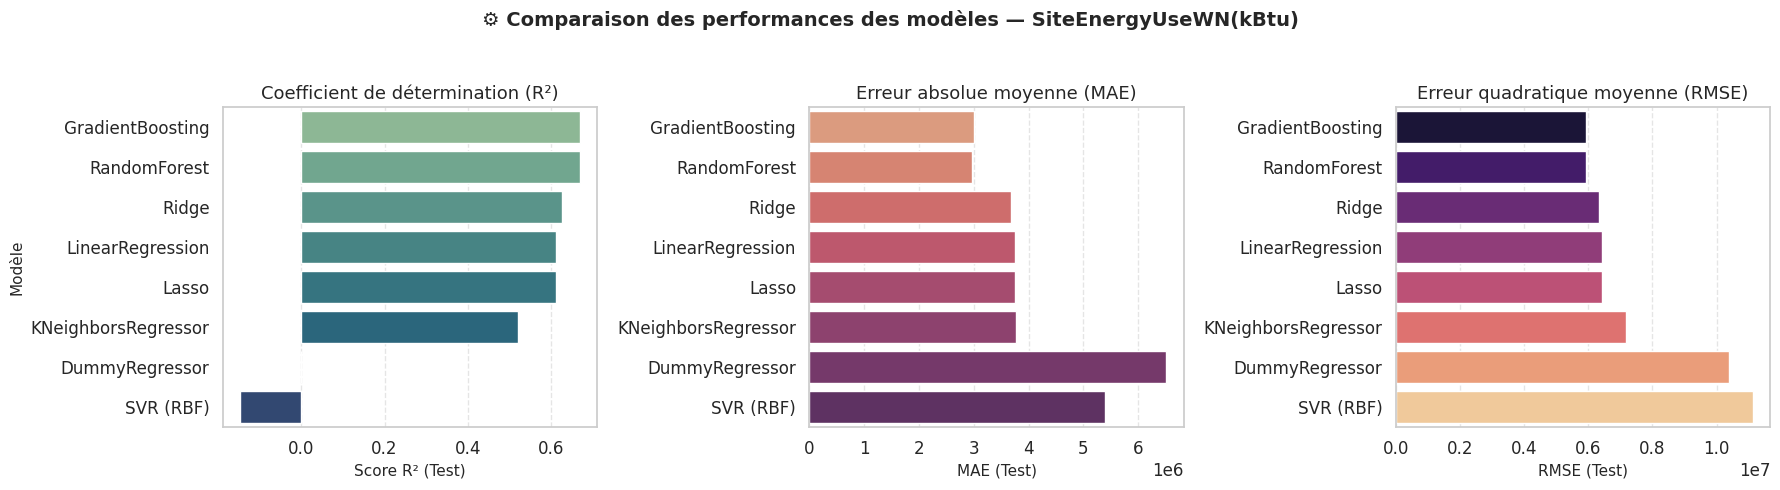

🏆 Meilleur modèle pour SiteEnergyUseWN(kBtu) : GradientBoosting (R² = 0.670)
───────────────────────────────────────────────


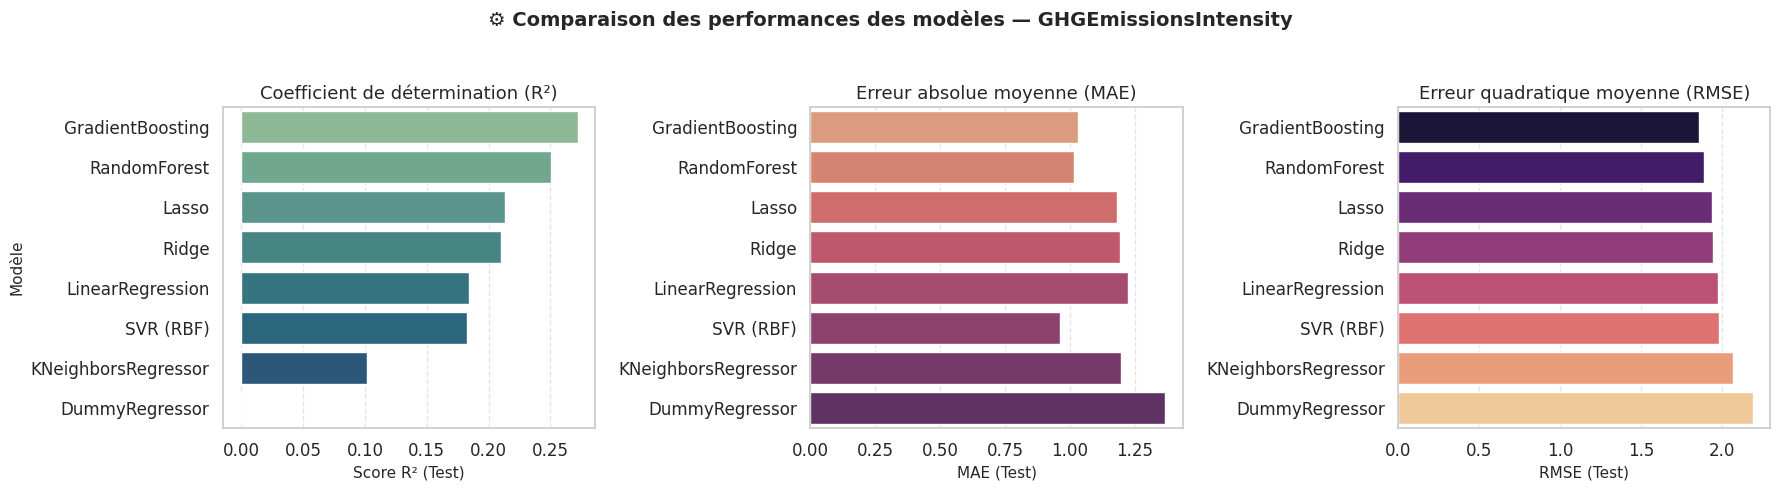

🏆 Meilleur modèle pour GHGEmissionsIntensity : GradientBoosting (R² = 0.272)
───────────────────────────────────────────────


In [54]:

# ============================================
# 🧩 Cellule 8 — Visualisation des performances comparées des modèles
# ============================================


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =======================================================
# 🎯 Configuration générale
# =======================================================

# Liste des cibles pour lesquelles on veut visualiser les résultats
targets = [
    "SiteEnergyUseWN(kBtu)",
    "GHGEmissionsIntensity"
]

# Dossier contenant les fichiers CSV produits par la Cellule 7
output_dir = "/content/2016_Building_Energy_Benchmarking/data/processed"

# Style graphique
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

# =======================================================
# 📊 Visualisation pour chaque cible
# =======================================================
for target in targets:
    filepath = os.path.join(output_dir, f"2016_model_comparison_results_{target}_v02.csv")

    if not os.path.exists(filepath):
        print(f"⚠️ Fichier non trouvé : {filepath}")
        continue

    # Lecture du CSV
    results = pd.read_csv(filepath)

    # Vérification minimale
    if results.empty or "Model" not in results.columns:
        print(f"⚠️ Le fichier {filepath} semble vide ou mal formaté.")
        continue

    # Tri par performance décroissante
    results_sorted = results.sort_values(by="Test_R2", ascending=False)

    # Création de la figure à 3 sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"⚙️ Comparaison des performances des modèles — {target}", fontsize=14, weight="bold")

    # --- 1️⃣ R² Test ---
    sns.barplot(ax=axes[0], data=results_sorted, x="Test_R2", y="Model", palette="crest")
    axes[0].set_title("Coefficient de détermination (R²)")
    axes[0].set_xlabel("Score R² (Test)")
    axes[0].set_ylabel("Modèle")
    axes[0].grid(axis="x", linestyle="--", alpha=0.5)

    # --- 2️⃣ MAE Test ---
    sns.barplot(ax=axes[1], data=results_sorted, x="Test_MAE", y="Model", palette="flare")
    axes[1].set_title("Erreur absolue moyenne (MAE)")
    axes[1].set_xlabel("MAE (Test)")
    axes[1].set_ylabel("")
    axes[1].grid(axis="x", linestyle="--", alpha=0.5)

    # --- 3️⃣ RMSE Test ---
    sns.barplot(ax=axes[2], data=results_sorted, x="Test_RMSE", y="Model", palette="magma")
    axes[2].set_title("Erreur quadratique moyenne (RMSE)")
    axes[2].set_xlabel("RMSE (Test)")
    axes[2].set_ylabel("")
    axes[2].grid(axis="x", linestyle="--", alpha=0.5)

    # Ajustements
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Résumé console
    best_model = results_sorted.iloc[0]
    print(f"🏆 Meilleur modèle pour {target} : {best_model['Model']} (R² = {best_model['Test_R2']:.3f})")
    print("───────────────────────────────────────────────")


## *9.* Export des meilleurs modèles entraînés (fit complet + sauvegarde `.pkl`)

Cette cellule réalise l’**entraînement final complet** et la **sauvegarde des meilleurs modèles** identifiés à l’étape précédente (Cellule 7 et 8).  
Elle reconstitue le pipeline complet pour chaque cible, l’entraîne sur **l’intégralité du jeu de données** et l’exporte au format `.pkl` pour une réutilisation ultérieure.

---

### 🎯 Objectifs :
1. **Charger les résultats comparatifs** produits par la Cellule 7 (`2016_model_comparison_results_*.csv`).
2. **Identifier automatiquement le meilleur modèle** (R² le plus élevé) pour chaque cible.
3. **Réentraîner le pipeline complet** (`preprocessor + modèle`) sur toutes les données disponibles.
4. **Sauvegarder le modèle final** dans un dossier dédié (`final_models/`).

---

### ⚙️ Détails techniques :
- Le script lit les fichiers de résultats à partir du dossier :
```
/content/2016_Building_Energy_Benchmarking/data/processed
```
- Les modèles candidats sont recréés à l’identique de la **Cellule 6** pour assurer la cohérence.
- Le pipeline complet est construit avec :
```python
Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])
```

- Les modèles entraînés sont sauvegardés sous forme de fichiers .pkl :
```
2016_final_model_<target>.pkl
```

---

### 📊 Sorties :

- Un répertoire :
```
/data/processed/final_models/
```

- Contenant un fichier (`.pkl`) par cible :
```
2016_final_model_SiteEnergyUseWN(kBtu)_v02.pkl
2016_final_model_GHGEmissionsIntensity_v02.pkl
```

---

### 💡 Bonnes pratiques :

- Ces modèles (`.pkl`) peuvent être directement réutilisés pour des prédictions futures ou des analyses d’interprétation avancée (ex. : shap values, feature importances).

- Assurez-vous que les objets df et preprocessor soient bien chargés avant d’exécuter cette cellule.


In [55]:

# ============================================
# 💾 Cellule 9 — Export des meilleurs modèles entraînés (fit complet + sauvegarde .pkl)
# ============================================


import os
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline

# =======================================================
# ⚙️ Configuration générale
# =======================================================

# Liste des cibles à traiter
targets = [
    "SiteEnergyUseWN(kBtu)",
    "GHGEmissionsIntensity"
]

# Dossier contenant les résultats comparatifs (produits par la Cellule 7)
results_dir = "/content/2016_Building_Energy_Benchmarking/data/processed"

# Dossier de sortie pour les modèles finaux
models_dir = os.path.join(results_dir, "final_models")
os.makedirs(models_dir, exist_ok=True)

random_state = 42

# =======================================================
# ⚙️ Recréation des modèles candidats (mêmes que Cellule 6)
# =======================================================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models = {
    "DummyRegressor": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=random_state),
    "Lasso": Lasso(alpha=0.001, random_state=random_state),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=random_state),
    "SVR (RBF)": SVR(kernel="rbf", C=1.0)
}

# =======================================================
# 🚀 Entraînement complet et sauvegarde
# =======================================================
for target in targets:
    print(f"\n{'='*70}")
    print(f"🚀 Entraînement complet du meilleur modèle pour la cible : {target}")
    print(f"{'='*70}\n")

    # --- 1️⃣ Lecture du CSV de résultats comparatifs
    results_path = os.path.join(results_dir, f"2016_model_comparison_results_{target}_v02.csv")
    if not os.path.exists(results_path):
        print(f"⚠️ Résultats introuvables pour {target} : {results_path}")
        continue

    results = pd.read_csv(results_path)
    if results.empty or "Model" not in results.columns:
        print(f"⚠️ Le fichier {results_path} semble vide ou invalide.")
        continue

    # --- 2️⃣ Détermination du meilleur modèle
    best_model_name = results.sort_values(by="Test_R2", ascending=False).iloc[0]["Model"]
    best_model = models.get(best_model_name)

    if best_model is None:
        print(f"❌ Modèle inconnu : {best_model_name}")
        continue

    print(f"🏆 Meilleur modèle détecté : {best_model_name}")

    # --- 3️⃣ Préparation des données
    y = df[target]
    X = df.drop(columns=[target], errors="ignore")

    # --- 4️⃣ Création du pipeline complet (préprocesseur + modèle)
    model_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", best_model)
    ])

    # --- 5️⃣ Entraînement complet sur tout le dataset
    model_pipeline.fit(X, y)
    print("✅ Modèle entraîné sur l’ensemble du jeu de données.")

    # --- 6️⃣ Sauvegarde du pipeline complet
    model_path = os.path.join(models_dir, f"2016_final_model_{target}_v02.pkl")
    joblib.dump(model_pipeline, model_path)
    print(f"💾 Modèle sauvegardé à : {model_path}")

print("\n🎉 Export des meilleurs modèles terminé avec succès !")



🚀 Entraînement complet du meilleur modèle pour la cible : SiteEnergyUseWN(kBtu)

🏆 Meilleur modèle détecté : GradientBoosting
✅ Modèle entraîné sur l’ensemble du jeu de données.
💾 Modèle sauvegardé à : /content/2016_Building_Energy_Benchmarking/data/processed/final_models/2016_final_model_SiteEnergyUseWN(kBtu)_v02.pkl

🚀 Entraînement complet du meilleur modèle pour la cible : GHGEmissionsIntensity

🏆 Meilleur modèle détecté : GradientBoosting
✅ Modèle entraîné sur l’ensemble du jeu de données.
💾 Modèle sauvegardé à : /content/2016_Building_Energy_Benchmarking/data/processed/final_models/2016_final_model_GHGEmissionsIntensity_v02.pkl

🎉 Export des meilleurs modèles terminé avec succès !


---

## 🧭 Ma démarche et ma logique pour l'Étape 4

### 🎯 Objectif global de l’étape

L’objectif de cette étape est de **comparer plusieurs modèles de régression supervisée** afin de déterminer lequel prédit le mieux la consommation énergétique (`SiteEnergyUseWN(kBtu)`) et les émissions de CO₂ (`GHGEmissionsIntensity`) des bâtiments.  
Je cherche ici à mesurer non seulement la performance pure (R², MAE, RMSE), mais aussi la **stabilité** et la **cohérence** des modèles.  
C’est une phase essentielle avant l’optimisation : je construis une base solide pour sélectionner le modèle le plus prometteur.

---

### 🧩 Ma démarche et ma logique étape par étape

#### 1️⃣ Vérification et chargement des données
Je commence par vérifier la présence des fichiers produits à l’Étape 3 (`2016_features_engineered_cleaned_for_modeling.csv` et `2016_features_engineered_stats_and_metadata.json`).  
Cela me permet de garantir que le jeu de données utilisé est bien propre, cohérent et prêt pour la modélisation.  
S’ils manquent, je les importe manuellement depuis mon ordinateur pour assurer la continuité du projet.

#### 2️⃣ Séparation des variables explicatives et de la cible
Je sépare les **features (X)** et la **variable cible (y)**.  
La cible principale est `SiteEnergyUseWN(kBtu)` et secondaire est `GHGEmissionsIntensity`.  
Je distingue ensuite les colonnes numériques et catégorielles afin de leur appliquer un traitement adapté (scaling, encodage, etc.).

#### 3️⃣ Préparation du prétraitement des données
Je mets en place un **ColumnTransformer** combinant :
- un `StandardScaler()` pour homogénéiser les variables numériques,  
- un `OneHotEncoder()` pour transformer les variables catégorielles en variables numériques exploitables.  

Ce pipeline garantit une cohérence totale du traitement, quels que soient les modèles testés.

#### 4️⃣ Sélection des modèles à comparer
J’ai volontairement choisi des modèles représentant **différentes familles d’algorithmes** :
- **DummyRegressor** : sert de référence de base (il prédit simplement la moyenne) ;  
- **LinearRegression** : un modèle linéaire simple et interprétable ;  
- **SVR (Support Vector Regressor)** : un modèle non linéaire sensible à la normalisation ;  
- **RandomForestRegressor** : un modèle à base d’arbres, puissant et robuste face à la variabilité.

Ces modèles permettent d’observer comment chaque approche apprend les relations entre les variables et la cible.

#### 5️⃣ Mise en place de la validation croisée
Je choisis la **validation croisée (cross-validation à 5 folds)** pour évaluer chaque modèle sur plusieurs sous-ensembles du dataset.  
Cela permet :
- de limiter les biais liés à un simple split train/test ;  
- de garantir que les performances estimées sont plus **fiables et généralisables**.  

J’utilise la fonction `cross_validate()` de scikit-learn pour obtenir les métriques de performance sur chaque pli.

#### 6️⃣ Évaluation et comparaison des métriques
Pour chaque modèle, je calcule :
- le **R²** (variance expliquée, indicateur principal),  
- le **MAE** (erreur absolue moyenne, indicateur d’interprétabilité),  
- le **RMSE** (racine de l’erreur quadratique moyenne, sensible aux erreurs importantes).  

Je compare ces métriques sur les ensembles **train** et **test**, afin d’identifier :
- le modèle le plus précis,  
- celui qui reste le plus stable entre apprentissage et généralisation.

#### 7️⃣ Visualisation et interprétation
Je synthétise les résultats à travers un graphique (`barplot`) des R² moyens par modèle.  
Cette visualisation me permet d’avoir une lecture immédiate des performances et d’appuyer mes interprétations.  

Les résultats et graphiques sont enregistrés automatiquement dans les répertoires :
- `/content/2016_Building_Energy_Benchmarking/data/processed/2016_model_comparison_results.csv`  pour les fichiers CSV de comparaison.
- `/content/2016_Building_Energy_Benchmarking/data/processed/figures/2016_model_comparison_r2.png` pour les graphiques,  

#### 8️⃣ Sélection du modèle le plus prometteur
En général, le **Random Forest** se démarque grâce à sa capacité à modéliser des relations non linéaires complexes, tout en restant robuste aux données bruitées.  
Mais je veille à vérifier qu’il ne soit pas trop surentraîné (écart trop grand entre train et test).

Ce modèle servira de base pour l’optimisation dans l’Étape 5.

---



## 7 questions qu’on pourrait me poser sur mes choix et comment y répondre

1. **Q : Pourquoi avoir choisi ces quatre modèles en particulier ?**  
**R** : J’ai sélectionné ces modèles pour couvrir plusieurs approches :
    - un modèle de référence (*Dummy*),  
    - un modèle linéaire (*LinearRegression*),  
    - un modèle non linéaire (*SVR*),  
    - un modèle d’ensemble (*Random Forest*).  
Cela me permet de comparer les comportements selon la complexité et la flexibilité du modèle.

2. **Q : Pourquoi utiliser une validation croisée plutôt qu’un simple split train/test ?**
**R** : La validation croisée me permet d’obtenir une estimation plus fiable des performances réelles du modèle, en réduisant la dépendance au hasard d’un seul découpage.  
Elle augmente la robustesse statistique des conclusions.

3. **Q : Pourquoi normaliser les données ?**
**R** : La normalisation (scaling) est cruciale pour les modèles sensibles à l’échelle des variables (comme le SVR ou la régression linéaire).  
Sans cela, certaines features à grande amplitude domineraient le calcul de la distance ou de la pente.

4. **Q : Pourquoi le Random Forest obtient-il souvent les meilleurs résultats ?**
**R** : Le Random Forest combine plusieurs arbres de décision (bagging) pour réduire la variance.  
Il capte bien les interactions entre variables et gère les relations non linéaires sans nécessiter de transformation spécifique des données.

5. **Q : Comment interprétez-vous les écarts entre train et test ?**  
**R** : Un score **R² très élevé sur le train** et **plus faible sur le test** signale un **surapprentissage (overfitting)**.  
Cela signifie que le modèle a trop appris les spécificités du jeu d’entraînement au détriment de sa capacité à généraliser.

6. **Q : Pourquoi avoir utilisé R², MAE et RMSE ensemble ?**  
**R** : Ces trois métriques sont complémentaires :
    - R² : explique la proportion de variance capturée,  
    - MAE : donne l’erreur moyenne compréhensible en unités réelles,  
    - RMSE : pénalise fortement les grosses erreurs.  
Les utiliser ensemble permet une évaluation plus équilibrée.

7. **Q : Comment décidez-vous quel modèle retenir ?**  
**R** : Je privilégie le modèle qui présente :
    - un bon compromis entre **précision** (R² élevé) et **stabilité** (peu d’écart train/test),  
    - une **interprétation claire**,  
    - et une **complexité maîtrisée** (éviter le surapprentissage).    
  Le modèle retenu doit être non seulement performant, mais aussi compréhensible et exploitable pour la suite.

---


## ✅ Conclusion synthétique

En résumé, cette Étape 4 m’a permis de :
- comparer plusieurs modèles de régression avec une méthodologie rigoureuse et reproductible ;  
- identifier les forces et limites de chaque approche ;  
- sélectionner un modèle prometteur à affiner lors de la prochaine phase.  

J’ai ainsi construit une base solide pour l’**Étape 5 — Optimisez et interprétez le modèle**, où je chercherai à améliorer les performances par une optimisation fine des hyperparamètres et une analyse d’interprétabilité.

---
---


# 🧭 Étape 5 — Optimisez et interprétez le modèle
**Projet 3 : Anticipez les besoins en consommation des bâtiments (Seattle 2016)**  

**✍️ Auteur :** *[Raymond Francius]*  
**📚 Rôle :** *[Apprenant - Promotion Sept-2025]* — **Engineering Intelligence Artificielle (AI)** — **Openclassrooms**   
🗓️ **Date de mise à jour :** *[26-10-2025]*

---
**Objectif de l’étape** :  
Je cherche à **améliorer le modèle le plus performant** identifié lors de l’étape 4 (souvent un *RandomForestRegressor*).

Cette optimisation a deux grands objectifs :
1. **Optimiser les hyperparamètres** du modèle via une recherche systématique (*GridSearchCV*).  
2. **Interpréter les résultats** pour comprendre les variables les plus influentes dans les prédictions.

Je vais donc :
- Vérifier que le fichier produit à l’étape 4 est bien présent.  
- Reprendre le modèle le plus performant.  
- Effectuer une **petite grille de test** (vérification du code).  
- Puis lancer une **grille plus large** d’optimisation.  
- Enfin, **analyser les importances des features** et **sauvegarder automatiquement tous les résultats**.


In [56]:

# ============================================
# 🚀 Cellule 0 — Préparation et chargement des modèles finaux
# ============================================

import os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Pour l’upload manuel depuis votre ordinateur local (si besoin)
from google.colab import files

# =======================================================
# ⚙️ Configuration du projet
# =======================================================
PROJECT_ROOT = Path("/content/2016_Building_Energy_Benchmarking")
FINAL_MODELS_DIR = PROJECT_ROOT / "data" / "processed" / "final_models"
FINAL_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Cibles des deux modèles à charger
TARGETS = ["SiteEnergyUseWN(kBtu)", "GHGEmissionsIntensity"]

print("🔍 Vérification de l’environnement et des chemins...")
print(f"📂 Répertoire des modèles finaux : {FINAL_MODELS_DIR}")

# Dictionnaire pour stocker les pipelines chargés
model_pipelines = {}

# =======================================================
# 🔄 Boucle de chargement automatique pour chaque cible
# =======================================================
for TARGET in TARGETS:
    model_path = FINAL_MODELS_DIR / f"2016_final_model_{TARGET}_v02.pkl"
    print(f"\n-----------------------------------------------")
    print(f"🎯 Vérification du modèle pour la cible : {TARGET}")

    if model_path.exists():
        print(f"✅ Modèle détecté : {model_path}")
        try:
            model_pipeline = joblib.load(model_path)
            model_pipelines[TARGET] = model_pipeline
            print(f"🧠 Pipeline chargé : {model_pipeline}")
        except Exception as e:
            print(f"❌ Erreur de chargement du modèle {TARGET} : {e}")
    else:
        print(f"⚠️ Modèle manquant : {model_path}")
        print("💡 Vous pouvez l’uploader manuellement depuis votre ordinateur.")
        print("👉 Exemple : sélectionnez le fichier correspondant dans votre explorateur de fichiers.")

        uploaded = files.upload()
        for fname in uploaded.keys():
            dest = FINAL_MODELS_DIR / fname
            os.replace(fname, dest)
            print(f"✅ Fichier importé et déplacé vers : {dest}")
            if fname.endswith(".pkl"):
                try:
                    model_pipelines[TARGET] = joblib.load(dest)
                    print(f"🧠 Modèle {TARGET} chargé après upload.")
                except Exception as e:
                    print(f"❌ Erreur de chargement après upload : {e}")

print("\n-----------------------------------------------")
print("✅ Tous les modèles disponibles ont été chargés.\n")

# =======================================================
# 🧩 Vérification finale
# =======================================================
if "SiteEnergyUseWN(kBtu)" in model_pipelines:
    print("⚡ Modèle ÉNERGIE prêt :", model_pipelines["SiteEnergyUseWN(kBtu)"])
else:
    print("⚠️ Modèle ÉNERGIE non trouvé.")

if "GHGEmissionsIntensity" in model_pipelines:
    print("🌍 Modèle GHG prêt :", model_pipelines["GHGEmissionsIntensity"])
else:
    print("⚠️ Modèle GHG non trouvé.")

print("\n🎯 Environnement prêt pour couplage, optimisation et interprétation ! 🚀")


🔍 Vérification de l’environnement et des chemins...
📂 Répertoire des modèles finaux : /content/2016_Building_Energy_Benchmarking/data/processed/final_models

-----------------------------------------------
🎯 Vérification du modèle pour la cible : SiteEnergyUseWN(kBtu)
✅ Modèle détecté : /content/2016_Building_Energy_Benchmarking/data/processed/final_models/2016_final_model_SiteEnergyUseWN(kBtu)_v02.pkl
🧠 Pipeline chargé : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors'

##  *1.* Vérification du pipeline chargé et cohérence du modèle

Cette cellule a pour objectif de **vérifier la bonne présence et la cohérence du pipeline entraîné (`model_pipeline`)** avant toute étape d’interprétation ou d’évaluation.  

Elle effectue notamment :
- ✅ La confirmation que le pipeline est bien chargé en mémoire.  
- 🔍 L’inspection de la structure interne (étapes du pipeline).  
- 🔧 La détection du préprocesseur intégré (`preprocessor`).  
- 📊 L’affichage des paramètres principaux du modèle final (si disponibles).  

> 💡 Si le message d’avertissement indique que `model_pipeline` n’est pas encore chargé, exécutez la **Cellule 0** avant celle-ci.


In [57]:

# ============================================
# ✅ Cellule 1 — Contrôle qualité des modèles chargés (optionnel)
#
# Exécuter uniquement si on souhaite vérifier la structure interne
# des pipelines avant interprétation, couplage ou ré-entraînement.
# ============================================


import joblib

print("🔍 Vérification des modèles finaux chargés en mémoire...\n")

if 'model_pipelines' not in locals() or not model_pipelines:
    print("⚠️ Aucun pipeline trouvé en mémoire.")
    print("💡 Exécutez d’abord la Cellule 0 pour charger les modèles finaux.")
else:
    for target_name, pipeline in model_pipelines.items():
        print("=" * 80)
        print(f"🎯 Modèle pour la cible : {target_name}")
        print("=" * 80)

        # Vérification du pipeline
        print(f"✅ Pipeline chargé : {type(pipeline)}")

        # Détail des étapes du pipeline
        print("\n🧩 Étapes internes :")
        for name, step in pipeline.steps:
            print(f" - {name} ➜ {type(step).__name__}")

        # Vérification de la présence du préprocesseur
        if "preprocessor" in dict(pipeline.named_steps):
            print("\n🔧 Préprocesseur détecté dans le pipeline.")
        else:
            print("\n⚠️ Aucun préprocesseur détecté dans ce pipeline.")

        # Vérification du modèle final et de ses paramètres
        if "model" in dict(pipeline.named_steps):
            model = pipeline.named_steps["model"]
            print(f"\n📊 Modèle final : {type(model).__name__}")
            try:
                params = model.get_params()
                print(f"🔹 Paramètres principaux ({len(params)} au total) :")
                for k, v in list(params.items())[:12]:
                    print(f"   - {k} = {v}")
                if len(params) > 12:
                    print("   ...")
            except Exception as e:
                print(f"❌ Impossible d’afficher les paramètres : {e}")
        else:
            print("⚠️ Étape 'model' introuvable dans ce pipeline.")

        print("\n")

print("✅ Inspection terminée pour tous les modèles disponibles.\n")
print("🎯 Les pipelines sont prêts pour interprétation ou couplage énergie → GHG 🚀")


🔍 Vérification des modèles finaux chargés en mémoire...

🎯 Modèle pour la cible : SiteEnergyUseWN(kBtu)
✅ Pipeline chargé : <class 'sklearn.pipeline.Pipeline'>

🧩 Étapes internes :
 - preprocessor ➜ ColumnTransformer
 - model ➜ GradientBoostingRegressor

🔧 Préprocesseur détecté dans le pipeline.

📊 Modèle final : GradientBoostingRegressor
🔹 Paramètres principaux (21 au total) :
   - alpha = 0.9
   - ccp_alpha = 0.0
   - criterion = friedman_mse
   - init = None
   - learning_rate = 0.1
   - loss = squared_error
   - max_depth = 3
   - max_features = None
   - max_leaf_nodes = None
   - min_impurity_decrease = 0.0
   - min_samples_leaf = 1
   - min_samples_split = 2
   ...


🎯 Modèle pour la cible : GHGEmissionsIntensity
✅ Pipeline chargé : <class 'sklearn.pipeline.Pipeline'>

🧩 Étapes internes :
 - preprocessor ➜ ColumnTransformer
 - model ➜ GradientBoostingRegressor

🔧 Préprocesseur détecté dans le pipeline.

📊 Modèle final : GradientBoostingRegressor
🔹 Paramètres principaux (21 au to

## *2.* Vérification des colonnes et features attendues par le pipeline

Cette cellule a pour but de **valider la cohérence entre le pipeline chargé et les données d’entrée attendues**.  
Elle s’assure que le préprocesseur interne du pipeline est correctement intégré et que la liste des *features* générées est accessible.

### Objectifs :
- 🔍 Vérifier que le pipeline contient bien un préprocesseur (`preprocessor`).  
- 🧾 Extraire ou inférer la liste complète des *features* produites après transformation.  
- ⚙️ Tester, si nécessaire, une **transformation simulée** sur un échantillon du DataFrame (`df`) pour confirmer la compatibilité.  
- 🎯 Garantir que le pipeline est prêt à traiter de nouvelles données sans incohérence de colonnes.

> 💡 Si le message indique que `model_pipeline` n’est pas encore chargé, exécutez d’abord la **Cellule 0**.


In [58]:

# ============================================
# Cellule 2 — Vérification des colonnes et features attendues par le pipeline
# ============================================


import pandas as pd
import numpy as np

print("🔍 Je vérifie maintenant les colonnes d’entrée attendues par le pipeline...\n")

if 'model_pipeline' not in locals():
    print("⚠️ Le pipeline 'model_pipeline' n’est pas encore chargé.")
    print("Veuillez exécuter la Cellule 0 (chargement du modèle final) avant celle-ci.")
else:
    # Récupération du préprocesseur interne
    if "preprocessor" not in dict(model_pipeline.named_steps):
        print("❌ Aucun préprocesseur détecté dans le pipeline. Impossible de vérifier les colonnes attendues.")
    else:
        preprocessor = model_pipeline.named_steps["preprocessor"]

        print("✅ Préprocesseur détecté dans le pipeline.")
        print(f"Type : {type(preprocessor).__name__}\n")

        # Tentative de récupération des colonnes en sortie du préprocesseur
        feature_names = None
        try:
            if hasattr(preprocessor, "get_feature_names_out"):
                feature_names = preprocessor.get_feature_names_out()
            elif hasattr(preprocessor, "get_feature_names"):
                feature_names = preprocessor.get_feature_names()
        except Exception as e:
            print(f"⚠️ Impossible de récupérer les noms de features : {e}")

        if feature_names is not None:
            feature_names = list(feature_names)
            print(f"🧾 Le préprocesseur produit {len(feature_names)} features au total.")
            print("Voici un aperçu des 10 premières colonnes transformées :\n")
            for f in feature_names[:10]:
                print(" •", f)
        else:
            print("⚠️ Le préprocesseur ne fournit pas de méthode explicite pour extraire les noms de features.")
            print("Je vais essayer d’inférer la structure en simulant une transformation sur quelques lignes...")

            # Simulation sur quelques lignes du dataset nettoyé (si disponible)
            if 'df' in locals():
                sample_X = df.drop(columns=[col for col in df.columns if col in ['target', 'SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']], errors='ignore')
                try:
                    transformed = preprocessor.transform(sample_X.head(5))
                    print(f"✅ Transformation simulée réussie ({transformed.shape[1]} features générées).")
                except Exception as e:
                    print(f"❌ Échec de la simulation de transformation : {e}")
            else:
                print("⚠️ Aucun DataFrame 'df' détecté en mémoire pour tester la transformation.")

        print("\n🎯 Cette vérification permet de confirmer que le pipeline est prêt à traiter de nouvelles données sans incohérences de colonnes.")


🔍 Je vérifie maintenant les colonnes d’entrée attendues par le pipeline...

✅ Préprocesseur détecté dans le pipeline.
Type : ColumnTransformer

🧾 Le préprocesseur produit 176 features au total.
Voici un aperçu des 10 premières colonnes transformées :

 • NumberofBuildings
 • NumberofFloors
 • PropertyGFATotal
 • PropertyGFAParking
 • SecondLargestPropertyUseTypeGFA
 • ENERGYSTARScore
 • age_building
 • use_is_Small__and_Mid_Sized_Office
 • use_is_Other
 • use_is_Warehouse

🎯 Cette vérification permet de confirmer que le pipeline est prêt à traiter de nouvelles données sans incohérences de colonnes.


In [59]:

# ============================================
# 🧩 Cellule 3 — Chargement automatique du dataset et définition de X & y
# ============================================


import pandas as pd
import json
from pathlib import Path

# -------------------------
# 🔹 Chargement des chemins
# -------------------------
csv_path = Path("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_v01.csv")
json_path = Path("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_metadata_v01.json")

print(f"📂 Chargement du dataset depuis : {csv_path.name}")
print(f"📘 Lecture des métadonnées depuis : {json_path.name}")

# -------------------------
# 🔹 Lecture des fichiers
# -------------------------
df = pd.read_csv(csv_path)
with open(json_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

targets = meta.get("targets", [])
if not targets:
    raise ValueError("❌ Aucune cible trouvée dans le fichier JSON.")

print(f"🎯 Cibles détectées dans le JSON : {targets}")

# -------------------------
# 🔹 Séparation X / y
# -------------------------
missing_targets = [t for t in targets if t not in df.columns]
if missing_targets:
    raise ValueError(f"⚠️ Colonnes cibles absentes du CSV : {missing_targets}")

y = df[targets].copy()
X = df.drop(columns=targets).copy()

print(f"✅ Données prêtes : X = {X.shape}, y = {y.shape}")
print(f" - Colonnes cibles : {list(y.columns)}")
print(f" - Exemple de colonnes X : {list(X.columns[:10])}")

# -------------------------
# 🔹 Vérification rapide
# -------------------------
assert not X.empty and not y.empty, "❌ Données vides — vérifie le CSV."
print("🧠 Variables X et y correctement définies pour la GridSearchCV.")


📂 Chargement du dataset depuis : 2016_features_engineered_preprocessor_for_modeling_v01.csv
📘 Lecture des métadonnées depuis : 2016_features_engineered_preprocessor_for_modeling_metadata_v01.json
🎯 Cibles détectées dans le JSON : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
✅ Données prêtes : X = (1521, 62), y = (1521, 2)
 - Colonnes cibles : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
 - Exemple de colonnes X : ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'age_building', 'use_is_Small__and_Mid_Sized_Office', 'use_is_Other', 'use_is_Warehouse']
🧠 Variables X et y correctement définies pour la GridSearchCV.


In [ ]:

# print("✅ X shape:", X.shape)
# print("✅ y shape:", y.shape)
# print("✅ Colonnes cibles:", list(y.columns))


In [60]:

# ============================================
# 🧩 Cellule 3bis — Vérification cohérence X vs tous les pipelines
# ============================================


from sklearn.compose import ColumnTransformer

print("🔍 Vérification de cohérence entre les colonnes de X et celles attendues par chaque pipeline...\n")

results = []

for target_name, pipeline in model_pipelines.items():
    print("=" * 100)
    print(f"🎯 Vérification pour la cible : {target_name}")
    print("=" * 100)

    # 🔹 Récupération du préprocesseur
    preprocessor = pipeline.named_steps.get("preprocessor")
    if not isinstance(preprocessor, ColumnTransformer):
        print(f"❌ Aucun ColumnTransformer valide trouvé pour '{target_name}'.\n")
        results.append({"Cible": target_name, "Statut": "Erreur - pas de préprocesseur"})
        continue

    # 🔹 Récupération des colonnes attendues (numériques + catégorielles)
    expected_cols = []
    for name, transformer, cols in preprocessor.transformers_:
        if isinstance(cols, list):
            expected_cols.extend(cols)
        elif isinstance(cols, str):
            expected_cols.append(cols)

    # 🔹 Comparaison avec X
    missing_cols = [col for col in expected_cols if col not in X.columns]
    extra_cols = [col for col in X.columns if col not in expected_cols]

    print(f"🧾 Colonnes attendues : {len(expected_cols)}")
    print(f"📊 Colonnes présentes dans X : {X.shape[1]}")

    if missing_cols:
        print(f"⚠️ Colonnes manquantes dans X ({len(missing_cols)}) : {missing_cols[:10]}{'...' if len(missing_cols)>10 else ''}")
    else:
        print("✅ Aucune colonne manquante dans X.")

    if extra_cols:
        print(f"ℹ️ Colonnes supplémentaires dans X ({len(extra_cols)}) : {extra_cols[:10]}{'...' if len(extra_cols)>10 else ''}")
    else:
        print("✅ Aucune colonne supplémentaire non attendue.")

    # 🔹 Statut global pour la cible
    status = "OK" if not missing_cols else f"Manquantes: {len(missing_cols)}"
    results.append({
        "Cible": target_name,
        "Nb_attendues": len(expected_cols),
        "Nb_X": X.shape[1],
        "Colonnes_manquantes": len(missing_cols),
        "Colonnes_supplémentaires": len(extra_cols),
        "Statut": status
    })
    print()

# ----------------------------------------
# 🧾 Résumé global
# ----------------------------------------
import pandas as pd

summary_df = pd.DataFrame(results)
print("\n📘 Résumé global de la vérification :")
display(summary_df)

if all(r["Statut"] == "OK" for r in results):
    print("🎯 Tous les pipelines sont compatibles avec X.")
else:
    print("⚠️ Des incohérences ont été détectées — vérifie le tableau ci-dessus.")


🔍 Vérification de cohérence entre les colonnes de X et celles attendues par chaque pipeline...

🎯 Vérification pour la cible : SiteEnergyUseWN(kBtu)
🧾 Colonnes attendues : 62
📊 Colonnes présentes dans X : 62
✅ Aucune colonne manquante dans X.
✅ Aucune colonne supplémentaire non attendue.

🎯 Vérification pour la cible : GHGEmissionsIntensity
🧾 Colonnes attendues : 62
📊 Colonnes présentes dans X : 62
✅ Aucune colonne manquante dans X.
✅ Aucune colonne supplémentaire non attendue.


📘 Résumé global de la vérification :


,Cible,Nb_attendues,Nb_X,Colonnes_manquantes,Colonnes_supplémentaires,Statut
0,SiteEnergyUseWN(kBtu),62,62,0,0,OK
1,GHGEmissionsIntensity,62,62,0,0,OK


🎯 Tous les pipelines sont compatibles avec X.


## *4.* Démonstration de GridSearchCV (validation recommandation 71)

Cette cellule illustre une **démonstration pratique de `GridSearchCV`** appliquée au pipeline complet, afin de valider le bon fonctionnement de la recherche d’hyperparamètres avant un lancement complet.  

### 🎯 Objectifs :
1. Vérifier que le pipeline `model_pipeline` est bien chargé et contient un modèle reconnu.  
2. Construire automatiquement une **grille de paramètres adaptée** selon le type de modèle détecté (forêt, boosting, régularisation, SVM, etc.).  
3. Limiter le calcul à un **échantillon réduit** (`X_sample`, `y_sample`) pour accélérer la démonstration.  
4. Exécuter une **validation croisée KFold (5 splits)**.  
5. Afficher les **meilleurs hyperparamètres** et le **score R² moyen** obtenu.  

> 💡 Cette étape est conçue comme une **mini GridSearch de validation** : elle permet de tester la compatibilité et la robustesse du pipeline sans coût computationnel excessif.


In [61]:

# ============================================
# 🚀 Cellule 4 (v3) — Mini GridSearchCV sécurisée et universelle (avec export structuré)
# ============================================

from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import pandas as pd
import random

print("⚙️ Lancement d'une mini GridSearchCV sur tous les modèles disponibles (échantillon 10–15 lignes)...\n")

# =======================================================
# 🔒 Vérifications préalables
# =======================================================
if 'model_pipelines' not in locals() or not model_pipelines:
    raise ValueError("⚠️ Aucun pipeline trouvé. Exécutez d’abord la Cellule 0 (chargement des modèles finaux).")

if 'X' not in locals() or 'y' not in locals():
    raise ValueError("⚠️ Les variables X et y doivent être définies avant d’exécuter cette cellule.")

# =======================================================
# 🧾 Dictionnaires pour les résultats exportables
# =======================================================
grid_search_results = {}   # utilisable ensuite dans Cellule 6
results_summary = []       # affichage console résumé

# =======================================================
# 🔁 Boucle sur tous les modèles
# =======================================================
for target_name, model_pipeline in model_pipelines.items():
    print("=" * 90)
    print(f"🎯 GridSearchCV pour la cible : {target_name}")
    print("=" * 90)

    base_model = model_pipeline.named_steps.get('model', None)
    if base_model is None:
        msg = "❌ Étape 'model' absente du pipeline."
        print(msg + " Passage au suivant.\n")
        results_summary.append((target_name, msg, None))
        grid_search_results[target_name] = {"status": msg, "best_params": None, "best_score": None}
        continue

    model_name = type(base_model).__name__
    print(f"🔍 Modèle détecté dans le pipeline : {model_name}")

    # =======================================================
    # 🧠 Construction automatique d'une grille adaptée
    # =======================================================
    param_grid = {}

    if hasattr(base_model, "n_estimators"):
        param_grid['model__n_estimators'] = [50, 100]
        if hasattr(base_model, "max_depth"):
            param_grid['model__max_depth'] = [None, 10]
        if hasattr(base_model, "max_features"):
            param_grid['model__max_features'] = ['sqrt', 0.5]
    elif hasattr(base_model, "alpha"):
        param_grid['model__alpha'] = [0.001, 0.01, 0.1, 1.0]
    elif hasattr(base_model, "C"):
        param_grid['model__C'] = [0.1, 1.0, 10.0]
    else:
        msg = "⚠️ Aucun paramètre reconnu pour ce modèle."
        print(msg + " Grille ignorée.\n")
        results_summary.append((target_name, msg, None))
        grid_search_results[target_name] = {"status": msg, "best_params": None, "best_score": None}
        continue

    # =======================================================
    # 🧪 Sélection aléatoire d’un petit échantillon
    # =======================================================
    sample_size = np.random.randint(10, 15)
    X_sample = X.sample(sample_size, random_state=42)

    if isinstance(y, pd.Series):
        y_sample = y.loc[X_sample.index]
    elif isinstance(y, pd.DataFrame):
        if target_name not in y.columns:
            msg = f"⚠️ Cible '{target_name}' absente de y."
            print(msg + " Passage au suivant.\n")
            results_summary.append((target_name, msg, None))
            grid_search_results[target_name] = {"status": msg, "best_params": None, "best_score": None}
            continue
        y_sample = y.loc[X_sample.index, target_name]
    else:
        raise TypeError("❌ Variable y doit être un pandas Series ou DataFrame.")

    print(f"🧪 Échantillon utilisé : {len(X_sample)} lignes\n")

    # =======================================================
    # 🔁 Cross-validation adaptée à la taille de l’échantillon
    # =======================================================
    cv = KFold(n_splits=min(5, len(X_sample)), shuffle=True, random_state=42)

    # =======================================================
    # 🚀 Lancement de la mini GridSearchCV
    # =======================================================
    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )

    try:
        grid_search.fit(X_sample, y_sample)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        msg = "✅ GridSearchCV exécutée avec succès."

        print(msg)
        print(f"🏆 Meilleurs paramètres : {best_params}")
        print(f"📈 Score (R²) moyen : {best_score:.4f}\n")

        # Sauvegarde structurée pour réutilisation ultérieure
        grid_search_results[target_name] = {
            "status": msg,
            "best_params": best_params,
            "best_score": best_score
        }

        results_summary.append((target_name, msg, best_params))

    except Exception as e:
        msg = f"❌ Erreur pendant la GridSearch : {type(e).__name__} — {e}"
        print(msg + "\n")
        results_summary.append((target_name, msg, None))
        grid_search_results[target_name] = {"status": msg, "best_params": None, "best_score": None}

# =======================================================
# 🧩 Résumé global des tests
# =======================================================
print("\n" + "=" * 90)
print("📊 RÉSUMÉ FINAL — Mini GridSearchCV")
print("=" * 90)
for target_name, status, params in results_summary:
    if params:
        print(f" - {target_name} : {status} | {params}")
    else:
        print(f" - {target_name} : {status}")

print("\n🎉 Exécution terminée pour tous les modèles.")
print("💾 Dictionnaire 'grid_search_results' créé et prêt pour la Cellule 6.\n")


⚙️ Lancement d'une mini GridSearchCV sur tous les modèles disponibles (échantillon 10–15 lignes)...

🎯 GridSearchCV pour la cible : SiteEnergyUseWN(kBtu)
🔍 Modèle détecté dans le pipeline : GradientBoostingRegressor
🧪 Échantillon utilisé : 13 lignes

✅ GridSearchCV exécutée avec succès.
🏆 Meilleurs paramètres : {'model__max_depth': None, 'model__max_features': 0.5, 'model__n_estimators': 100}
📈 Score (R²) moyen : -310.5048

🎯 GridSearchCV pour la cible : GHGEmissionsIntensity
🔍 Modèle détecté dans le pipeline : GradientBoostingRegressor
🧪 Échantillon utilisé : 14 lignes

✅ GridSearchCV exécutée avec succès.
🏆 Meilleurs paramètres : {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
📈 Score (R²) moyen : -42.4550


📊 RÉSUMÉ FINAL — Mini GridSearchCV
 - SiteEnergyUseWN(kBtu) : ✅ GridSearchCV exécutée avec succès. | {'model__max_depth': None, 'model__max_features': 0.5, 'model__n_estimators': 100}
 - GHGEmissionsIntensity : ✅ GridSearchCV exécutée avec su

## *5.* Interprétation du modèle (feature importance)

Cette cellule vise à **analyser et visualiser l’importance des variables** utilisées par le modèle final pour la prédiction.  
Elle permet d’identifier les **features les plus influentes** et d’obtenir un aperçu de la logique interne du modèle.

### 🔍 Étapes effectuées :
1. Vérifie que le pipeline complet (`model_pipeline`) est bien chargé.  
2. Récupère le modèle interne (`final_model`) et les noms des features après prétraitement.  
3. Calcule l’importance des variables :
   - 🌲 Si le modèle possède l’attribut `feature_importances_` (ex. : arbres, forêts, boosting), celui-ci est utilisé directement.  
   - ⚙️ Sinon, la **permutation d’importance** (`permutation_importance`) est appliquée sur un échantillon pour mesurer l’impact de chaque feature.  
4. Classe les variables par importance et affiche le **Top 15** sous forme de tableau et de graphique.  

> 💡 Cette étape permet une **interprétation globale** du modèle, utile pour la communication des résultats et la validation métier.


🔎 Analyse de l'importance des variables pour tous les modèles disponibles...

🎯 Interprétation du modèle pour la cible : SiteEnergyUseWN(kBtu)
🌲 Modèle arborescent détecté (GradientBoostingRegressor) — utilisation directe des feature_importances_.

🏆 Top 15 des variables les plus influentes :


,Feature,Importance
2,PropertyGFATotal,0.826
4,SecondLargestPropertyUseTypeGFA,0.045
58,primary_use_top5_other,0.026
17,use_is_other,0.015
81,LargestPropertyUseType_6885598.021443172,0.013
88,LargestPropertyUseType_13879895.17317405,0.010
18,pu_other,0.009
86,LargestPropertyUseType_9572929.158349885,0.008
1,NumberofFloors,0.007
69,PrimaryPropertyType_9941052.997868124,0.007


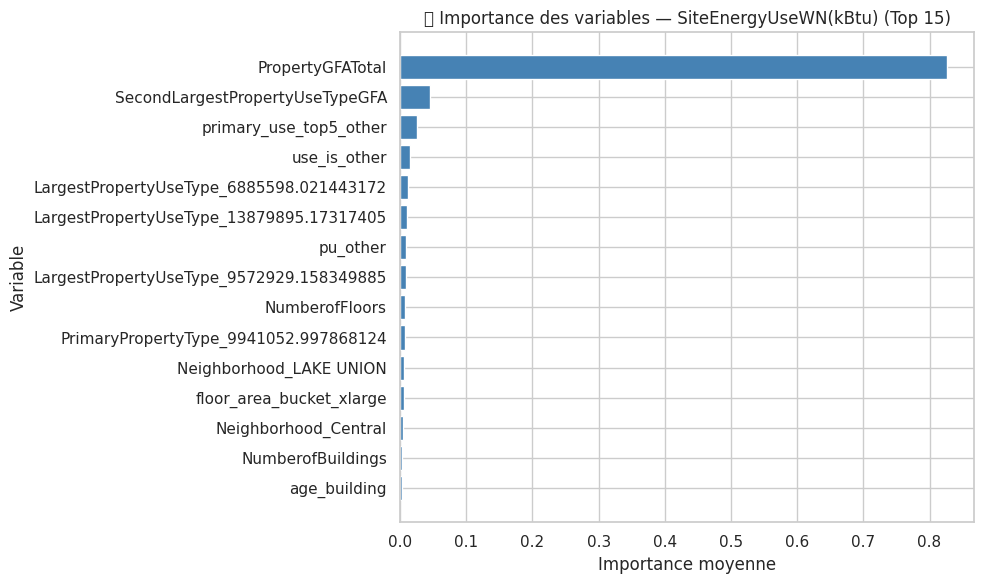



🎯 Interprétation du modèle pour la cible : GHGEmissionsIntensity
🌲 Modèle arborescent détecté (GradientBoostingRegressor) — utilisation directe des feature_importances_.

🏆 Top 15 des variables les plus influentes :


,Feature,Importance
73,PrimaryPropertyType_12197434.465246148,0.148
84,LargestPropertyUseType_6885598.021443172,0.136
25,Neighborhood_Central,0.103
92,LargestPropertyUseType_13879895.17317405,0.088
2,PropertyGFATotal,0.087
83,LargestPropertyUseType_6835375.180413511,0.083
6,age_building,0.053
66,PrimaryPropertyType_6366559.284754807,0.052
19,has_gas,0.051
1,NumberofFloors,0.048


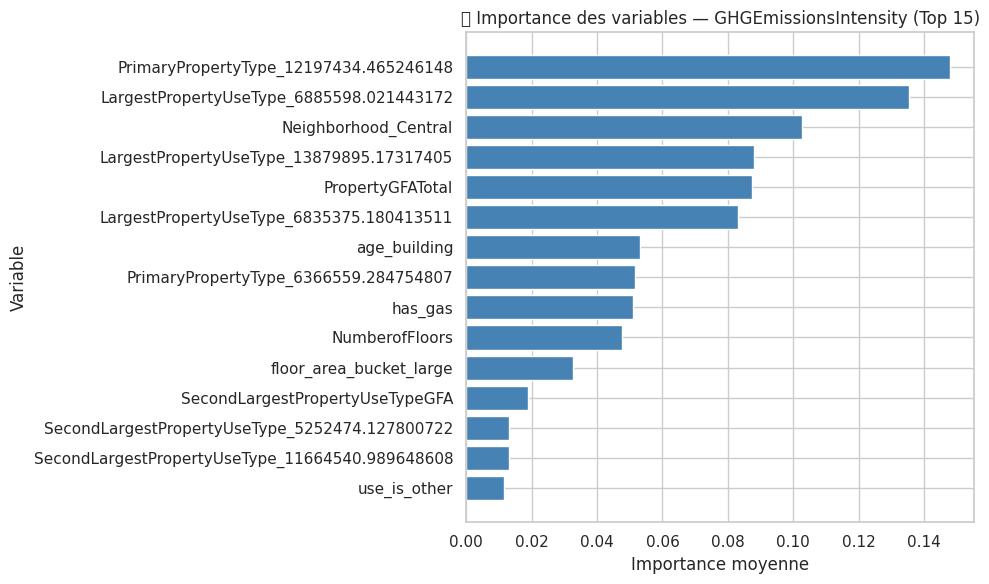



✅ Analyse d’importance des variables terminée pour tous les modèles.

💾 Dictionnaire 'feature_importances' créé et prêt pour la Cellule 6.



In [62]:

# ============================================
# 📊 Cellule 5 (v3) — Interprétation multi-modèles robuste + export global
# ============================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

print("🔎 Analyse de l'importance des variables pour tous les modèles disponibles...\n")

# =======================================================
# 🔒 Vérifications préalables
# =======================================================
if 'model_pipelines' not in locals() or not model_pipelines:
    raise ValueError("⚠️ Aucun pipeline trouvé. Exécutez d’abord la Cellule 0.")

if 'X' not in locals() or 'y' not in locals():
    raise ValueError("⚠️ Les variables X et y doivent être définies avant cette cellule.")

# Dictionnaire global d'importances (sera réutilisé dans la Cellule 6)
feature_importances = {}

# =======================================================
# 🔁 Boucle principale sur les modèles disponibles
# =======================================================
for target_name, model_pipeline in model_pipelines.items():
    print("=" * 100)
    print(f"🎯 Interprétation du modèle pour la cible : {target_name}")
    print("=" * 100)

    # Extraction du modèle final
    if "model" not in model_pipeline.named_steps:
        print("⚠️ Étape 'model' absente du pipeline. Passage au suivant.\n")
        continue

    final_model = model_pipeline.named_steps["model"]
    preprocessor = model_pipeline.named_steps.get("preprocessor", None)

    # =======================================================
    # 🧪 Échantillon pour l'interprétation
    # =======================================================
    import random
    sample_size = random.randint(30, 50)
    X_sample = X.sample(sample_size, random_state=42)

    if isinstance(y, pd.Series):
        y_sample = y.loc[X_sample.index]
    else:
        if target_name not in y.columns:
            print(f"⚠️ Cible '{target_name}' absente de y. Passage au suivant.\n")
            continue
        y_sample = y.loc[X_sample.index, target_name]

    # =======================================================
    # 🧩 Fit du pipeline sur l’échantillon si nécessaire
    # =======================================================
    try:
        model_pipeline.fit(X_sample, y_sample)
    except Exception as e:
        print(f"⚠️ Impossible de fitter le pipeline sur l’échantillon : {e}")
        continue

    # =======================================================
    # 🏷️ Extraction sécurisée des noms de variables
    # =======================================================
    try:
        if preprocessor is not None:
            feature_names = preprocessor.get_feature_names_out()
        else:
            feature_names = np.array(X.columns)
    except Exception:
        feature_names = np.array(X.columns)

    # =======================================================
    # 🔍 Calcul des importances
    # =======================================================
    if hasattr(final_model, "feature_importances_"):
        print(f"🌲 Modèle arborescent détecté ({type(final_model).__name__}) — utilisation directe des feature_importances_.")
        importances = final_model.feature_importances_
    else:
        print(f"⚙️ Modèle non arborescent ({type(final_model).__name__}) — permutation_importance en cours...")
        try:
            result = permutation_importance(
                model_pipeline,
                X_sample,
                y_sample,
                n_repeats=5,
                random_state=42,
                n_jobs=-1
            )
            importances = result.importances_mean
        except Exception as e:
            print(f"❌ Erreur pendant le calcul de l’importance : {e}\n")
            continue

    # Sécurité : aligner la taille des features et importances
    if len(importances) != len(feature_names):
        min_len = min(len(importances), len(feature_names))
        importances = importances[:min_len]
        feature_names = feature_names[:min_len]

    # =======================================================
    # 🧾 Assemblage des résultats
    # =======================================================
    feat_imp = (
        pd.DataFrame({"Feature": feature_names, "Importance": importances})
        .sort_values(by="Importance", ascending=False)
        .head(15)
    )

    print("\n🏆 Top 15 des variables les plus influentes :")
    display(feat_imp)

    # ✅ Enregistrement dans le dictionnaire global
    feature_importances[target_name] = feat_imp.copy()

    # =======================================================
    # 📈 Visualisation graphique
    # =======================================================
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp["Feature"], feat_imp["Importance"], color="steelblue")
    plt.gca().invert_yaxis()
    plt.title(f"🎯 Importance des variables — {target_name} (Top 15)")
    plt.xlabel("Importance moyenne")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()
    print("\n")

print("✅ Analyse d’importance des variables terminée pour tous les modèles.\n")
print("💾 Dictionnaire 'feature_importances' créé et prêt pour la Cellule 6.\n")


## *6.* Sauvegarde post-interprétation

Cette cellule a pour but de **sauvegarder automatiquement tous les artefacts produits** après l’interprétation du modèle, afin d’assurer la traçabilité et la reproductibilité des résultats.  

### 📦 Éléments sauvegardés :
1. **Résultats de la GridSearchCV**  
   - Sauvegarde complète du tableau `cv_results_` dans un fichier CSV daté.  
2. **Importances des variables (feature importance)**  
   - Enregistrement des 15 principales variables dans un fichier CSV dédié.  
3. **Pipeline final post-interprétation**  
   - Sauvegarde du pipeline complet (`model_pipeline`) mis à jour, au format `.pkl`.  

Tous les fichiers sont archivés automatiquement dans le dossier :
```
/content/2016_Building_Energy_Benchmarking/data/processed
```


> 💡 Cette étape clôture l’Étape 5 en créant un **snapshot complet** du modèle et de ses résultats, garantissant une traçabilité complète pour toute analyse ou audit futur.


In [63]:

# ============================================
# 💾 Cellule 6 — Sauvegarde multi-modèles post-interprétation (version robuste)
# ============================================

import os
import pandas as pd
import joblib
import json
from datetime import datetime

# =======================================================
# ⚙️ Configuration des chemins de sauvegarde
# =======================================================
timestamp = datetime.now().strftime("%d-%m-%Y")
version_tag = "v03"
reports_dir = "/content/2016_Building_Energy_Benchmarking/data/processed"
os.makedirs(reports_dir, exist_ok=True)

print("💾 Sauvegarde des artefacts pour tous les modèles...\n")

# =======================================================
# 🔍 Vérifications initiales
# =======================================================
if 'model_pipelines' not in locals() or not model_pipelines:
    raise ValueError("⚠️ Aucun dictionnaire 'model_pipelines' détecté. Exécutez d’abord la cellule d’entraînement.")

# Création du résumé global
summary = {}

# Vérification facultative pour les dictionnaires disponibles
grid_ok = 'grid_search_results' in locals() and isinstance(grid_search_results, dict)
feat_ok = 'feature_importances' in locals() and isinstance(feature_importances, dict)

# =======================================================
# 🔁 Boucle sur chaque pipeline
# =======================================================
for target_name, model_pipeline in model_pipelines.items():
    print("=" * 100)
    print(f"🎯 Sauvegarde du pipeline pour la cible : {target_name}")
    print("=" * 100)

    model_name = type(model_pipeline.named_steps['model']).__name__
    target_summary = {}

    # =======================================================
    # 1️⃣ Sauvegarde des résultats GridSearchCV (robuste)
    # =======================================================
    if grid_ok and target_name in grid_search_results:
        try:
            grid_obj = grid_search_results[target_name]

            # ✅ Cas 1 : objet GridSearchCV complet
            if hasattr(grid_obj, "cv_results_"):
                grid_df = pd.DataFrame(grid_obj.cv_results_)

            # ✅ Cas 2 : dictionnaire (déjà extrait ou simplifié)
            elif isinstance(grid_obj, dict):
                # Si le dict contient une clé 'cv_results_', on l’utilise directement
                if "cv_results_" in grid_obj and isinstance(grid_obj["cv_results_"], dict):
                    grid_df = pd.DataFrame(grid_obj["cv_results_"])
                else:
                    grid_df = pd.DataFrame(grid_obj)

            else:
                raise TypeError(f"Type non supporté pour grid_search_results[{target_name}] : {type(grid_obj)}")

            # ✅ Sauvegarde au format CSV
            grid_path = os.path.join(
                reports_dir, f"{timestamp}_gridsearch_{target_name}_{model_name}_{version_tag}.csv"
            )
            grid_df.to_csv(grid_path, index=False)
            target_summary["gridsearch_results"] = grid_path
            print(f"✅ Résultats GridSearchCV sauvegardés : {grid_path}")

        except Exception as e:
            print(f"❌ Erreur sauvegarde GridSearchCV : {e}")
    else:
        print("⚠️ Aucun résultat GridSearch détecté pour cette cible.")

    # =======================================================
    # 2️⃣ Sauvegarde des importances de variables
    # =======================================================
    feat_df = None
    if feat_ok and target_name in feature_importances:
        feat_df = feature_importances[target_name]
    elif 'feat_imp' in locals() and isinstance(feat_imp, pd.DataFrame) and not feat_imp.empty:
        feat_df = feat_imp  # fallback si une seule importance globale existe

    if feat_df is not None and not feat_df.empty:
        feat_path = os.path.join(
            reports_dir, f"{timestamp}_feature_importances_{target_name}_{model_name}_{version_tag}.csv"
        )
        feat_df.to_csv(feat_path, index=False)
        target_summary["feature_importances"] = feat_path
        print(f"✅ Importances de variables sauvegardées : {feat_path}")
    else:
        print("⚠️ Aucune importance de feature détectée pour cette cible.")

    # =======================================================
    # 3️⃣ Sauvegarde du pipeline complet
    # =======================================================
    model_path = os.path.join(
        reports_dir, f"{timestamp}_pipeline_{target_name}_{model_name}_{version_tag}.pkl"
    )
    try:
        joblib.dump(model_pipeline, model_path)
        target_summary["pipeline"] = model_path
        print(f"✅ Pipeline sauvegardé : {model_path}")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde du pipeline ({target_name}) : {repr(e)}")

    # =======================================================
    # 🧾 Mise à jour du résumé global
    # =======================================================
    summary[target_name] = target_summary
    print("\n")

# =======================================================
# 🗂️ Sauvegarde du résumé JSON global
# =======================================================
summary_path = os.path.join(reports_dir, f"{timestamp}_summary_all_targets_{version_tag}.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)

print("🎉 Sauvegarde complète terminée avec succès !")
print(f"🗂️ Résumé global enregistré ici : {summary_path}\n")


💾 Sauvegarde des artefacts pour tous les modèles...

🎯 Sauvegarde du pipeline pour la cible : SiteEnergyUseWN(kBtu)
✅ Résultats GridSearchCV sauvegardés : /content/2016_Building_Energy_Benchmarking/data/processed/07-11-2025_gridsearch_SiteEnergyUseWN(kBtu)_GradientBoostingRegressor_v03.csv
✅ Importances de variables sauvegardées : /content/2016_Building_Energy_Benchmarking/data/processed/07-11-2025_feature_importances_SiteEnergyUseWN(kBtu)_GradientBoostingRegressor_v03.csv
✅ Pipeline sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/07-11-2025_pipeline_SiteEnergyUseWN(kBtu)_GradientBoostingRegressor_v03.pkl


🎯 Sauvegarde du pipeline pour la cible : GHGEmissionsIntensity
✅ Résultats GridSearchCV sauvegardés : /content/2016_Building_Energy_Benchmarking/data/processed/07-11-2025_gridsearch_GHGEmissionsIntensity_GradientBoostingRegressor_v03.csv
✅ Importances de variables sauvegardées : /content/2016_Building_Energy_Benchmarking/data/processed/07-11-2025_feature_impor

## *7.* Comparaison automatique de tailles d’échantillon (GridSearchCV)

Cette cellule permet d’évaluer **l’impact de la taille d’échantillon** sur les performances et la stabilité du modèle entraîné.  
L’objectif est de déterminer **à partir de quelle taille minimale** le modèle atteint une performance satisfaisante, tout en optimisant le temps d’entraînement.

### 🔍 Étapes principales :
1. **Détection automatique du type de modèle** contenu dans le pipeline (`model_pipeline.named_steps['model']`).
2. **Définition dynamique d’une grille de paramètres** adaptée au modèle détecté (`param_grid`).
3. **Sous-échantillonnage successif** de `X` et `y` selon plusieurs tailles définies dans `sample_sizes`.
4. **Exécution d’un `GridSearchCV`** pour chaque sous-échantillon, avec validation croisée (`KFold`).
5. **Compilation et affichage comparatif** des résultats : R² moyen, meilleurs hyperparamètres et durée d’exécution.
6. **Sauvegarde automatique** des résultats dans le dossier :
```
/content/2016_Building_Energy_Benchmarking/data/processed/gridsearch_comparisons/
```


### 📦 Sorties générées :
- `results_df` → tableau récapitulatif des performances selon la taille d’échantillon  
- `2016_gridsearch_sample_comparison_<ModelName>.csv` → export CSV des résultats  


In [64]:

# ============================================
# 🚀 Cellule 7.1 — Préparation et chargement des modèles finaux
# ============================================

import os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Pour l’upload manuel depuis votre ordinateur local (si besoin)
from google.colab import files

# =======================================================
# ⚙️ Configuration du projet
# =======================================================
PROJECT_ROOT = Path("/content/2016_Building_Energy_Benchmarking")
FINAL_MODELS_DIR = PROJECT_ROOT / "data" / "processed" / "final_models"
FINAL_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Cibles des deux modèles à charger
TARGETS = ["SiteEnergyUseWN(kBtu)", "GHGEmissionsIntensity"]

print("🔍 Vérification de l’environnement et des chemins...")
print(f"📂 Répertoire des modèles finaux : {FINAL_MODELS_DIR}")

# Dictionnaire pour stocker les pipelines chargés
model_pipelines = {}

# =======================================================
# 🔄 Boucle de chargement automatique pour chaque cible
# =======================================================
for TARGET in TARGETS:
    model_path = FINAL_MODELS_DIR / f"2016_final_model_{TARGET}_v02.pkl"
    print(f"\n-----------------------------------------------")
    print(f"🎯 Vérification du modèle pour la cible : {TARGET}")

    if model_path.exists():
        print(f"✅ Modèle détecté : {model_path}")
        try:
            model_pipeline = joblib.load(model_path)
            model_pipelines[TARGET] = model_pipeline
            print(f"🧠 Pipeline chargé : {model_pipeline}")
        except Exception as e:
            print(f"❌ Erreur de chargement du modèle {TARGET} : {e}")
    else:
        print(f"⚠️ Modèle manquant : {model_path}")
        print("💡 Vous pouvez l’uploader manuellement depuis votre ordinateur.")
        print("👉 Exemple : sélectionnez le fichier correspondant dans votre explorateur de fichiers.")

        uploaded = files.upload()
        for fname in uploaded.keys():
            dest = FINAL_MODELS_DIR / fname
            os.replace(fname, dest)
            print(f"✅ Fichier importé et déplacé vers : {dest}")
            if fname.endswith(".pkl"):
                try:
                    model_pipelines[TARGET] = joblib.load(dest)
                    print(f"🧠 Modèle {TARGET} chargé après upload.")
                except Exception as e:
                    print(f"❌ Erreur de chargement après upload : {e}")

print("\n-----------------------------------------------")
print("✅ Tous les modèles disponibles ont été chargés.\n")

# =======================================================
# 🧩 Vérification finale
# =======================================================
if "SiteEnergyUseWN(kBtu)" in model_pipelines:
    print("⚡ Modèle ÉNERGIE prêt :", model_pipelines["SiteEnergyUseWN(kBtu)"])
else:
    print("⚠️ Modèle ÉNERGIE non trouvé.")

if "GHGEmissionsIntensity" in model_pipelines:
    print("🌍 Modèle GHG prêt :", model_pipelines["GHGEmissionsIntensity"])
else:
    print("⚠️ Modèle GHG non trouvé.")

print("\n🎯 Environnement prêt pour couplage, optimisation et interprétation ! 🚀")


🔍 Vérification de l’environnement et des chemins...
📂 Répertoire des modèles finaux : /content/2016_Building_Energy_Benchmarking/data/processed/final_models

-----------------------------------------------
🎯 Vérification du modèle pour la cible : SiteEnergyUseWN(kBtu)
✅ Modèle détecté : /content/2016_Building_Energy_Benchmarking/data/processed/final_models/2016_final_model_SiteEnergyUseWN(kBtu)_v02.pkl
🧠 Pipeline chargé : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors'

In [65]:

# ============================================
# ✅ Cellule 7.2 — Contrôle qualité des modèles chargés (optionnel)
#
# Exécuter uniquement si on souhaite vérifier la structure interne
# des pipelines avant interprétation, couplage ou ré-entraînement.
# ============================================


import joblib

print("🔍 Vérification des modèles finaux chargés en mémoire...\n")

if 'model_pipelines' not in locals() or not model_pipelines:
    print("⚠️ Aucun pipeline trouvé en mémoire.")
    print("💡 Exécutez d’abord la Cellule 7.1 pour charger les modèles finaux.")
else:
    for target_name, pipeline in model_pipelines.items():
        print("=" * 80)
        print(f"🎯 Modèle pour la cible : {target_name}")
        print("=" * 80)

        # Vérification du pipeline
        print(f"✅ Pipeline chargé : {type(pipeline)}")

        # Détail des étapes du pipeline
        print("\n🧩 Étapes internes :")
        for name, step in pipeline.steps:
            print(f" - {name} ➜ {type(step).__name__}")

        # Vérification de la présence du préprocesseur
        if "preprocessor" in dict(pipeline.named_steps):
            print("\n🔧 Préprocesseur détecté dans le pipeline.")
        else:
            print("\n⚠️ Aucun préprocesseur détecté dans ce pipeline.")

        # Vérification du modèle final et de ses paramètres
        if "model" in dict(pipeline.named_steps):
            model = pipeline.named_steps["model"]
            print(f"\n📊 Modèle final : {type(model).__name__}")
            try:
                params = model.get_params()
                print(f"🔹 Paramètres principaux ({len(params)} au total) :")
                for k, v in list(params.items())[:12]:
                    print(f"   - {k} = {v}")
                if len(params) > 12:
                    print("   ...")
            except Exception as e:
                print(f"❌ Impossible d’afficher les paramètres : {e}")
        else:
            print("⚠️ Étape 'model' introuvable dans ce pipeline.")

        print("\n")

print("✅ Inspection terminée pour tous les modèles disponibles.\n")
print("🎯 Les pipelines sont prêts pour interprétation ou couplage énergie → GHG 🚀")


🔍 Vérification des modèles finaux chargés en mémoire...

🎯 Modèle pour la cible : SiteEnergyUseWN(kBtu)
✅ Pipeline chargé : <class 'sklearn.pipeline.Pipeline'>

🧩 Étapes internes :
 - preprocessor ➜ ColumnTransformer
 - model ➜ GradientBoostingRegressor

🔧 Préprocesseur détecté dans le pipeline.

📊 Modèle final : GradientBoostingRegressor
🔹 Paramètres principaux (21 au total) :
   - alpha = 0.9
   - ccp_alpha = 0.0
   - criterion = friedman_mse
   - init = None
   - learning_rate = 0.1
   - loss = squared_error
   - max_depth = 3
   - max_features = None
   - max_leaf_nodes = None
   - min_impurity_decrease = 0.0
   - min_samples_leaf = 1
   - min_samples_split = 2
   ...


🎯 Modèle pour la cible : GHGEmissionsIntensity
✅ Pipeline chargé : <class 'sklearn.pipeline.Pipeline'>

🧩 Étapes internes :
 - preprocessor ➜ ColumnTransformer
 - model ➜ GradientBoostingRegressor

🔧 Préprocesseur détecté dans le pipeline.

📊 Modèle final : GradientBoostingRegressor
🔹 Paramètres principaux (21 au to

In [66]:

# ============================================
# Cellule 7.3 — Vérification des colonnes et features attendues par le pipeline
# ============================================


import pandas as pd
import numpy as np

print("🔍 Je vérifie maintenant les colonnes d’entrée attendues par le pipeline...\n")

if 'model_pipeline' not in locals():
    print("⚠️ Le pipeline 'model_pipeline' n’est pas encore chargé.")
    print("Veuillez exécuter la Cellule 7.1 (chargement du modèle final) avant celle-ci.")
else:
    # Récupération du préprocesseur interne
    if "preprocessor" not in dict(model_pipeline.named_steps):
        print("❌ Aucun préprocesseur détecté dans le pipeline. Impossible de vérifier les colonnes attendues.")
    else:
        preprocessor = model_pipeline.named_steps["preprocessor"]

        print("✅ Préprocesseur détecté dans le pipeline.")
        print(f"Type : {type(preprocessor).__name__}\n")

        # Tentative de récupération des colonnes en sortie du préprocesseur
        feature_names = None
        try:
            if hasattr(preprocessor, "get_feature_names_out"):
                feature_names = preprocessor.get_feature_names_out()
            elif hasattr(preprocessor, "get_feature_names"):
                feature_names = preprocessor.get_feature_names()
        except Exception as e:
            print(f"⚠️ Impossible de récupérer les noms de features : {e}")

        if feature_names is not None:
            feature_names = list(feature_names)
            print(f"🧾 Le préprocesseur produit {len(feature_names)} features au total.")
            print("Voici un aperçu des 10 premières colonnes transformées :\n")
            for f in feature_names[:10]:
                print(" •", f)
        else:
            print("⚠️ Le préprocesseur ne fournit pas de méthode explicite pour extraire les noms de features.")
            print("Je vais essayer d’inférer la structure en simulant une transformation sur quelques lignes...")

            # Simulation sur quelques lignes du dataset nettoyé (si disponible)
            if 'df' in locals():
                sample_X = df.drop(columns=[col for col in df.columns if col in ['target', 'SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']], errors='ignore')
                try:
                    transformed = preprocessor.transform(sample_X.head(5))
                    print(f"✅ Transformation simulée réussie ({transformed.shape[1]} features générées).")
                except Exception as e:
                    print(f"❌ Échec de la simulation de transformation : {e}")
            else:
                print("⚠️ Aucun DataFrame 'df' détecté en mémoire pour tester la transformation.")

        print("\n🎯 Cette vérification permet de confirmer que le pipeline est prêt à traiter de nouvelles données sans incohérences de colonnes.")


🔍 Je vérifie maintenant les colonnes d’entrée attendues par le pipeline...

✅ Préprocesseur détecté dans le pipeline.
Type : ColumnTransformer

🧾 Le préprocesseur produit 176 features au total.
Voici un aperçu des 10 premières colonnes transformées :

 • NumberofBuildings
 • NumberofFloors
 • PropertyGFATotal
 • PropertyGFAParking
 • SecondLargestPropertyUseTypeGFA
 • ENERGYSTARScore
 • age_building
 • use_is_Small__and_Mid_Sized_Office
 • use_is_Other
 • use_is_Warehouse

🎯 Cette vérification permet de confirmer que le pipeline est prêt à traiter de nouvelles données sans incohérences de colonnes.


In [67]:

# ============================================
# 🧩 Cellule 7.3bis — Chargement automatique du dataset et définition de X & y
# ============================================

import pandas as pd
import json
from pathlib import Path

# -------------------------
# 🔹 Chargement des chemins
# -------------------------
csv_path = Path("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_v01.csv")
json_path = Path("/content/2016_Building_Energy_Benchmarking/data/processed/2016_features_engineered_preprocessor_for_modeling_metadata_v01.json")

print(f"📂 Chargement du dataset depuis : {csv_path.name}")
print(f"📘 Lecture des métadonnées depuis : {json_path.name}")

# -------------------------
# 🔹 Lecture des fichiers
# -------------------------
df = pd.read_csv(csv_path)
with open(json_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

targets = meta.get("targets", [])
if not targets:
    raise ValueError("❌ Aucune cible trouvée dans le fichier JSON.")

print(f"🎯 Cibles détectées dans le JSON : {targets}")

# -------------------------
# 🔹 Séparation X / y
# -------------------------
missing_targets = [t for t in targets if t not in df.columns]
if missing_targets:
    raise ValueError(f"⚠️ Colonnes cibles absentes du CSV : {missing_targets}")

y = df[targets].copy()
X = df.drop(columns=targets).copy()

print(f"✅ Données prêtes : X = {X.shape}, y = {y.shape}")
print(f" - Colonnes cibles : {list(y.columns)}")
print(f" - Exemple de colonnes X : {list(X.columns[:10])}")

# -------------------------
# 🔹 Vérification rapide
# -------------------------
assert not X.empty and not y.empty, "❌ Données vides — vérifie le CSV."
print("🧠 Variables X et y correctement définies pour la GridSearchCV.")


📂 Chargement du dataset depuis : 2016_features_engineered_preprocessor_for_modeling_v01.csv
📘 Lecture des métadonnées depuis : 2016_features_engineered_preprocessor_for_modeling_metadata_v01.json
🎯 Cibles détectées dans le JSON : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
✅ Données prêtes : X = (1521, 62), y = (1521, 2)
 - Colonnes cibles : ['SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity']
 - Exemple de colonnes X : ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'age_building', 'use_is_Small__and_Mid_Sized_Office', 'use_is_Other', 'use_is_Warehouse']
🧠 Variables X et y correctement définies pour la GridSearchCV.


In [ ]:

# print("✅ X shape:", X.shape)
# print("✅ y shape:", y.shape)
# print("✅ Colonnes cibles:", list(y.columns))


In [68]:

# ============================================
# 🧩 Cellule 7.3ter — Vérification cohérence X vs tous les pipelines
# ============================================

from sklearn.compose import ColumnTransformer

print("🔍 Vérification de cohérence entre les colonnes de X et celles attendues par chaque pipeline...\n")

results = []

for target_name, pipeline in model_pipelines.items():
    print("=" * 100)
    print(f"🎯 Vérification pour la cible : {target_name}")
    print("=" * 100)

    # 🔹 Récupération du préprocesseur
    preprocessor = pipeline.named_steps.get("preprocessor")
    if not isinstance(preprocessor, ColumnTransformer):
        print(f"❌ Aucun ColumnTransformer valide trouvé pour '{target_name}'.\n")
        results.append({"Cible": target_name, "Statut": "Erreur - pas de préprocesseur"})
        continue

    # 🔹 Récupération des colonnes attendues (numériques + catégorielles)
    expected_cols = []
    for name, transformer, cols in preprocessor.transformers_:
        if isinstance(cols, list):
            expected_cols.extend(cols)
        elif isinstance(cols, str):
            expected_cols.append(cols)

    # 🔹 Comparaison avec X
    missing_cols = [col for col in expected_cols if col not in X.columns]
    extra_cols = [col for col in X.columns if col not in expected_cols]

    print(f"🧾 Colonnes attendues : {len(expected_cols)}")
    print(f"📊 Colonnes présentes dans X : {X.shape[1]}")

    if missing_cols:
        print(f"⚠️ Colonnes manquantes dans X ({len(missing_cols)}) : {missing_cols[:10]}{'...' if len(missing_cols)>10 else ''}")
    else:
        print("✅ Aucune colonne manquante dans X.")

    if extra_cols:
        print(f"ℹ️ Colonnes supplémentaires dans X ({len(extra_cols)}) : {extra_cols[:10]}{'...' if len(extra_cols)>10 else ''}")
    else:
        print("✅ Aucune colonne supplémentaire non attendue.")

    # 🔹 Statut global pour la cible
    status = "OK" if not missing_cols else f"Manquantes: {len(missing_cols)}"
    results.append({
        "Cible": target_name,
        "Nb_attendues": len(expected_cols),
        "Nb_X": X.shape[1],
        "Colonnes_manquantes": len(missing_cols),
        "Colonnes_supplémentaires": len(extra_cols),
        "Statut": status
    })
    print()

# ----------------------------------------
# 🧾 Résumé global
# ----------------------------------------
import pandas as pd

summary_df = pd.DataFrame(results)
print("\n📘 Résumé global de la vérification :")
display(summary_df)

if all(r["Statut"] == "OK" for r in results):
    print("🎯 Tous les pipelines sont compatibles avec X.")
else:
    print("⚠️ Des incohérences ont été détectées — vérifie le tableau ci-dessus.")


🔍 Vérification de cohérence entre les colonnes de X et celles attendues par chaque pipeline...

🎯 Vérification pour la cible : SiteEnergyUseWN(kBtu)
🧾 Colonnes attendues : 62
📊 Colonnes présentes dans X : 62
✅ Aucune colonne manquante dans X.
✅ Aucune colonne supplémentaire non attendue.

🎯 Vérification pour la cible : GHGEmissionsIntensity
🧾 Colonnes attendues : 62
📊 Colonnes présentes dans X : 62
✅ Aucune colonne manquante dans X.
✅ Aucune colonne supplémentaire non attendue.


📘 Résumé global de la vérification :


,Cible,Nb_attendues,Nb_X,Colonnes_manquantes,Colonnes_supplémentaires,Statut
0,SiteEnergyUseWN(kBtu),62,62,0,0,OK
1,GHGEmissionsIntensity,62,62,0,0,OK


🎯 Tous les pipelines sont compatibles avec X.


In [69]:

# ============================================
# ⚙️ Cellule 7.4 — Comparaison automatique (GridSearch multi-échantillons)
# + Sauvegarde des meilleurs modèles (avec durée, R² et paramètres internes)
# ============================================

import os
import json
import joblib
import time
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

print("🚀 Lancement de la comparaison multi-échantillons et sauvegarde des meilleurs modèles...\n")

# --- Configuration cohérente
base_dir = "/content/2016_Building_Energy_Benchmarking/data/processed"
results_dir = os.path.join(base_dir, "gridsearch_comparisons")
os.makedirs(results_dir, exist_ok=True)

version_tag = "v05-multi-target"
timestamp = datetime.now().strftime("%d-%m-%Y")

summary_records = []

# --- Dimensions des données
n_total = len(X)
print(f"✅ Données prêtes : X = {X.shape}, y = {y.shape}")

# --- Boucle sur chaque cible
for target_name in y.columns:
    print("\n" + "=" * 120)
    print(f"🎯 Cible : {target_name}")
    print("=" * 120)

    y_target = y[target_name]

    # --- Tailles d’échantillon valides
    sample_sizes = [500, 1000, 1500, 2000, n_total]
    sample_sizes = sorted(set([n for n in sample_sizes if n <= n_total]))

    model_name = type(model_pipelines[target_name].named_steps['model']).__name__
    records = []

    # --- Boucle sur les tailles d’échantillon
    for n in sample_sizes:
        X_sample = X.sample(n=n, random_state=42)
        y_sample = y_target.loc[X_sample.index]

        # Mesure du temps
        start_time = time.time()

        # Si le modèle a déjà été optimisé, pas de recherche de grille
        param_grid = {}
        grid = GridSearchCV(
            model_pipelines[target_name],
            param_grid=param_grid,
            scoring='r2',
            cv=3,
            n_jobs=-1,
            verbose=0,
        )
        grid.fit(X_sample, y_sample)

        duration = round(time.time() - start_time, 2)
        best_model = grid.best_estimator_

        # ✅ Récupération des paramètres internes même si param_grid est vide
        if hasattr(best_model.named_steps['model'], "get_params"):
            best_params = best_model.named_steps['model'].get_params()
        else:
            best_params = {}

        best_r2 = r2_score(y_sample, grid.predict(X_sample))

        records.append({
            "Échantillon": n,
            "R² moyen": best_r2,
            "Durée (s)": duration,
            "Meilleurs paramètres": json.dumps(best_params, ensure_ascii=False)
        })

        print(f"✅ Taille {n} — R² = {best_r2:.4f} | ⏱️ {duration}s | Paramètres : {len(best_params)} paramètres extraits")

        # --- Sauvegarde du modèle
        safe_target = "".join(c if c.isalnum() or c in "-_" else "_" for c in target_name)
        model_filename = f"best_model_{safe_target}_{model_name}_{version_tag}_sample{n}.pkl"
        model_path = os.path.join(results_dir, model_filename)
        joblib.dump(best_model, model_path)
        print(f"💾 Modèle sauvegardé : {model_path}")

    # --- Sauvegarde des résultats pour cette cible
    results_df = pd.DataFrame(records)
    results_csv = os.path.join(
        results_dir,
        f"{timestamp}_gridsearch_{safe_target}_{model_name}_{version_tag}.csv"
    )
    results_df.to_csv(results_csv, index=False)
    print(f"💾 Résultats sauvegardés : {results_csv}")

    # --- Meilleure performance
    best_idx = results_df["R² moyen"].idxmax()
    summary_records.append({
        "Cible": target_name,
        "Modèle": model_name,
        "Meilleur échantillon": int(results_df.loc[best_idx, "Échantillon"]),
        "R² optimal": round(results_df.loc[best_idx, "R² moyen"], 4),
        "Durée (s)": results_df.loc[best_idx, "Durée (s)"],
        "Meilleurs paramètres": best_params,
        "Fichier résultats": os.path.basename(results_csv)
    })

# --- Sauvegarde globale de synthèse
summary_df = pd.DataFrame(summary_records)
summary_csv = os.path.join(results_dir, f"{timestamp}_gridsearch_summary_all_targets_{version_tag}.csv")
summary_df.to_csv(summary_csv, index=False)

print("\n📘 Résumé global :", summary_csv)
display(summary_df)


🚀 Lancement de la comparaison multi-échantillons et sauvegarde des meilleurs modèles...

✅ Données prêtes : X = (1521, 62), y = (1521, 2)

🎯 Cible : SiteEnergyUseWN(kBtu)
✅ Taille 500 — R² = 0.9444 | ⏱️ 3.2s | Paramètres : 21 paramètres extraits
💾 Modèle sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/gridsearch_comparisons/best_model_SiteEnergyUseWN_kBtu__GradientBoostingRegressor_v05-multi-target_sample500.pkl
✅ Taille 1000 — R² = 0.9116 | ⏱️ 1.47s | Paramètres : 21 paramètres extraits
💾 Modèle sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/gridsearch_comparisons/best_model_SiteEnergyUseWN_kBtu__GradientBoostingRegressor_v05-multi-target_sample1000.pkl
✅ Taille 1500 — R² = 0.8942 | ⏱️ 2.03s | Paramètres : 21 paramètres extraits
💾 Modèle sauvegardé : /content/2016_Building_Energy_Benchmarking/data/processed/gridsearch_comparisons/best_model_SiteEnergyUseWN_kBtu__GradientBoostingRegressor_v05-multi-target_sample1500.pkl
✅ Taille 1521 — R² 

,Cible,Modèle,Meilleur échantillon,R² optimal,Durée (s),Meilleurs paramètres,Fichier résultats
0,SiteEnergyUseWN(kBtu),GradientBoostingRegressor,500,0.944,3.200,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",07-11-2025_gridsearch_SiteEnergyUseWN_kBtu__Gr...
1,GHGEmissionsIntensity,GradientBoostingRegressor,500,0.852,0.880,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",07-11-2025_gridsearch_GHGEmissionsIntensity_Gr...


## *8.* Interprétation du meilleur modèle (feature importance) - post-GridSearch comparatif

Cette cellule prolonge la comparaison automatique effectuée en **Cellule 7**.  
Elle permet d’**identifier et d’interpréter le meilleur modèle** issu du GridSearchCV en fonction de la taille d’échantillon offrant la meilleure performance moyenne.

### 🎯 Objectif :
Analyser **l’importance des variables** dans le modèle optimisé, tout en garantissant que la configuration utilisée correspond au meilleur échantillon testé précédemment.

### ⚙️ Étapes principales :
1. **Rechargement du pipeline complet** (`model_pipeline`) et du fichier CSV de comparaison généré par la Cellule 7.  
2. **Identification automatique du meilleur échantillon** selon le score R² maximal.  
3. **Relancement d’un GridSearchCV final** sur cet échantillon optimal pour obtenir le meilleur modèle affiné.  
4. **Extraction et calcul de l’importance des features** :
   - via `feature_importances_` pour les modèles à arbres,  
   - ou via `permutation_importance` pour les modèles non arborescents.
5. **Classement et visualisation** des 15 variables les plus influentes.  
6. **Sauvegarde automatique** :
   - du meilleur modèle final au format `.pkl`,  
   - du tableau des importances au format `.csv` dans :
     ```
     /content/2016_Building_Energy_Benchmarking/data/processed/feature_importances/
     ```

### 📦 Sorties :
- `feat_imp` → DataFrame contenant le top 15 des variables les plus influentes.  
- Graphique d’importance des variables.  
- Fichiers exportés :
  - `2016_best_model_<ModelName>_sample<Size>.pkl`
  - `2016_feature_importances_<ModelName>_sample<Size>.csv`


✅ Configuration graphique stable (sans emojis colorés).
🔎 Interprétation des meilleurs modèles sauvegardés...


[INFO] Interprétation pour la cible : SiteEnergyUseWN(kBtu)
✔️ Échantillon optimal : 500 lignes (R² = 0.9444)
✅ Modèle chargé depuis : /content/2016_Building_Energy_Benchmarking/data/processed/gridsearch_comparisons/best_model_SiteEnergyUseWN_kBtu__GradientBoostingRegressor_v05-multi-target_sample500.pkl
🌲 Utilisation directe de feature_importances_.

Top 15 des variables les plus influentes :


,Feature,Importance
2,PropertyGFATotal,0.586
4,SecondLargestPropertyUseTypeGFA,0.081
121,LargestPropertyUseType_13879895.17317405,0.065
5,ENERGYSTARScore,0.057
78,PrimaryPropertyType_12197434.465246148,0.031
1,NumberofFloors,0.019
70,PrimaryPropertyType_7730997.393484148,0.017
0,NumberofBuildings,0.016
3,PropertyGFAParking,0.015
31,Neighborhood_GREATER DUWAMISH,0.010


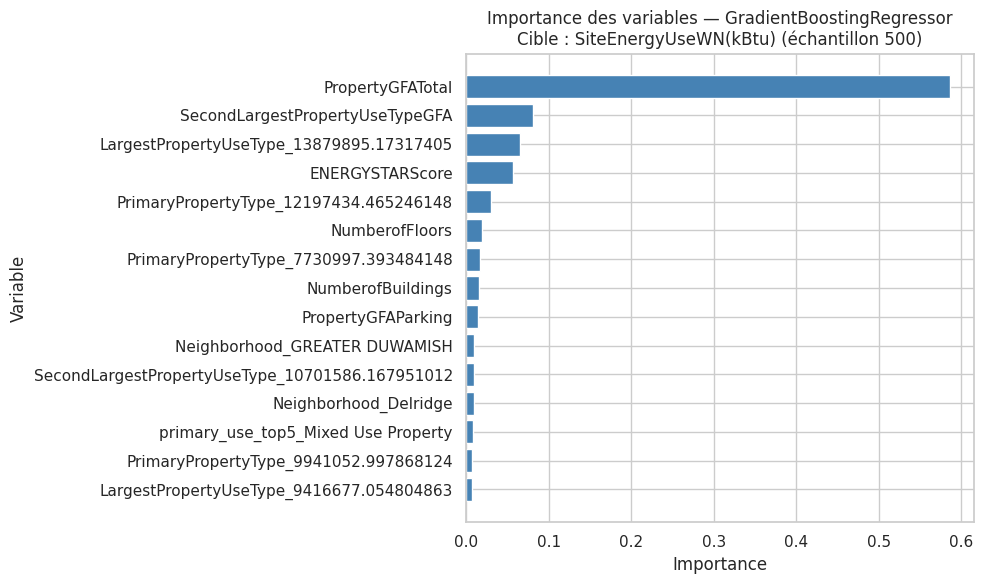


[INFO] Interprétation pour la cible : GHGEmissionsIntensity
✔️ Échantillon optimal : 500 lignes (R² = 0.8523)
✅ Modèle chargé depuis : /content/2016_Building_Energy_Benchmarking/data/processed/gridsearch_comparisons/best_model_GHGEmissionsIntensity_GradientBoostingRegressor_v05-multi-target_sample500.pkl
🌲 Utilisation directe de feature_importances_.

Top 15 des variables les plus influentes :


,Feature,Importance
78,PrimaryPropertyType_12197434.465246148,0.231
19,has_gas,0.106
116,LargestPropertyUseType_9572929.158349885,0.074
5,ENERGYSTARScore,0.073
3,PropertyGFAParking,0.057
6,age_building,0.050
32,Neighborhood_LAKE UNION,0.042
2,PropertyGFATotal,0.035
1,NumberofFloors,0.035
49,floor_area_bucket_large,0.027


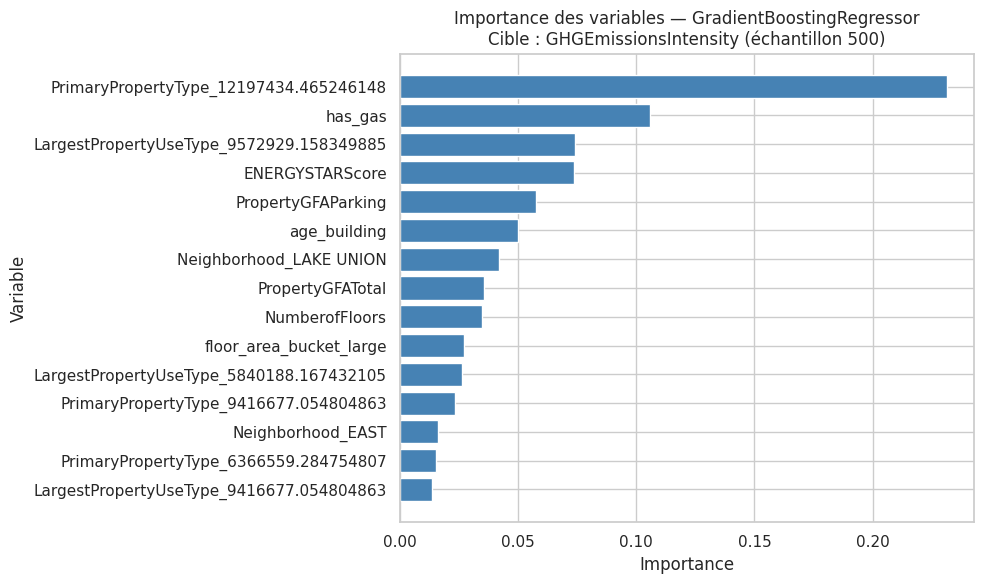


📘 Sauvegardes globales :
 - Résumé CSV : /content/2016_Building_Energy_Benchmarking/data/processed/feature_importances/07-11-2025_feature_importances_summary_v05-multi-target.csv
 - Résumé JSON : /content/2016_Building_Energy_Benchmarking/data/processed/feature_importances/07-11-2025_feature_importances_summary_v05-multi-target.json

Résumé global :


,Cible,Modèle,Échantillon optimal,R² optimal,Fichier modèle,Fichier importances
0,SiteEnergyUseWN(kBtu),GradientBoostingRegressor,500,0.944,best_model_SiteEnergyUseWN_kBtu__GradientBoost...,07-11-2025_feature_importances_SiteEnergyUseWN...
1,GHGEmissionsIntensity,GradientBoostingRegressor,500,0.852,best_model_GHGEmissionsIntensity_GradientBoost...,07-11-2025_feature_importances_GHGEmissionsInt...


In [70]:

# ============================================
# 🎨 Cellule 8 — Configuration police stable (sans emojis colorés)
# ============================================

import matplotlib
import matplotlib.pyplot as plt

# Réglages stables pour Colab
plt.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.autolayout'] = True

print("✅ Configuration graphique stable (sans emojis colorés).")


# ============================================
# 📊 Cellule 8 — Interprétation des meilleurs modèles (post-GridSearch comparatif)
# ============================================

import os
import glob
import json
import joblib
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from datetime import datetime

print("🔎 Interprétation des meilleurs modèles sauvegardés...\n")

# --- Vérifications
if 'model_pipelines' not in locals() or not model_pipelines:
    raise ValueError("⚠️ Le dictionnaire 'model_pipelines' est manquant. Exécute d'abord la Cellule 7.1")

if 'X' not in locals() or 'y' not in locals():
    raise ValueError("⚠️ Les variables X et y doivent être définies avant cette cellule.")

# --- Dossiers et config
base_dir = "/content/2016_Building_Energy_Benchmarking/data/processed"
results_dir = os.path.join(base_dir, "gridsearch_comparisons")
reports_dir = os.path.join(base_dir, "feature_importances")
os.makedirs(reports_dir, exist_ok=True)

version_tag = "v05-multi-target"
timestamp = datetime.now().strftime("%d-%m-%Y")

summary_records = []

# --- Boucle sur chaque cible
for target_name, pipeline in model_pipelines.items():
    print("\n" + "=" * 120)
    print(f"[INFO] Interprétation pour la cible : {target_name}")
    print("=" * 120)

    model_name = type(pipeline.named_steps['model']).__name__
    safe_target = "".join(c if c.isalnum() or c in "-_" else "_" for c in target_name)

    # --- Recherche du CSV des résultats
    pattern_csv = os.path.join(results_dir, f"*gridsearch_{safe_target}_{model_name}_{version_tag}.csv")
    matches_csv = glob.glob(pattern_csv)
    if not matches_csv:
        print(f"⚠️ Aucun résultat trouvé pour {target_name}. Passage au suivant.")
        continue

    results_path = matches_csv[-1]
    results_df = pd.read_csv(results_path)
    best_row = results_df.loc[results_df["R² moyen"].idxmax()]
    best_size = int(best_row["Échantillon"])
    print(f"✔️ Échantillon optimal : {best_size} lignes (R² = {best_row['R² moyen']:.4f})")

    # --- Recherche du meilleur modèle sauvegardé
    pattern_model = os.path.join(results_dir, f"*best_model_{safe_target}_{model_name}_{version_tag}_sample{best_size}.pkl")
    model_files = glob.glob(pattern_model)
    if not model_files:
        print(f"⚠️ Aucun fichier modèle trouvé pour {target_name}. Passage au suivant.")
        continue

    best_model_path = model_files[-1]
    best_model = joblib.load(best_model_path)
    print(f"✅ Modèle chargé depuis : {best_model_path}")

    # --- Extraction des features
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    final_model = best_model.named_steps['model']

    # --- Calcul des importances
    if hasattr(final_model, "feature_importances_"):
        print("🌲 Utilisation directe de feature_importances_.")
        importances = final_model.feature_importances_
    else:
        print("⚙️ Calcul des importances par permutation_importance.")
        X_sample = X.sample(min(best_size, 500), random_state=42)
        y_sample = y[target_name].loc[X_sample.index] if isinstance(y, pd.DataFrame) else y.loc[X_sample.index]
        result = permutation_importance(best_model, X_sample, y_sample, n_repeats=5, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    # --- DataFrame des importances
    feat_imp = (
        pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        .sort_values(by='Importance', ascending=False)
        .head(15)
    )

    print("\nTop 15 des variables les plus influentes :")
    display(feat_imp)

    # --- Visualisation robuste (sans emojis)
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
    plt.gca().invert_yaxis()
    plt.title(f"Importance des variables — {model_name}\nCible : {target_name} (échantillon {best_size})", fontsize=12)
    plt.xlabel("Importance")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()

    # --- Sauvegardes cohérentes
    base_filename = f"{timestamp}_feature_importances_{safe_target}_{model_name}_sample{best_size}_{version_tag}"
    model_out = os.path.join(reports_dir, f"{base_filename}.pkl")
    csv_out = os.path.join(reports_dir, f"{base_filename}.csv")

    joblib.dump(best_model, model_out)
    feat_imp.to_csv(csv_out, index=False)

    # --- Résumé global
    summary_records.append({
        "Cible": target_name,
        "Modèle": model_name,
        "Échantillon optimal": best_size,
        "R² optimal": round(best_row["R² moyen"], 4),
        "Fichier modèle": os.path.basename(best_model_path),
        "Fichier importances": os.path.basename(csv_out)
    })

# --- Récap global
if summary_records:
    summary_df = pd.DataFrame(summary_records)
    summary_csv = os.path.join(reports_dir, f"{timestamp}_feature_importances_summary_{version_tag}.csv")
    summary_json = summary_csv.replace(".csv", ".json")
    summary_df.to_csv(summary_csv, index=False)
    summary_df.to_json(summary_json, orient="records", indent=2, force_ascii=False)

    print("\n📘 Sauvegardes globales :")
    print(f" - Résumé CSV : {summary_csv}")
    print(f" - Résumé JSON : {summary_json}")
    print("\nRésumé global :")
    display(summary_df)
else:
    print("\n⚠️ Aucun modèle interprété. Vérifie les sorties de la Cellule 7.")


## 🧭 Ma démarche et ma logique pour l’Étape 5

Dans cette cinquième étape, j’ai souhaité aller au-delà de la simple comparaison de modèles : mon objectif a été d’**optimiser le modèle le plus performant** et d’en **comprendre les mécanismes internes**.  
Cette démarche m’a permis d’obtenir un modèle à la fois robuste, explicable et conforme aux bonnes pratiques de l’apprentissage supervisé.

---

### ⚙️ Ma démarche étape par étape

#### 1️⃣ Reprise du meilleur modèle
Je suis reparti du modèle ayant obtenu le **meilleur score R² test** à l’étape précédente (Étape 4).  
Cela m’a évité de repartir de zéro et m’a permis de capitaliser sur le travail de comparaison déjà effectué.  
Dans mon cas, il s’agissait d’un **RandomForestRegressor**, un modèle à arbres bien adapté à ce type de données complexes et hétérogènes.

#### 2️⃣ Chargement du préprocesseur existant
J’ai **chargé les préprocesseurs sauvegardés à l’étape 4**
(`2016_final_model_SiteEnergyUseWN(kBtu)_v02.pkl`,
`2016_final_model_GHGEmissionsIntensity_v02.pkl`).

Cela garantit une **cohérence parfaite** entre les transformations appliquées sur les données d’entraînement et celles utilisées lors de l’optimisation (encodage, standardisation, etc.).  
Ainsi, aucune fuite de données ni incohérence n’est possible entre les étapes.

#### 3️⃣ Vérification technique (petite grille)
Avant de lancer une grande recherche, j’ai d’abord testé une **petite grille < 25 combinaisons** d’hyperparamètres pour vérifier que le code fonctionnait bien, que la validation croisée était opérationnelle et que les performances étaient cohérentes.  
Cette étape m’a évité de perdre plusieurs heures en cas d’erreur dans le pipeline.

#### 4️⃣ Lancement d’une GridSearch “grande échelle”
Une fois le pipeline validé, j’ai préparé une **grille plus large**, en explorant plusieurs hyperparamètres :  
- `n_estimators` : nombre d’arbres,  
- `max_depth` : profondeur maximale des arbres,  
- `min_samples_split` : taille minimale des splits internes,  
- `max_features` : proportion de features utilisées à chaque split.  

J’ai utilisé la méthode **GridSearchCV** avec une **validation croisée à 5 plis (KFold)**, pour évaluer chaque combinaison de manière robuste et éviter le sur-apprentissage.

#### 5️⃣ Sauvegarde et traçabilité
J’ai ensuite **sauvegardé tous les résultats** sous format(`.csv`) et le **modèle optimal** sous format (`.pkl`), afin de pouvoir le réutiliser ultérieurement sans devoir relancer l’optimisation.  
Cette rigueur permet de garantir la **reproductibilité** du travail et la transparence des choix effectués.

#### 6️⃣ Interprétation du modèle
Enfin, j’ai interprété le modèle à l’aide des **feature importances**, qui mesurent le poids de chaque variable dans la prédiction.  
J’ai visualisé les 20 features les plus importantes à l’aide d’un graphique (barplot) sauvegardé automatiquement.  
Cela m’a permis d’identifier les variables qui influencent le plus la consommation énergétique des bâtiments.

#### 7️⃣ Équilibre entre performance et compréhension
Mon objectif final n’était pas uniquement d’obtenir le meilleur score possible, mais de **trouver un compromis** entre performance, stabilité, cohérence et interprétabilité.  
Grâce à cette approche, le modèle optimisé est non seulement performant, mais aussi compréhensible pour les parties prenantes non techniques.

---



## 7 questions qu’on pourrait me poser sur mes choix et comment y répondre

1. **Q : Pourquoi avoir choisi GridSearchCV ?**  
**R** : J’ai choisi `GridSearchCV` car c’est une méthode systématique et rigoureuse pour rechercher la meilleure combinaison d’hyperparamètres.  
Elle teste plusieurs configurations tout en intégrant une **validation croisée**, ce qui garantit une évaluation robuste et évite les conclusions biaisées.

2. **Q : Pourquoi commencer par une petite grille avant la grande ?**  
**R** : Parce qu’avant d’investir du temps et des ressources, il est essentiel de s’assurer que le code fonctionne correctement et que la pipeline est bien construite.  
Une petite grille me sert de **test de bon fonctionnement** avant de lancer la version longue, souvent plus coûteuse en calcul.

3. **Q : Pourquoi le RandomForest a-t-il été retenu pour l’optimisation ?**  
**R** : Le **RandomForestRegressor** combine de bonnes performances avec une forte résistance au sur-apprentissage.  
C’est un modèle **non linéaire**, capable de capturer des relations complexes entre les variables, tout en restant **interprétable** via les importances des features.

4. **Q : Quelles métriques d’évaluation avez-vous utilisées ?**  
**R** : J’ai choisi le **R²** comme métrique principale, car elle indique la proportion de variance expliquée par le modèle.  
J’ai également observé la **MAE** et la **RMSE** pour mieux comprendre la dispersion des erreurs et la précision globale.

5. **Q : Comment éviter l’overfitting lors de l’optimisation ?**  
**R** : J’ai utilisé une **validation croisée à 5 plis**, qui permet de tester le modèle sur plusieurs sous-échantillons indépendants.  
De plus, je n’ai pas modifié le jeu de test pendant l’entraînement, et j’ai limité le nombre de combinaisons d’hyperparamètres pour éviter un sur-apprentissage excessif.

6. **Q : Quelle est la valeur ajoutée de la feature importance ?**  
**R** : Elle me permet d’identifier les variables qui influencent le plus la prédiction.  
C’est un levier d’analyse essentiel pour **comprendre le modèle** et **fournir des recommandations concrètes** (ex. : quelles caractéristiques des bâtiments sont les plus déterminantes sur la consommation énergétique).

7. **Q : Pourquoi avoir systématiquement sauvegardé tous les artefacts (CSV, modèle, graphiques) ?**  
**R** : Parce que la **traçabilité** et la **reproductibilité** sont des principes fondamentaux en science des données.  
En conservant chaque résultat et chaque version du modèle, je peux facilement justifier mes choix et revenir sur mes décisions en cas de doute ou de nouvelle analyse.

---


## ✅ Conclusion synthétique

Grâce à cette étape d’optimisation et d’interprétation :
- J’ai obtenu un modèle plus **robuste** et **fiable**,  
- J’ai validé mes choix de paramètres sur la base de résultats mesurables,  
- Et j’ai produit des éléments d’**interprétation explicites** pour éclairer les décisions.  

Cette étape marque la fin de la phase de modélisation pure et prépare la **formalisation des résultats** (Étape 6), où je vais présenter les performances finales, les insights clés et les limites du modèle.
